# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [57]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install imgaug
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install fuzzy-c-means
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install imblearn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [58]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rc('axes', axisbelow=True)
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score, mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN, Birch, KMeans
from sklearn.preprocessing import label_binarize
from fcmeans import FCM
from imblearn.over_sampling import BorderlineSMOTE



In [3]:
RANDOM_STATE=50

In [4]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [5]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    if class_ != '.DS_Store':
        path = os.path.join(data_path, class_)
        imgs_of_class = os.listdir(path)
        imgs += [os.path.join(path, x) for x in imgs_of_class]
        labels += [class_] * len(imgs_of_class)

## Data Analysis

In [6]:
print("# observations:", len(labels))

# observations: 170


In [7]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


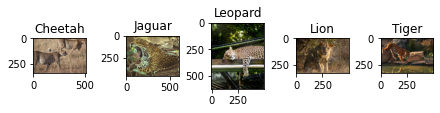

In [8]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [9]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] != "3.3":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

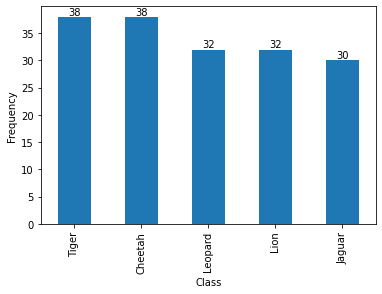

In [10]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Data Augmentation

In [11]:
def aug_data(data, labels, display_idx={}):
    all_imgs = []
    all_labels = []
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.PerspectiveTransform(scale=(0.05, 0.15))
    ])

    for i, x in enumerate(data):
        if '.DS_Store' not in x:
            img = cv.imread(x)
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            aug_img = aug_seq(images=[img])

            all_imgs.append(img)
            all_imgs.append(aug_img[0])
            all_labels.append(labels[i])
            all_labels.append(labels[i])

        if i in display_idx:
            fig, axs = plt.subplots(1, 2, constrained_layout=True)
            axs = axs.flatten()
            axs[0].imshow(img)
            axs[0].title.set_text('Original')
            axs[1].imshow(aug_img[0])
            axs[1].title.set_text('Augmented')
            plt.show()

    return all_imgs, all_labels

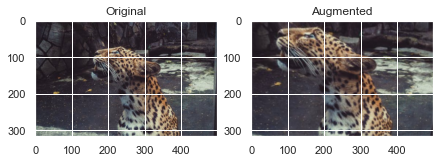

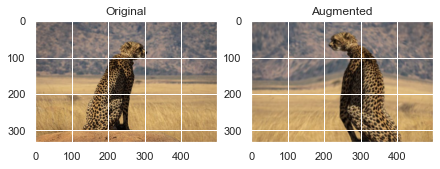

/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/validation.py:852: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: Expected 2D array, got 1D array instead:
array=[array([[[117, 163,  65],
         [108, 154,  56],
         [ 99, 140,  48],
         ...,
         [  4,   9,   2],
         [  4,   9,   2],
         [  4,   9,   2]],

        [[117, 160,  68],
         [108, 151,  59],
         [ 97, 137,  48],
         ...,
         [  4,   9,   2],
         [  4,   9,   2],
         [  3,   8,   1]],

        [[112, 150,  65],
         [103, 141,  58],
         [ 93, 128,  48],
         ...,
         [  5,   7,   2],
         [  5,   7,   2],
         [  5,   7,   2]],

        ...,

        [[  0,  11,   1],
         [  0,  12,   2],
         [  4,  11,   3],
         ...,
         [ 19,  25,  25],
         [ 18,  23,  26],
         [ 16,  25,  24]],

        [[  0,  10,   2],
         [  0,  10,   1],
         [  3,  10,   2],
         ...,
         [ 24,  27,  32],
         [ 23,  28,  31],
         [ 20,  29,  28]],

        [[  8,   7,   5],
         [  9,   8,   6],
         [ 10,   9,   7],
         ...,
         [ 31,  31,  39],
         [ 31,  35,  34],
         [ 27,  34,  27]]], dtype=uint8)
 array([[[ 15,  23,   0],
         [ 16,  27,   2],
         [ 18,  30,   4],
         ...,
         [ 34,  41,  16],
         [ 35,  41,  18],
         [ 38,  42,  20]],

        [[ 16,  25,   2],
         [ 17,  28,   3],
         [ 19,  31,   4],
         ...,
         [ 34,  38,  15],
         [ 34,  38,  17],
         [ 39,  40,  19]],

        [[ 18,  27,   4],
         [ 19,  29,   4],
         [ 21,  31,   5],
         ...,
         [ 34,  36,  14],
         [ 34,  35,  14],
         [ 39,  39,  19]],

        ...,

        [[  8,   7,   5],
         [  8,   9,   7],
         [  8,   9,   8],
         ...,
         [ 69,  57,  45],
         [110,  94,  65],
         [171, 153, 105]],

        [[  6,   5,   4],
         [  7,   6,   5],
         [  8,   7,   6],
         ...,
         [114,  92,  72],
         [161, 136,  97],
         [196, 172, 114]],

        [[  4,   4,   2],
         [  5,   5,   3],
         [  6,   6,   4],
         ...,
         [160, 129,  98],
         [187, 156, 107],
         [191, 165, 103]]], dtype=uint8)
 array([[[208, 226, 240],
         [210, 228, 242],
         [211, 229, 243],
         ...,
         [112,  98,  89],
         [101,  87,  78],
         [ 95,  81,  72]],

        [[210, 228, 242],
         [211, 229, 243],
         [212, 230, 244],
         ...,
         [100,  86,  75],
         [ 89,  75,  66],
         [ 81,  67,  56]],

        [[213, 229, 244],
         [214, 230, 245],
         [215, 231, 246],
         ...,
         [ 96,  84,  70],
         [ 84,  72,  60],
         [ 75,  63,  49]],

        ...,

        [[110, 114,  81],
         [103, 106,  77],
         [110, 109,  89],
         ...,
         [216, 206, 205],
         [218, 208, 207],
         [225, 215, 214]],

        [[143, 156, 112],
         [117, 127,  90],
         [109, 111,  89],
         ...,
         [216, 206, 205],
         [221, 211, 210],
         [225, 215, 214]],

        [[141, 164, 110],
         [101, 118,  73],
         [ 94,  98,  71],
         ...,
         [216, 205, 203],
         [223, 212, 210],
         [225, 214, 212]]], dtype=uint8)
 array([[[ 93, 109,  72],
         [ 85,  96,  66],
         [ 70,  76,  53],
         ...,
         [218, 232, 245],
         [219, 233, 246],
         [220, 234, 247]],

        [[ 88, 102,  67],
         [ 74,  83,  56],
         [ 56,  60,  40],
         ...,
         [220, 233, 248],
         [220, 234, 248],
         [221, 235, 249]],

        [[ 81,  91,  60],
         [ 64,  71,  48],
         [ 46,  50,  33],
         ...,
         [221, 234, 249],
         [221, 234, 249],
         [221, 234, 250]],

        ...,

        [[197, 188, 186],
         [190, 180, 178],
         [181, 170, 169],
         ...,
         [111, 118,  82],
         [112, 125,  80],
         [116, 133,  83]],

        [[190, 181, 179],
         [180, 170, 169],
         [180, 169, 169],
         ...,
         [113, 118,  82],
         [112, 124,  79],
         [115, 131,  81]],

        [[174, 165, 162],
         [183, 172, 172],
         [193, 182, 182],
         ...,
         [116, 120,  85],
         [117, 127,  82],
         [119, 133,  83]]], dtype=uint8)
 array([[[ 49,  46,  55],
         [ 46,  43,  52],
         [ 42,  39,  48],
         ...,
         [ 50,  59,  74],
         [ 42,  49,  65],
         [ 41,  48,  64]],

        [[ 47,  44,  53],
         [ 46,  43,  52],
         [ 43,  40,  49],
         ...,
         [ 52,  61,  76],
         [ 44,  51,  67],
         [ 42,  49,  65]],

        [[ 45,  42,  51],
         [ 44,  41,  50],
         [ 44,  41,  50],
         ...,
         [ 53,  60,  76],
         [ 43,  50,  66],
         [ 42,  49,  65]],

        ...,

        [[ 81,  96,  91],
         [ 82,  97,  92],
         [102, 117, 112],
         ...,
         [ 28,  22,  26],
         [ 28,  22,  26],
         [ 28,  22,  26]],

        [[ 90, 105, 100],
         [ 85, 100,  95],
         [ 95, 110, 105],
         ...,
         [ 28,  22,  26],
         [ 28,  22,  26],
         [ 28,  22,  26]],

        [[ 75,  90,  87],
         [ 76,  91,  88],
         [ 94, 109, 106],
         ...,
         [ 28,  22,  26],
         [ 28,  22,  26],
         [ 28,  22,  26]]], dtype=uint8)
 array([[[ 43,  34,  39],
         [ 45,  36,  41],
         [ 46,  37,  42],
         ...,
         [ 30,  25,  32],
         [ 30,  25,  32],
         [ 30,  25,  32]],

        [[ 44,  35,  40],
         [ 45,  36,  41],
         [ 47,  38,  43],
         ...,
         [ 31,  26,  33],
         [ 31,  26,  33],
         [ 30,  25,  32]],

        [[ 43,  34,  39],
         [ 45,  36,  41],
         [ 47,  38,  43],
         ...,
         [ 31,  26,  33],
         [ 31,  26,  33],
         [ 31,  26,  33]],

        ...,

        [[142, 156, 153],
         [136, 149, 147],
         [132, 145, 144],
         ...,
         [ 28,  22,  29],
         [ 29,  22,  29],
         [ 29,  22,  29]],

        [[151, 164, 159],
         [145, 157, 152],
         [141, 153, 149],
         ...,
         [ 28,  22,  28],
         [ 29,  22,  29],
         [ 29,  22,  29]],

        [[154, 166, 158],
         [152, 164, 156],
         [151, 163, 155],
         ...,
         [ 28,  22,  28],
         [ 29,  22,  29],
         [ 29,  22,  29]]], dtype=uint8)
 array([[[145, 154, 153],
         [142, 151, 150],
         [139, 147, 149],
         ...,
         [ 35,  30,  26],
         [ 33,  28,  24],
         [ 32,  27,  23]],

        [[120, 129, 128],
         [121, 130, 129],
         [125, 133, 135],
         ...,
         [ 35,  30,  26],
         [ 33,  28,  24],
         [ 32,  27,  23]],

        [[109, 115, 113],
         [113, 119, 119],
         [122, 127, 130],
         ...,
         [ 34,  31,  26],
         [ 33,  30,  25],
         [ 33,  30,  25]],

        ...,

        [[ 87,  96,  39],
         [ 92, 103,  43],
         [ 85,  96,  36],
         ...,
         [112,  96,  63],
         [114,  95,  63],
         [112,  96,  63]],

        [[ 56,  66,  13],
         [ 77,  90,  34],
         [ 84,  98,  37],
         ...,
         [108,  89,  59],
         [110,  89,  60],
         [110,  91,  61]],

        [[ 38,  51,   0],
         [ 68,  81,  27],
         [ 79,  93,  32],
         ...,
         [104,  83,  56],
         [105,  84,  57],
         [107,  86,  59]]], dtype=uint8)
 array([[[149, 151, 148],
         [150, 152, 149],
         [152, 154, 152],
         ...,
         [ 26,  26,  26],
         [ 27,  27,  27],
         [ 28,  28,  28]],

        [[152, 154, 151],
         [152, 154, 151],
         [151, 153, 150],
         ...,
         [ 26,  26,  26],
         [ 27,  27,  27],
         [ 28,  28,  28]],

        [[156, 158, 155],
         [156, 158, 155],
         [155, 157, 154],
         ...,
         [ 25,  25,  25],
         [ 26,  26,  26],
         [ 27,  27,  27]],

        ...,

        [[ 98,  85,  51],
         [ 98,  85,  51],
         [ 99,  86,  51],
         ...,
         [120,  93,  72],
         [120,  94,  71],
         [122,  96,  72]],

        [[ 98,  85,  51],
         [ 98,  85,  51],
         [ 98,  85,  51],
         ...,
         [122,  95,  74],
         [120,  96,  73],
         [122,  97,  73]],

        [[ 98,  85,  52],
         [ 98,  85,  52],
         [ 99,  85,  52],
         ...,
         [126, 100,  79],
         [123,  98,  76],
         [121,  97,  74]]], dtype=uint8)
 array([[[228, 228, 230],
         [228, 228, 230],
         [228, 228, 230],
         ...,
         [234, 234, 236],
         [234, 234, 236],
         [234, 234, 236]],

        [[228, 228, 230],
         [228, 228, 230],
         [228, 228, 230],
         ...,
         [234, 234, 236],
         [234, 234, 236],
         [234, 234, 236]],

        [[228, 228, 230],
         [228, 228, 230],
         [228, 228, 230],
         ...,
         [234, 234, 236],
         [234, 234, 236],
         [234, 234, 236]],

        ...,

        [[229, 229, 229],
         [229, 229, 229],
         [229, 229, 229],
         ...,
         [233, 233, 233],
         [233, 233, 233],
         [233, 233, 233]],

        [[229, 229, 229],
         [229, 229, 229],
         [229, 229, 229],
         ...,
         [233, 233, 233],
         [233, 233, 233],
         [233, 233, 233]],

        [[229, 229, 229],
         [229, 229, 229],
         [229, 229, 229],
         ...,
         [233, 233, 233],
         [233, 233, 233],
         [233, 233, 233]]], dtype=uint8)
 array([[[234, 236, 235],
         [234, 236, 235],
         [234, 236, 235],
         ...,
         [236, 236, 236],
         [236, 236, 236],
         [236, 236, 236]],

        [[234, 236, 235],
         [234, 236, 235],
         [234, 236, 235],
         ...,
         [236, 236, 236],
         [236, 236, 236],
         [236, 236, 236]],

        [[234, 236, 235],
         [234, 236, 235],
         [234, 236, 235],
         ...,
         [236, 236, 236],
         [236, 236, 236],
         [236, 236, 236]],

        ...,

        [[234, 234, 234],
         [234, 234, 234],
         [234, 234, 234],
         ...,
         [235, 235, 235],
         [235, 235, 235],
         [235, 235, 235]],

        [[234, 234, 234],
         [234, 234, 234],
         [234, 234, 234],
         ...,
         [235, 235, 235],
         [235, 235, 235],
         [235, 235, 235]],

        [[234, 234, 234],
         [234, 234, 234],
         [234, 234, 234],
         ...,
         [235, 235, 235],
         [235, 235, 235],
         [234, 234, 234]]], dtype=uint8)
 array([[[ 29,  24,  20],
         [ 25,  20,  16],
         [ 28,  23,  19],
         ...,
         [ 85,  92, 111],
         [108, 114, 138],
         [111, 118, 144]],

        [[ 34,  29,  25],
         [ 25,  20,  16],
         [ 22,  17,  13],
         ...,
         [ 77,  83,  99],
         [ 94, 101, 120],
         [ 94, 100, 122]],

        [[ 37,  32,  28],
         [ 29,  24,  20],
         [ 20,  15,  11],
         ...,
         [ 53,  58,  64],
         [ 67,  71,  82],
         [ 70,  76,  88]],

        ...,

        [[130, 131, 136],
         [130, 131, 136],
         [130, 131, 136],
         ...,
         [103, 120, 138],
         [103, 120, 138],
         [103, 120, 138]],

        [[131, 130, 136],
         [131, 130, 136],
         [131, 130, 136],
         ...,
         [103, 120, 138],
         [103, 120, 138],
         [103, 120, 138]],

        [[130, 129, 135],
         [131, 130, 136],
         [131, 130, 136],
         ...,
         [103, 120, 138],
         [103, 120, 138],
         [103, 120, 138]]], dtype=uint8)
 array([[[118, 123, 138],
         [101, 102, 111],
         [ 71,  67,  69],
         ...,
         [ 44,  33,  26],
         [ 40,  27,  19],
         [ 37,  24,  15]],

        [[108, 111, 122],
         [ 91,  90,  94],
         [ 64,  59,  57],
         ...,
         [ 40,  29,  22],
         [ 39,  26,  17],
         [ 39,  24,  15]],

        [[ 95,  94, 101],
         [ 80,  76,  77],
         [ 60,  53,  48],
         ...,
         [ 38,  28,  20],
         [ 39,  25,  17],
         [ 41,  25,  15]],

        ...,

        [[128, 139, 156],
         [128, 139, 156],
         [129, 141, 156],
         ...,
         [143, 145, 156],
         [143, 145, 157],
         [141, 144, 156]],

        [[128, 140, 156],
         [128, 140, 156],
         [129, 140, 156],
         ...,
         [143, 146, 156],
         [144, 146, 157],
         [142, 145, 157]],

        [[127, 140, 156],
         [128, 140, 156],
         [128, 140, 156],
         ...,
         [144, 148, 157],
         [145, 148, 157],
         [144, 147, 157]]], dtype=uint8)
 array([[[132, 119, 113],
         [ 76,  65,  59],
         [ 50,  45,  39],
         ...,
         [140, 170, 172],
         [133, 163, 165],
         [129, 159, 161]],

        [[119, 106, 100],
         [ 74,  63,  57],
         [ 31,  26,  20],
         ...,
         [135, 164, 160],
         [127, 156, 152],
         [121, 150, 146]],

        [[ 82,  71,  65],
         [ 62,  53,  46],
         [ 20,  16,   7],
         ...,
         [124, 151, 136],
         [115, 142, 125],
         [109, 136, 119]],

        ...,

        [[141, 122, 107],
         [ 89,  70,  55],
         [ 97,  80,  62],
         ...,
         [ 76,  76,  74],
         [ 85,  85,  83],
         [ 97,  97,  95]],

        [[123, 104,  89],
         [ 76,  59,  41],
         [101,  84,  66],
         ...,
         [ 72,  72,  70],
         [ 72,  72,  70],
         [ 75,  75,  73]],

        [[123, 104,  87],
         [ 79,  62,  44],
         [101,  84,  66],
         ...,
         [ 40,  40,  38],
         [ 41,  41,  39],
         [ 47,  47,  45]]], dtype=uint8)
 array([[[ 73,  74,  57],
         [ 74,  74,  59],
         [ 73,  72,  60],
         ...,
         [211, 240, 251],
         [208, 236, 250],
         [203, 231, 246]],

        [[ 75,  77,  60],
         [ 77,  78,  63],
         [ 76,  76,  64],
         ...,
         [213, 242, 252],
         [209, 238, 251],
         [206, 234, 248]],

        [[ 81,  83,  66],
         [ 81,  81,  67],
         [ 77,  78,  65],
         ...,
         [214, 243, 253],
         [212, 240, 252],
         [209, 237, 249]],

        ...,

        [[ 74,  74,  59],
         [ 83,  84,  68],
         [ 91,  92,  76],
         ...,
         [ 36,  35,  32],
         [ 26,  25,  23],
         [ 36,  35,  33]],

        [[ 74,  74,  59],
         [ 82,  83,  67],
         [ 90,  92,  75],
         ...,
         [ 31,  30,  27],
         [ 28,  27,  24],
         [ 42,  41,  39]],

        [[ 76,  76,  60],
         [ 83,  85,  68],
         [ 91,  93,  76],
         ...,
         [ 32,  31,  27],
         [ 34,  33,  30],
         [ 49,  48,  45]]], dtype=uint8)
 array([[[37, 45, 24],
         [39, 47, 24],
         [43, 51, 28],
         ...,
         [ 4,  4,  4],
         [ 4,  4,  4],
         [ 3,  3,  3]],

        [[40, 48, 27],
         [41, 49, 26],
         [46, 54, 30],
         ...,
         [ 4,  4,  4],
         [ 3,  3,  3],
         [ 3,  3,  3]],

        [[42, 50, 27],
         [43, 51, 28],
         [48, 56, 32],
         ...,
         [ 3,  3,  3],
         [ 3,  3,  3],
         [ 2,  2,  2]],

        ...,

        [[90, 66, 28],
         [84, 62, 23],
         [76, 58, 20],
         ...,
         [47, 49, 12],
         [58, 61, 16],
         [65, 69, 18]],

        [[68, 45, 13],
         [73, 53, 16],
         [79, 60, 18],
         ...,
         [44, 45, 13],
         [54, 56, 16],
         [61, 64, 19]],

        [[57, 36,  9],
         [70, 50, 17],
         [87, 69, 23],
         ...,
         [32, 34, 13],
         [40, 43, 14],
         [46, 50, 17]]], dtype=uint8)
 array([[[ 16,  22,  11],
         [ 17,  23,  12],
         [ 19,  25,  13],
         ...,
         [ 73,  82,  41],
         [ 68,  78,  39],
         [ 62,  72,  36]],

        [[ 19,  25,  13],
         [ 20,  26,  14],
         [ 22,  28,  15],
         ...,
         [ 86,  96,  49],
         [ 79,  88,  45],
         [ 69,  79,  40]],

        [[ 21,  26,  15],
         [ 23,  29,  16],
         [ 25,  31,  18],
         ...,
         [100, 109,  57],
         [ 90, 100,  52],
         [ 79,  90,  45]],

        ...,

        [[ 36,  46,  15],
         [ 37,  47,  15],
         [ 39,  49,  16],
         ...,
         [ 14,  17,   9],
         [ 15,  18,   9],
         [ 16,  20,   9]],

        [[ 37,  46,  14],
         [ 39,  48,  14],
         [ 41,  50,  16],
         ...,
         [ 19,  23,  13],
         [ 21,  25,  14],
         [ 22,  27,  15]],

        [[ 37,  46,  13],
         [ 39,  48,  14],
         [ 42,  51,  16],
         ...,
         [ 23,  29,  17],
         [ 26,  32,  20],
         [ 27,  34,  21]]], dtype=uint8)
 array([[[30, 56, 47],
         [28, 54, 45],
         [29, 52, 42],
         ...,
         [22, 36, 36],
         [22, 36, 36],
         [22, 36, 36]],

        [[34, 57, 49],
         [32, 55, 45],
         [32, 53, 44],
         ...,
         [22, 36, 36],
         [22, 36, 36],
         [22, 36, 36]],

        [[37, 58, 49],
         [35, 56, 47],
         [36, 56, 47],
         ...,
         [22, 36, 36],
         [22, 36, 36],
         [22, 36, 36]],

        ...,

        [[39, 33, 21],
         [49, 43, 29],
         [62, 56, 42],
         ...,
         [35, 46, 40],
         [34, 45, 39],
         [33, 44, 38]],

        [[48, 49, 44],
         [40, 41, 35],
         [38, 38, 30],
         ...,
         [35, 46, 40],
         [34, 45, 39],
         [33, 44, 38]],

        [[43, 49, 49],
         [38, 44, 42],
         [44, 46, 41],
         ...,
         [35, 46, 40],
         [34, 45, 39],
         [33, 44, 38]]], dtype=uint8)
 array([[[126, 117,  90],
         [121, 114,  87],
         [117, 111,  86],
         ...,
         [ 22,  38,  35],
         [ 23,  39,  36],
         [ 22,  38,  35]],

        [[124, 116,  87],
         [120, 113,  85],
         [115, 111,  83],
         ...,
         [ 23,  39,  36],
         [ 23,  39,  35],
         [ 22,  38,  35]],

        [[120, 113,  84],
         [117, 111,  82],
         [114, 109,  81],
         ...,
         [ 23,  39,  35],
         [ 23,  39,  35],
         [ 23,  38,  35]],

        ...,

        [[ 41,  53,  49],
         [ 42,  53,  49],
         [ 40,  48,  42],
         ...,
         [ 33,  44,  40],
         [ 32,  43,  39],
         [ 32,  43,  39]],

        [[ 33,  45,  41],
         [ 37,  47,  41],
         [ 38,  45,  39],
         ...,
         [ 33,  44,  40],
         [ 32,  43,  39],
         [ 32,  43,  39]],

        [[ 28,  39,  33],
         [ 33,  44,  37],
         [ 39,  46,  39],
         ...,
         [ 33,  44,  40],
         [ 33,  44,  40],
         [ 32,  43,  39]]], dtype=uint8)
 array([[[137, 108,  74],
         [137, 108,  74],
         [137, 108,  74],
         ...,
         [119,  92,  47],
         [119,  92,  47],
         [120,  93,  48]],

        [[137, 108,  74],
         [137, 108,  74],
         [137, 108,  74],
         ...,
         [118,  91,  46],
         [119,  92,  47],
         [119,  92,  47]],

        [[138, 109,  77],
         [138, 109,  77],
         [138, 109,  77],
         ...,
         [118,  91,  46],
         [118,  91,  46],
         [119,  92,  47]],

        ...,

        [[144, 113,  84],
         [131, 100,  71],
         [134, 101,  68],
         ...,
         [116,  89,  59],
         [113,  86,  56],
         [116,  89,  59]],

        [[111,  84,  57],
         [102,  72,  44],
         [111,  80,  49],
         ...,
         [124,  97,  68],
         [121,  94,  65],
         [124,  97,  67]],

        [[ 72,  48,  22],
         [ 62,  36,   9],
         [ 76,  49,  19],
         ...,
         [125,  99,  72],
         [121,  95,  68],
         [123,  98,  68]]], dtype=uint8)
 array([[[130, 102,  62],
         [130, 102,  63],
         [129, 102,  62],
         ...,
         [134, 108,  76],
         [134, 107,  77],
         [134, 107,  77]],

        [[129, 101,  62],
         [129, 102,  62],
         [127, 102,  61],
         ...,
         [135, 109,  76],
         [135, 108,  77],
         [135, 108,  78]],

        [[128, 100,  61],
         [128, 101,  61],
         [127, 101,  61],
         ...,
         [135, 109,  75],
         [135, 109,  77],
         [135, 108,  78]],

        ...,

        [[105,  76,  43],
         [108,  80,  47],
         [106,  77,  45],
         ...,
         [109,  76,  40],
         [109,  76,  40],
         [109,  76,  40]],

        [[102,  76,  45],
         [104,  77,  47],
         [104,  77,  46],
         ...,
         [105,  73,  36],
         [105,  73,  36],
         [110,  79,  41]],

        [[ 90,  64,  34],
         [ 88,  62,  31],
         [ 94,  66,  35],
         ...,
         [105,  74,  36],
         [110,  79,  41],
         [116,  85,  47]]], dtype=uint8)
 array([[[200, 143,  98],
         [199, 142,  97],
         [198, 141,  96],
         ...,
         [147, 104,  72],
         [147, 104,  72],
         [147, 104,  72]],

        [[198, 141,  96],
         [197, 140,  95],
         [195, 138,  93],
         ...,
         [147, 104,  72],
         [147, 104,  72],
         [147, 104,  72]],

        [[196, 139,  94],
         [195, 138,  93],
         [194, 137,  92],
         ...,
         [150, 105,  74],
         [150, 105,  74],
         [150, 105,  74]],

        ...,

        [[128,  72,  39],
         [152,  96,  61],
         [164, 104,  67],
         ...,
         [190, 139,  94],
         [195, 144,  99],
         [200, 149, 104]],

        [[ 96,  39,   9],
         [ 99,  43,  10],
         [120,  60,  24],
         ...,
         [171, 120,  75],
         [162, 111,  66],
         [179, 128,  83]],

        [[129,  72,  42],
         [122,  66,  33],
         [135,  75,  41],
         ...,
         [187, 136,  91],
         [178, 127,  82],
         [194, 143,  98]]], dtype=uint8)
 array([[[196, 144,  97],
         [195, 143,  96],
         [195, 143,  96],
         ...,
         [153, 104,  74],
         [153, 104,  74],
         [153, 104,  74]],

        [[197, 145,  98],
         [195, 143,  96],
         [195, 143,  96],
         ...,
         [151, 102,  73],
         [151, 103,  73],
         [151, 103,  73]],

        [[198, 145, 100],
         [196, 143,  98],
         [196, 143,  97],
         ...,
         [149, 102,  71],
         [149, 101,  71],
         [150, 102,  71]],

        ...,

        [[180, 131,  92],
         [186, 138,  98],
         [183, 135,  96],
         ...,
         [184, 122,  80],
         [180, 118,  75],
         [179, 118,  74]],

        [[181, 132,  92],
         [181, 132,  92],
         [177, 129,  90],
         ...,
         [201, 138,  95],
         [200, 137,  93],
         [198, 135,  92]],

        [[172, 124,  83],
         [165, 117,  77],
         [162, 114,  75],
         ...,
         [196, 133,  90],
         [191, 128,  85],
         [185, 122,  79]]], dtype=uint8)
 array([[[115,  74,   0],
         [127,  88,   0],
         [129,  87,   3],
         ...,
         [ 43,  44,  92],
         [ 44,  42,  91],
         [ 43,  41,  90]],

        [[164, 123,  35],
         [167, 127,  42],
         [162, 122,  50],
         ...,
         [ 44,  45,  89],
         [ 45,  43,  90],
         [ 45,  44,  88]],

        [[110,  67,  14],
         [ 98,  57,   5],
         [ 96,  60,  10],
         ...,
         [ 46,  48,  86],
         [ 48,  47,  87],
         [ 47,  47,  85]],

        ...,

        [[ 86,  81,  39],
         [ 83,  78,  40],
         [ 91,  84,  55],
         ...,
         [ 89, 165,  15],
         [ 83, 163,  12],
         [ 78, 161,   9]],

        [[ 99,  95,  50],
         [ 94,  89,  49],
         [ 98,  91,  62],
         ...,
         [ 95, 159,  11],
         [ 88, 158,   7],
         [ 83, 156,   4]],

        [[108, 104,  57],
         [101,  96,  56],
         [102,  95,  66],
         ...,
         [110, 155,  12],
         [103, 152,   8],
         [ 99, 151,   6]]], dtype=uint8)
 array([[[147,  85,   2],
         [148,  88,   2],
         [153,  96,   6],
         ...,
         [ 41,  38,  77],
         [ 39,  40,  76],
         [ 39,  40,  75]],

        [[150,  89,  12],
         [144,  87,   8],
         [141,  86,   7],
         ...,
         [ 39,  38,  76],
         [ 37,  39,  74],
         [ 36,  39,  75]],

        [[144,  94,  31],
         [134,  86,  23],
         [124,  78,  15],
         ...,
         [ 36,  38,  75],
         [ 35,  39,  74],
         [ 34,  40,  74]],

        ...,

        [[ 20, 168, 160],
         [  8, 166, 153],
         [  5, 167, 150],
         ...,
         [ 12,  55,   8],
         [ 12,  57,   9],
         [ 11,  58,   9]],

        [[ 22, 171, 162],
         [ 10, 169, 155],
         [  5, 168, 150],
         ...,
         [ 12,  57,   9],
         [ 13,  58,   9],
         [ 12,  59,   8]],

        [[ 25, 174, 165],
         [ 13, 172, 157],
         [  5, 169, 151],
         ...,
         [ 13,  58,   9],
         [ 14,  60,   9],
         [ 13,  60,   7]]], dtype=uint8)
 array([[[195, 160,  92],
         [195, 160,  92],
         [195, 160,  92],
         ...,
         [196, 160,  98],
         [200, 164, 102],
         [202, 166, 104]],

        [[195, 160,  92],
         [195, 160,  92],
         [195, 160,  92],
         ...,
         [197, 161,  99],
         [201, 165, 103],
         [203, 167, 105]],

        [[195, 160,  92],
         [195, 160,  92],
         [195, 160,  92],
         ...,
         [198, 162, 100],
         [202, 166, 104],
         [204, 168, 106]],

        ...,

        [[110,  67,  33],
         [109,  66,  32],
         [109,  66,  32],
         ...,
         [ 55,  25,   0],
         [ 57,  27,   1],
         [ 58,  28,   2]],

        [[111,  68,  34],
         [110,  67,  33],
         [110,  67,  33],
         ...,
         [ 55,  25,   0],
         [ 57,  27,   1],
         [ 58,  28,   2]],

        [[111,  66,  33],
         [111,  66,  33],
         [111,  66,  33],
         ...,
         [ 55,  25,   1],
         [ 56,  26,   2],
         [ 58,  28,   4]]], dtype=uint8)
 array([[[198, 159,  92],
         [198, 161,  93],
         [196, 159,  91],
         ...,
         [164, 129,  77],
         [143, 111,  60],
         [123,  91,  42]],

        [[199, 160,  93],
         [199, 161,  94],
         [195, 158,  90],
         ...,
         [162, 127,  74],
         [142, 109,  57],
         [123,  91,  42]],

        [[200, 161,  94],
         [197, 159,  92],
         [189, 154,  86],
         ...,
         [164, 128,  75],
         [143, 110,  59],
         [124,  92,  43]],

        ...,

        [[102,  58,  24],
         [103,  60,  27],
         [103,  60,  28],
         ...,
         [212, 166, 122],
         [213, 168, 124],
         [215, 170, 125]],

        [[106,  60,  25],
         [107,  61,  27],
         [106,  61,  28],
         ...,
         [214, 163, 115],
         [215, 165, 116],
         [217, 167, 119]],

        [[112,  64,  27],
         [112,  64,  30],
         [112,  65,  32],
         ...,
         [217, 162, 111],
         [218, 164, 113],
         [220, 166, 115]]], dtype=uint8)
 array([[[238, 172, 120],
         [246, 184, 125],
         [255, 197, 127],
         ...,
         [228, 254, 255],
         [228, 254, 255],
         [228, 254, 255]],

        [[206, 140,  90],
         [233, 171, 114],
         [233, 176, 109],
         ...,
         [228, 254, 255],
         [228, 254, 255],
         [228, 254, 255]],

        [[201, 137,  91],
         [203, 141,  90],
         [201, 145,  84],
         ...,
         [228, 254, 255],
         [228, 254, 255],
         [228, 254, 255]],

        ...,

        [[ 92,  87,  94],
         [ 94,  89,  96],
         [ 96,  91,  98],
         ...,
         [143, 143, 155],
         [141, 141, 153],
         [140, 140, 152]],

        [[ 95,  90,  97],
         [ 97,  92,  99],
         [ 99,  94, 101],
         ...,
         [143, 143, 155],
         [141, 141, 153],
         [140, 140, 152]],

        [[ 98,  93, 100],
         [100,  95, 102],
         [102,  97, 104],
         ...,
         [140, 143, 152],
         [139, 142, 151],
         [137, 140, 149]]], dtype=uint8)
 array([[[156, 157, 189],
         [155, 149, 174],
         [154, 144, 167],
         ...,
         [116,  78,  54],
         [148, 107,  78],
         [191, 147, 111]],

        [[161, 167, 204],
         [159, 160, 189],
         [157, 153, 178],
         ...,
         [134,  94,  68],
         [148, 105,  76],
         [176, 131,  97]],

        [[170, 180, 221],
         [165, 171, 206],
         [161, 163, 195],
         ...,
         [160, 119,  91],
         [158, 114,  85],
         [161, 116,  83]],

        ...,

        [[144, 147, 166],
         [143, 146, 165],
         [143, 145, 164],
         ...,
         [169, 162, 157],
         [167, 160, 155],
         [165, 157, 151]],

        [[146, 149, 167],
         [146, 148, 165],
         [145, 146, 165],
         ...,
         [171, 163, 157],
         [170, 162, 156],
         [168, 160, 154]],

        [[148, 150, 166],
         [148, 150, 166],
         [147, 149, 165],
         ...,
         [171, 164, 157],
         [172, 163, 157],
         [170, 161, 155]]], dtype=uint8)
 array([[[ 7, 16, 25],
         [ 7, 16, 25],
         [ 7, 16, 25],
         ...,
         [11,  8, 15],
         [13, 10, 17],
         [14, 11, 18]],

        [[ 7, 16, 25],
         [ 7, 16, 25],
         [ 7, 16, 25],
         ...,
         [12,  9, 16],
         [13, 10, 17],
         [14, 11, 18]],

        [[ 7, 16, 25],
         [ 7, 16, 25],
         [ 7, 16, 25],
         ...,
         [13, 11, 16],
         [14, 12, 17],
         [15, 13, 18]],

        ...,

        [[85, 57, 43],
         [85, 57, 43],
         [86, 58, 44],
         ...,
         [ 0,  1,  5],
         [ 0,  1,  5],
         [ 0,  1,  5]],

        [[83, 57, 44],
         [83, 57, 44],
         [84, 58, 45],
         ...,
         [ 0,  1,  5],
         [ 0,  1,  5],
         [ 0,  1,  5]],

        [[77, 53, 43],
         [78, 54, 44],
         [80, 56, 46],
         ...,
         [ 0,  1,  5],
         [ 0,  1,  5],
         [ 0,  1,  5]]], dtype=uint8) array([[[33, 29, 25],
                                              [33, 26, 23],
                                              [33, 24, 21],
                                              ...,
                                              [12, 12, 20],
                                              [12, 12, 20],
                                              [12, 12, 20]],

                                             [[32, 28, 24],
                                              [33, 27, 22],
                                              [34, 25, 21],
                                              ...,
                                              [11, 11, 19],
                                              [11, 11, 19],
                                              [11, 11, 19]],

                                             [[32, 27, 23],
                                              [33, 27, 22],
                                              [34, 26, 21],
                                              ...,
                                              [11, 11, 19],
                                              [11, 11, 19],
                                              [11, 11, 19]],

                                             ...,

                                             [[21, 20, 25],
                                              [23, 22, 27],
                                              [24, 23, 28],
                                              ...,
                                              [87, 69, 61],
                                              [86, 68, 61],
                                              [85, 67, 60]],

                                             [[20, 20, 24],
                                              [23, 22, 27],
                                              [24, 23, 28],
                                              ...,
                                              [88, 69, 62],
                                              [86, 68, 61],
                                              [85, 67, 60]],

                                             [[20, 19, 24],
                                              [23, 22, 27],
                                              [24, 23, 28],
                                              ...,
                                              [88, 69, 62],
                                              [86, 68, 61],
                                              [85, 67, 60]]], dtype=uint8)
 array([[[ 60,  48,  34],
         [ 70,  58,  44],
         [ 68,  56,  44],
         ...,
         [160, 126,  81],
         [154, 120,  75],
         [155, 121,  76]],

        [[ 54,  42,  28],
         [ 63,  51,  37],
         [ 64,  52,  40],
         ...,
         [155, 121,  76],
         [148, 114,  69],
         [149, 115,  70]],

        [[ 51,  39,  25],
         [ 58,  46,  32],
         [ 62,  50,  38],
         ...,
         [153, 119,  74],
         [146, 112,  67],
         [147, 113,  68]],

        ...,

        [[224, 208, 183],
         [221, 203, 181],
         [225, 202, 188],
         ...,
         [153, 124,  92],
         [156, 127,  95],
         [158, 129,  97]],

        [[228, 207, 180],
         [223, 201, 177],
         [224, 197, 178],
         ...,
         [172, 143, 113],
         [173, 144, 114],
         [174, 145, 115]],

        [[204, 173, 145],
         [201, 170, 142],
         [200, 166, 141],
         ...,
         [161, 131, 103],
         [164, 134, 106],
         [171, 141, 113]]], dtype=uint8)
 array([[[ 51,  42,  31],
         [ 50,  42,  31],
         [ 51,  42,  32],
         ...,
         [ 66,  48,  25],
         [ 66,  50,  26],
         [ 70,  53,  26]],

        [[ 52,  44,  33],
         [ 52,  44,  33],
         [ 52,  43,  34],
         ...,
         [ 63,  47,  26],
         [ 65,  50,  27],
         [ 68,  54,  27]],

        [[ 55,  47,  36],
         [ 54,  46,  35],
         [ 54,  46,  36],
         ...,
         [ 61,  47,  27],
         [ 64,  51,  29],
         [ 68,  55,  29]],

        ...,

        [[ 31,  28,  23],
         [ 32,  29,  23],
         [ 34,  30,  23],
         ...,
         [ 77,  58,  41],
         [ 66,  50,  35],
         [ 60,  48,  34]],

        [[ 31,  28,  23],
         [ 30,  27,  22],
         [ 33,  29,  23],
         ...,
         [ 89,  70,  53],
         [ 70,  54,  39],
         [ 58,  45,  32]],

        [[ 32,  29,  24],
         [ 30,  27,  22],
         [ 32,  29,  23],
         ...,
         [115,  95,  79],
         [ 82,  66,  54],
         [ 60,  47,  35]]], dtype=uint8)
 array([[[ 97,  97,  99],
         [103, 103, 103],
         [101, 101, 101],
         ...,
         [118, 112, 124],
         [118, 112, 124],
         [112, 106, 118]],

        [[ 96,  96,  98],
         [104, 104, 104],
         [105, 105, 105],
         ...,
         [118, 115, 124],
         [121, 115, 125],
         [115, 112, 121]],

        [[ 89,  90,  92],
         [ 99, 101, 100],
         [104, 104, 104],
         ...,
         [118, 117, 123],
         [123, 120, 127],
         [120, 119, 125]],

        ...,

        [[121, 141, 152],
         [129, 149, 158],
         [139, 159, 170],
         ...,
         [157, 158, 162],
         [154, 155, 159],
         [151, 152, 156]],

        [[130, 150, 161],
         [137, 157, 168],
         [146, 166, 177],
         ...,
         [159, 159, 167],
         [156, 156, 164],
         [153, 153, 161]],

        [[141, 161, 172],
         [146, 166, 177],
         [154, 174, 185],
         ...,
         [157, 160, 169],
         [156, 159, 168],
         [154, 157, 166]]], dtype=uint8)
 array([[[108, 110,  99],
         [106, 108,  97],
         [106, 107,  97],
         ...,
         [ 78,  80,  68],
         [ 82,  85,  73],
         [ 91,  94,  83]],

        [[106, 108,  98],
         [103, 105,  95],
         [106, 107,  98],
         ...,
         [ 89,  92,  82],
         [102, 105,  96],
         [118, 120, 112]],

        [[108, 109, 100],
         [106, 108,  99],
         [109, 110, 102],
         ...,
         [113, 116, 108],
         [131, 134, 126],
         [149, 151, 144]],

        ...,

        [[139, 141, 141],
         [142, 144, 143],
         [145, 147, 146],
         ...,
         [180, 196, 200],
         [180, 197, 200],
         [179, 197, 200]],

        [[139, 141, 140],
         [141, 143, 142],
         [143, 145, 144],
         ...,
         [180, 195, 200],
         [181, 197, 201],
         [180, 198, 201]],

        [[141, 143, 143],
         [142, 144, 144],
         [144, 145, 146],
         ...,
         [181, 195, 200],
         [183, 197, 202],
         [182, 198, 202]]], dtype=uint8)
 array([[[236, 235, 233],
         [236, 235, 233],
         [236, 235, 233],
         ...,
         [ 25,  21,  10],
         [ 25,  21,  10],
         [ 25,  21,  10]],

        [[236, 235, 233],
         [236, 235, 233],
         [236, 235, 233],
         ...,
         [ 24,  20,   9],
         [ 24,  20,   9],
         [ 24,  20,   9]],

        [[236, 235, 233],
         [236, 235, 233],
         [236, 235, 233],
         ...,
         [ 24,  20,   9],
         [ 24,  20,   9],
         [ 24,  20,   9]],

        ...,

        [[108, 112,  61],
         [108, 112,  61],
         [108, 112,  61],
         ...,
         [ 12,  11,   9],
         [ 12,  11,   9],
         [ 12,  11,   9]],

        [[108, 112,  61],
         [108, 112,  61],
         [108, 112,  61],
         ...,
         [ 10,   9,   5],
         [ 10,   9,   7],
         [ 10,   9,   5]],

        [[109, 113,  62],
         [109, 113,  62],
         [109, 113,  62],
         ...,
         [  9,   8,   3],
         [  9,   8,   4],
         [  9,   8,   3]]], dtype=uint8)
 array([[[ 19,  16,   9],
         [ 18,  15,   8],
         [ 17,  14,   7],
         ...,
         [237, 237, 238],
         [237, 237, 237],
         [237, 237, 237]],

        [[ 18,  15,   9],
         [ 18,  15,   8],
         [ 17,  14,   7],
         ...,
         [237, 237, 238],
         [237, 237, 237],
         [237, 237, 237]],

        [[ 17,  13,   8],
         [ 17,  14,   9],
         [ 18,  14,   9],
         ...,
         [237, 237, 238],
         [237, 237, 237],
         [237, 237, 237]],

        ...,

        [[139, 134, 121],
         [135, 129, 120],
         [138, 131, 124],
         ...,
         [111, 112,  60],
         [112, 112,  60],
         [112, 112,  60]],

        [[138, 133, 121],
         [135, 129, 121],
         [139, 133, 125],
         ...,
         [110, 112,  59],
         [111, 111,  59],
         [111, 111,  59]],

        [[132, 128, 116],
         [131, 126, 116],
         [136, 131, 121],
         ...,
         [110, 111,  58],
         [110, 110,  58],
         [110, 110,  58]]], dtype=uint8)
 array([[[146, 129,  77],
         [114,  99,  56],
         [ 90,  78,  54],
         ...,
         [ 76,  71,  31],
         [ 73,  72,  26],
         [113, 115,  66]],

        [[138, 120,  74],
         [102,  87,  48],
         [ 78,  66,  40],
         ...,
         [ 87,  78,  37],
         [ 52,  48,   3],
         [100,  98,  50]],

        [[133, 110,  79],
         [ 94,  75,  45],
         [ 70,  56,  29],
         ...,
         [167, 152, 109],
         [108,  95,  51],
         [ 93,  82,  37]],

        ...,

        [[ 58,  41,  31],
         [ 57,  43,  32],
         [ 57,  43,  30],
         ...,
         [104,  87,  71],
         [104,  87,  71],
         [108,  91,  73]],

        [[ 50,  39,  37],
         [ 54,  43,  39],
         [ 55,  44,  38],
         ...,
         [173, 154, 137],
         [174, 156, 136],
         [180, 162, 142]],

        [[ 54,  43,  51],
         [ 58,  47,  53],
         [ 59,  48,  52],
         ...,
         [ 87,  66,  45],
         [ 91,  70,  49],
         [ 99,  78,  57]]], dtype=uint8)
 array([[[113, 100,  78],
         [ 93,  81,  62],
         [ 68,  56,  40],
         ...,
         [250, 249, 235],
         [254, 250, 233],
         [252, 249, 228]],

        [[ 92,  82,  63],
         [ 73,  64,  48],
         [ 50,  41,  27],
         ...,
         [248, 248, 232],
         [250, 247, 230],
         [248, 247, 229]],

        [[ 72,  65,  49],
         [ 58,  50,  39],
         [ 42,  35,  24],
         ...,
         [248, 246, 230],
         [248, 245, 228],
         [248, 248, 230]],

        ...,

        [[ 30,  27,  22],
         [ 30,  27,  22],
         [ 28,  26,  22],
         ...,
         [102,  80,  59],
         [100,  80,  59],
         [ 99,  81,  60]],

        [[ 31,  27,  23],
         [ 30,  26,  22],
         [ 28,  25,  21],
         ...,
         [105,  82,  56],
         [116,  95,  69],
         [118,  98,  73]],

        [[ 31,  27,  24],
         [ 30,  26,  23],
         [ 27,  24,  21],
         ...,
         [130, 106,  76],
         [134, 111,  82],
         [132, 111,  83]]], dtype=uint8)
 array([[[ 65,  52,  43],
         [ 57,  44,  35],
         [ 46,  35,  29],
         ...,
         [157, 128,  36],
         [127,  98,  28],
         [135, 109,  48]],

        [[ 64,  51,  43],
         [ 55,  42,  34],
         [ 42,  31,  25],
         ...,
         [179, 152,  71],
         [133, 109,  47],
         [ 99,  76,  24]],

        [[ 57,  46,  42],
         [ 48,  37,  33],
         [ 38,  27,  23],
         ...,
         [122, 100,  40],
         [ 81,  62,  19],
         [ 50,  34,   0]],

        ...,

        [[ 14,  14,  12],
         [ 15,  15,  13],
         [ 15,  15,  13],
         ...,
         [ 50,  31,  24],
         [ 46,  27,  20],
         [ 39,  22,  12]],

        [[ 21,  21,  19],
         [ 23,  23,  21],
         [ 25,  25,  23],
         ...,
         [ 51,  26,  19],
         [ 45,  22,  14],
         [ 36,  16,   7]],

        [[ 20,  20,  20],
         [ 26,  26,  26],
         [ 20,  20,  18],
         ...,
         [105,  67,  54],
         [127,  91,  77],
         [ 73,  40,  25]]], dtype=uint8)
 array([[[178, 145,  98],
         [171, 137,  90],
         [163, 129,  81],
         ...,
         [198, 170,  86],
         [200, 171,  85],
         [201, 171,  85]],

        [[182, 147, 100],
         [178, 142,  94],
         [174, 139,  91],
         ...,
         [198, 168,  79],
         [197, 167,  77],
         [199, 167,  77]],

        [[186, 149, 101],
         [185, 149, 101],
         [184, 148,  99],
         ...,
         [196, 165,  71],
         [195, 164,  70],
         [199, 167,  73]],

        ...,

        [[ 31,  29,  27],
         [ 43,  41,  39],
         [ 46,  43,  41],
         ...,
         [203, 164, 137],
         [203, 162, 135],
         [214, 174, 146]],

        [[ 31,  30,  28],
         [ 28,  27,  25],
         [ 41,  39,  37],
         ...,
         [197, 158, 126],
         [179, 136, 103],
         [161, 114,  84]],

        [[ 42,  41,  39],
         [ 20,  19,  17],
         [ 21,  20,  18],
         ...,
         [189, 143, 109],
         [148,  98,  66],
         [120,  65,  37]]], dtype=uint8)
 array([[[150, 132, 128],
         [149, 131, 127],
         [148, 131, 124],
         ...,
         [144, 139, 133],
         [169, 164, 158],
         [ 76,  71,  65]],

        [[148, 133, 126],
         [148, 133, 126],
         [147, 133, 124],
         ...,
         [134, 129, 123],
         [155, 150, 144],
         [ 47,  42,  36]],

        [[146, 137, 122],
         [146, 137, 122],
         [148, 136, 124],
         ...,
         [118, 111, 103],
         [136, 129, 121],
         [ 55,  48,  40]],

        ...,

        [[176, 168, 165],
         [206, 198, 195],
         [167, 159, 156],
         ...,
         [ 94,  57,  31],
         [ 83,  46,  20],
         [ 72,  35,   9]],

        [[156, 148, 145],
         [182, 174, 171],
         [148, 140, 137],
         ...,
         [ 83,  47,  21],
         [ 75,  39,  13],
         [ 66,  30,   4]],

        [[154, 144, 142],
         [174, 164, 162],
         [141, 131, 129],
         ...,
         [ 75,  41,  14],
         [ 69,  35,   8],
         [ 64,  30,   3]]], dtype=uint8)
 array([[[125, 184,  93],
         [121, 179,  89],
         [117, 172,  86],
         ...,
         [176, 175, 122],
         [182, 181, 133],
         [187, 186, 141]],

        [[122, 182,  86],
         [116, 175,  79],
         [113, 171,  78],
         ...,
         [175, 176, 122],
         [182, 182, 133],
         [187, 187, 142]],

        [[118, 179,  79],
         [112, 174,  73],
         [110, 172,  74],
         ...,
         [172, 175, 120],
         [180, 182, 132],
         [186, 187, 141]],

        ...,

        [[155, 156, 156],
         [149, 150, 153],
         [143, 145, 150],
         ...,
         [240, 248, 252],
         [240, 248, 251],
         [241, 248, 248]],

        [[152, 155, 157],
         [141, 144, 148],
         [146, 148, 153],
         ...,
         [238, 247, 252],
         [240, 248, 251],
         [241, 248, 249]],

        [[143, 148, 152],
         [142, 146, 150],
         [159, 162, 167],
         ...,
         [234, 243, 249],
         [235, 243, 247],
         [237, 243, 245]]], dtype=uint8)
 array([[[63, 65, 78],
         [58, 60, 73],
         [52, 54, 67],
         ...,
         [85, 84, 80],
         [82, 81, 77],
         [79, 78, 74]],

        [[62, 64, 77],
         [57, 59, 72],
         [51, 53, 66],
         ...,
         [84, 83, 79],
         [81, 80, 76],
         [79, 78, 74]],

        [[59, 61, 74],
         [55, 57, 70],
         [49, 51, 64],
         ...,
         [83, 82, 78],
         [81, 80, 76],
         [79, 78, 74]],

        ...,

        [[52, 53, 48],
         [53, 54, 49],
         [55, 56, 51],
         ...,
         [ 5,  0,  0],
         [ 5,  0,  0],
         [ 5,  0,  0]],

        [[52, 53, 48],
         [53, 54, 49],
         [55, 56, 51],
         ...,
         [ 5,  0,  0],
         [ 5,  0,  0],
         [ 5,  0,  0]],

        [[52, 53, 48],
         [53, 54, 49],
         [55, 56, 51],
         ...,
         [ 6,  0,  0],
         [ 6,  0,  0],
         [ 6,  0,  0]]], dtype=uint8)
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 95,  92,  99],
         [ 95,  92,  98],
         [ 95,  93,  97]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 96,  93, 100],
         [ 96,  94, 100],
         [ 97,  95, 100]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 96,  93, 101],
         [ 97,  95, 101],
         [ 98,  97, 102]],

        ...,

        [[ 44,  47,  51],
         [ 46,  50,  54],
         [ 48,  52,  56],
         ...,
         [ 43,  24,  13],
         [ 37,  18,   7],
         [ 31,  13,   2]],

        [[ 45,  49,  53],
         [ 47,  51,  55],
         [ 49,  52,  57],
         ...,
         [ 32,  15,   7],
         [ 27,  10,   2],
         [ 24,   7,   1]],

        [[ 46,  50,  54],
         [ 48,  51,  56],
         [ 49,  52,  57],
         ...,
         [ 21,   7,   3],
         [ 17,   4,   0],
         [ 17,   3,   0]]], dtype=uint8)
 array([[[118, 118,  32],
         [120, 123,  36],
         [125, 129,  45],
         ...,
         [209, 172, 128],
         [208, 174, 128],
         [208, 174, 128]],

        [[119, 121,  37],
         [122, 126,  41],
         [127, 132,  48],
         ...,
         [203, 165, 120],
         [205, 168, 123],
         [209, 172, 127]],

        [[119, 127,  42],
         [123, 133,  47],
         [129, 141,  57],
         ...,
         [200, 159, 115],
         [201, 160, 116],
         [202, 161, 115]],

        ...,

        [[172, 169,  28],
         [172, 169,  26],
         [173, 171,  26],
         ...,
         [ 85,  66,  51],
         [ 89,  70,  55],
         [ 84,  65,  50]],

        [[168, 165,  24],
         [169, 166,  23],
         [170, 168,  23],
         ...,
         [ 64,  46,  32],
         [ 69,  52,  36],
         [ 67,  50,  34]],

        [[165, 162,  21],
         [166, 163,  20],
         [167, 165,  20],
         ...,
         [ 40,  22,   8],
         [ 44,  27,  11],
         [ 47,  30,  14]]], dtype=uint8)
 array([[[108,  85,  58],
         [110,  87,  61],
         [117,  94,  65],
         ...,
         [167, 199,  93],
         [167, 199,  92],
         [167, 198,  91]],

        [[118,  93,  63],
         [124,  99,  67],
         [143, 116,  80],
         ...,
         [167, 199,  91],
         [166, 198,  90],
         [165, 197,  88]],

        [[138, 113,  79],
         [145, 118,  81],
         [161, 132,  94],
         ...,
         [165, 197,  89],
         [164, 196,  87],
         [164, 196,  86]],

        ...,

        [[118, 103,  81],
         [107,  93,  73],
         [ 95,  82,  64],
         ...,
         [162, 163,  24],
         [162, 163,  29],
         [161, 162,  34]],

        [[121, 106,  84],
         [113,  99,  78],
         [105,  91,  73],
         ...,
         [162, 163,  28],
         [162, 163,  32],
         [162, 163,  36]],

        [[116, 101,  80],
         [107,  93,  74],
         [101,  88,  70],
         ...,
         [160, 160,  30],
         [161, 161,  34],
         [161, 161,  38]]], dtype=uint8)
 array([[[16, 36, 27],
         [25, 45, 36],
         [26, 46, 37],
         ...,
         [11, 13, 12],
         [10, 12, 11],
         [ 8, 10,  9]],

        [[29, 49, 40],
         [40, 60, 51],
         [41, 61, 52],
         ...,
         [10, 12, 11],
         [ 9, 11, 10],
         [ 8, 10,  9]],

        [[30, 50, 41],
         [43, 63, 54],
         [50, 70, 61],
         ...,
         [ 9, 11, 10],
         [ 8, 10,  9],
         [ 7,  9,  8]],

        ...,

        [[ 8,  4,  3],
         [ 4,  3,  1],
         [ 5,  7,  4],
         ...,
         [32, 31, 27],
         [35, 34, 30],
         [33, 32, 28]],

        [[ 9,  8,  6],
         [ 5,  5,  3],
         [ 2,  7,  3],
         ...,
         [34, 33, 29],
         [35, 34, 30],
         [36, 35, 31]],

        [[12, 12, 10],
         [ 9, 11,  8],
         [ 5, 10,  6],
         ...,
         [38, 37, 33],
         [39, 38, 34],
         [40, 39, 35]]], dtype=uint8) array([[[35, 51, 39],
                                              [35, 48, 36],
                                              [37, 49, 35],
                                              ...,
                                              [62, 70, 72],
                                              [62, 71, 73],
                                              [59, 67, 68]],

                                             [[34, 52, 38],
                                              [33, 49, 33],
                                              [34, 48, 32],
                                              ...,
                                              [59, 67, 68],
                                              [63, 72, 71],
                                              [62, 70, 68]],

                                             [[32, 52, 38],
                                              [31, 48, 33],
                                              [32, 47, 30],
                                              ...,
                                              [56, 63, 60],
                                              [59, 66, 63],
                                              [59, 65, 62]],

                                             ...,

                                             [[34, 53, 46],
                                              [35, 56, 49],
                                              [35, 57, 49],
                                              ...,
                                              [23, 23, 23],
                                              [27, 27, 25],
                                              [28, 29, 25]],

                                             [[38, 55, 49],
                                              [41, 59, 53],
                                              [42, 60, 54],
                                              ...,
                                              [22, 22, 23],
                                              [24, 24, 23],
                                              [26, 27, 24]],

                                             [[41, 55, 51],
                                              [43, 58, 53],
                                              [42, 58, 53],
                                              ...,
                                              [20, 20, 20],
                                              [18, 18, 17],
                                              [21, 21, 18]]], dtype=uint8)
 array([[[69, 69, 69],
         [69, 69, 69],
         [69, 69, 69],
         ...,
         [91, 90, 85],
         [91, 90, 85],
         [91, 90, 85]],

        [[69, 69, 69],
         [68, 68, 68],
         [68, 68, 68],
         ...,
         [91, 90, 85],
         [91, 90, 85],
         [91, 90, 85]],

        [[67, 67, 67],
         [67, 67, 67],
         [67, 67, 67],
         ...,
         [91, 90, 85],
         [91, 90, 85],
         [91, 90, 85]],

        ...,

        [[86, 79, 69],
         [86, 79, 69],
         [86, 79, 69],
         ...,
         [70, 67, 62],
         [82, 77, 71],
         [83, 78, 72]],

        [[86, 79, 69],
         [86, 79, 69],
         [86, 79, 69],
         ...,
         [72, 69, 64],
         [84, 79, 73],
         [84, 79, 73]],

        [[86, 79, 69],
         [86, 79, 69],
         [86, 79, 69],
         ...,
         [74, 71, 66],
         [85, 80, 74],
         [85, 80, 74]]], dtype=uint8)
 array([[[107, 103, 100],
         [109, 104, 101],
         [111, 106, 102],
         ...,
         [ 93,  89,  83],
         [ 94,  90,  84],
         [ 95,  90,  84]],

        [[108, 104, 101],
         [110, 106, 102],
         [112, 107, 103],
         ...,
         [ 93,  90,  84],
         [ 94,  90,  84],
         [ 95,  90,  84]],

        [[108, 104, 101],
         [111, 106, 102],
         [113, 107, 104],
         ...,
         [ 93,  90,  84],
         [ 94,  90,  84],
         [ 95,  90,  85]],

        ...,

        [[ 95,  81,  73],
         [ 96,  83,  75],
         [ 97,  85,  76],
         ...,
         [ 88,  79,  67],
         [ 86,  77,  65],
         [ 83,  74,  63]],

        [[ 94,  81,  73],
         [ 96,  83,  75],
         [ 97,  84,  76],
         ...,
         [ 90,  80,  68],
         [ 88,  79,  67],
         [ 86,  77,  65]],

        [[ 94,  81,  73],
         [ 96,  83,  75],
         [ 98,  85,  76],
         ...,
         [ 96,  86,  74],
         [ 94,  84,  72],
         [ 92,  82,  71]]], dtype=uint8)
 array([[[214, 209, 154],
         [217, 212, 156],
         [225, 216, 161],
         ...,
         [ 99, 121,  57],
         [104, 126,  62],
         [ 98, 120,  56]],

        [[209, 204, 149],
         [212, 207, 151],
         [220, 211, 156],
         ...,
         [125, 147,  83],
         [134, 154,  93],
         [127, 149,  85]],

        [[204, 199, 144],
         [207, 202, 146],
         [213, 204, 149],
         ...,
         [143, 163, 102],
         [156, 174, 116],
         [150, 170, 109]],

        ...,

        [[ 77,  94,  86],
         [ 85, 102,  96],
         [ 71,  87,  86],
         ...,
         [ 94, 116,  52],
         [ 90, 112,  47],
         [118, 140,  75]],

        [[ 71,  86,  79],
         [105, 122, 116],
         [179, 198, 196],
         ...,
         [ 75,  97,  35],
         [ 97, 119,  57],
         [143, 165, 103]],

        [[118, 131, 122],
         [ 83,  98,  91],
         [201, 220, 216],
         ...,
         [ 70,  89,  34],
         [110, 128,  76],
         [156, 174, 122]]], dtype=uint8)
 array([[[185, 168, 123],
         [184, 167, 121],
         [183, 166, 120],
         ...,
         [110, 140,  95],
         [100, 127,  82],
         [ 74,  99,  56]],

        [[184, 169, 123],
         [184, 169, 122],
         [184, 168, 121],
         ...,
         [ 83, 109,  68],
         [ 69,  93,  50],
         [ 45,  67,  26]],

        [[183, 169, 123],
         [185, 170, 123],
         [185, 171, 122],
         ...,
         [ 51,  73,  33],
         [ 43,  63,  23],
         [ 30,  47,  10]],

        ...,

        [[249, 246, 249],
         [250, 247, 251],
         [248, 244, 250],
         ...,
         [ 82,  80,  49],
         [ 57,  56,  34],
         [ 37,  35,  19]],

        [[244, 244, 247],
         [243, 241, 246],
         [242, 239, 246],
         ...,
         [ 92,  86,  61],
         [ 65,  59,  43],
         [ 43,  37,  28]],

        [[232, 234, 237],
         [229, 229, 234],
         [232, 232, 239],
         ...,
         [101,  90,  73],
         [ 78,  69,  60],
         [ 62,  53,  49]]], dtype=uint8)
 array([[[137, 164, 191],
         [137, 164, 191],
         [138, 165, 192],
         ...,
         [210, 198, 208],
         [210, 198, 208],
         [210, 198, 208]],

        [[137, 164, 191],
         [137, 164, 191],
         [138, 165, 192],
         ...,
         [211, 199, 209],
         [211, 199, 209],
         [211, 199, 209]],

        [[138, 165, 192],
         [138, 165, 192],
         [138, 165, 192],
         ...,
         [211, 199, 209],
         [211, 199, 209],
         [211, 199, 209]],

        ...,

        [[  2,  23,  26],
         [  2,  23,  26],
         [  1,  22,  25],
         ...,
         [187, 195, 208],
         [187, 195, 208],
         [187, 195, 208]],

        [[  2,  23,  26],
         [  2,  23,  26],
         [  1,  22,  25],
         ...,
         [187, 195, 208],
         [187, 195, 208],
         [187, 195, 208]],

        [[  2,  23,  26],
         [  2,  23,  26],
         [  1,  22,  25],
         ...,
         [187, 195, 208],
         [187, 195, 208],
         [187, 195, 208]]], dtype=uint8)
 array([[[213, 203, 212],
         [213, 203, 212],
         [214, 204, 213],
         ...,
         [149, 173, 198],
         [149, 173, 199],
         [149, 173, 199]],

        [[214, 204, 213],
         [214, 204, 213],
         [214, 204, 213],
         ...,
         [149, 173, 198],
         [149, 173, 199],
         [149, 173, 199]],

        [[214, 204, 213],
         [214, 204, 213],
         [214, 204, 213],
         ...,
         [149, 173, 198],
         [149, 173, 199],
         [149, 173, 199]],

        ...,

        [[141,  99,  89],
         [175, 133, 121],
         [184, 142, 130],
         ...,
         [  7,  25,  27],
         [  6,  24,  27],
         [  6,  24,  26]],

        [[127,  87,  75],
         [170, 129, 116],
         [184, 142, 128],
         ...,
         [  6,  24,  26],
         [  6,  24,  26],
         [  5,  23,  25]],

        [[127,  90,  78],
         [170, 132, 119],
         [183, 144, 130],
         ...,
         [  6,  24,  26],
         [  6,  24,  26],
         [  6,  24,  26]]], dtype=uint8)
 array([[[164, 149,  94],
         [165, 150,  95],
         [165, 152,  99],
         ...,
         [166, 165, 111],
         [169, 168, 114],
         [172, 171, 117]],

        [[167, 151,  99],
         [166, 153, 100],
         [167, 154, 101],
         ...,
         [165, 165, 111],
         [168, 167, 113],
         [170, 170, 116]],

        [[168, 155, 103],
         [167, 155, 103],
         [167, 155, 103],
         ...,
         [162, 165, 108],
         [166, 167, 110],
         [166, 169, 112]],

        ...,

        [[196, 210, 151],
         [163, 181, 119],
         [117, 143,  72],
         ...,
         [ 93, 140,  44],
         [111, 154,  74],
         [117, 160,  88]],

        [[164, 191, 122],
         [135, 165,  93],
         [ 95, 129,  53],
         ...,
         [ 95, 141,  43],
         [112, 155,  75],
         [119, 161,  89]],

        [[145, 175, 105],
         [121, 153,  80],
         [ 84, 118,  42],
         ...,
         [ 96, 142,  44],
         [114, 157,  77],
         [120, 162,  90]]], dtype=uint8)
 array([[[176, 165, 111],
         [173, 164, 110],
         [172, 163, 110],
         ...,
         [170, 180, 142],
         [160, 173, 123],
         [150, 165, 103]],

        [[174, 163, 109],
         [172, 163, 108],
         [171, 162, 108],
         ...,
         [171, 181, 142],
         [162, 175, 125],
         [152, 167, 105]],

        [[172, 161, 107],
         [171, 161, 106],
         [169, 161, 106],
         ...,
         [170, 180, 137],
         [164, 177, 124],
         [156, 171, 107]],

        ...,

        [[ 74,  70,  34],
         [ 79,  73,  34],
         [ 83,  75,  33],
         ...,
         [ 61, 117,  19],
         [ 79, 131,  36],
         [100, 147,  61]],

        [[ 58,  60,  17],
         [ 66,  66,  21],
         [ 74,  70,  23],
         ...,
         [ 64, 119,  21],
         [ 80, 131,  38],
         [102, 151,  68]],

        [[ 68,  80,  23],
         [ 74,  84,  24],
         [ 70,  78,  18],
         ...,
         [ 65, 117,  22],
         [ 84, 134,  45],
         [109, 155,  78]]], dtype=uint8)
 array([[[181, 198, 192],
         [182, 199, 193],
         [183, 200, 194],
         ...,
         [197, 200, 209],
         [194, 197, 204],
         [187, 190, 197]],

        [[187, 202, 197],
         [187, 202, 197],
         [188, 203, 198],
         ...,
         [200, 200, 208],
         [199, 199, 207],
         [193, 194, 199]],

        [[194, 206, 202],
         [195, 207, 203],
         [195, 207, 203],
         ...,
         [200, 199, 205],
         [203, 202, 208],
         [200, 199, 204]],

        ...,

        [[138, 150, 148],
         [136, 148, 146],
         [135, 147, 145],
         ...,
         [ 55,  72,  82],
         [ 63,  77,  88],
         [ 56,  73,  83]],

        [[140, 152, 150],
         [139, 151, 149],
         [137, 149, 147],
         ...,
         [ 39,  57,  71],
         [ 39,  55,  70],
         [ 30,  48,  62]],

        [[139, 154, 149],
         [138, 153, 148],
         [139, 151, 149],
         ...,
         [ 28,  47,  64],
         [ 17,  34,  52],
         [  7,  26,  43]]], dtype=uint8)
 array([[[148, 133, 132],
         [129, 115, 117],
         [100,  88,  95],
         ...,
         [204, 208, 209],
         [204, 208, 209],
         [205, 209, 210]],

        [[147, 134, 133],
         [123, 114, 119],
         [ 95,  90, 100],
         ...,
         [204, 208, 209],
         [205, 209, 210],
         [205, 209, 210]],

        [[149, 136, 136],
         [124, 116, 122],
         [ 94,  92, 103],
         ...,
         [204, 208, 209],
         [205, 209, 210],
         [205, 209, 210]],

        ...,

        [[139, 145, 151],
         [139, 143, 150],
         [137, 142, 149],
         ...,
         [219, 220, 222],
         [217, 220, 222],
         [218, 219, 221]],

        [[141, 146, 152],
         [142, 147, 153],
         [140, 146, 152],
         ...,
         [219, 221, 223],
         [217, 221, 222],
         [219, 220, 222]],

        [[141, 146, 151],
         [142, 147, 153],
         [140, 146, 152],
         ...,
         [219, 221, 223],
         [218, 221, 222],
         [219, 220, 222]]], dtype=uint8)
 array([[[ 68,  49,  34],
         [ 70,  51,  36],
         [ 73,  54,  39],
         ...,
         [ 53,  32,  11],
         [ 54,  33,  12],
         [ 55,  34,  13]],

        [[ 68,  49,  34],
         [ 70,  51,  36],
         [ 73,  54,  39],
         ...,
         [ 53,  32,  11],
         [ 54,  33,  12],
         [ 55,  34,  13]],

        [[ 67,  48,  31],
         [ 69,  50,  33],
         [ 72,  53,  36],
         ...,
         [ 53,  32,  11],
         [ 54,  33,  12],
         [ 55,  34,  13]],

        ...,

        [[ 96,  52,   5],
         [ 97,  53,   6],
         [ 97,  53,   6],
         ...,
         [116,  63,  32],
         [129,  76,  45],
         [132,  79,  47]],

        [[ 96,  52,   5],
         [ 96,  52,   5],
         [ 97,  53,   6],
         ...,
         [107,  58,  26],
         [121,  70,  39],
         [126,  76,  43]],

        [[ 95,  51,   2],
         [ 96,  52,   3],
         [ 97,  53,   4],
         ...,
         [ 98,  55,  23],
         [108,  63,  32],
         [113,  68,  35]]], dtype=uint8)
 array([[[ 74,  51,  37],
         [ 74,  52,  37],
         [ 74,  52,  37],
         ...,
         [ 83,  56,  28],
         [ 85,  57,  28],
         [ 88,  59,  28]],

        [[ 73,  50,  35],
         [ 73,  50,  36],
         [ 74,  51,  36],
         ...,
         [ 80,  53,  25],
         [ 83,  55,  26],
         [ 85,  56,  27]],

        [[ 73,  50,  34],
         [ 73,  50,  35],
         [ 74,  51,  35],
         ...,
         [ 75,  48,  22],
         [ 78,  49,  22],
         [ 81,  51,  23]],

        ...,

        [[108,  60,  13],
         [111,  61,  14],
         [113,  63,  16],
         ...,
         [ 85,  50,  21],
         [ 87,  50,  21],
         [ 88,  51,  21]],

        [[111,  63,  18],
         [115,  66,  20],
         [118,  69,  23],
         ...,
         [ 87,  50,  20],
         [ 88,  50,  20],
         [ 89,  51,  20]],

        [[116,  68,  23],
         [120,  72,  26],
         [123,  75,  29],
         ...,
         [ 88,  51,  19],
         [ 89,  51,  19],
         [ 90,  52,  19]]], dtype=uint8)
 array([[[ 12,  16,  17],
         [ 12,  16,  17],
         [ 13,  17,  18],
         ...,
         [  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3]],

        [[ 12,  16,  17],
         [ 12,  16,  17],
         [ 13,  17,  18],
         ...,
         [  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3]],

        [[ 12,  16,  17],
         [ 12,  16,  17],
         [ 13,  17,  18],
         ...,
         [  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3]],

        ...,

        [[ 81,  75,  39],
         [ 58,  54,  17],
         [ 50,  46,  11],
         ...,
         [109, 106,  91],
         [108, 104,  92],
         [107, 104,  89]],

        [[ 93,  88,  46],
         [ 70,  65,  23],
         [ 59,  55,  17],
         ...,
         [ 97,  93,  81],
         [ 97,  93,  82],
         [ 96,  92,  80]],

        [[102,  98,  51],
         [ 78,  74,  27],
         [ 66,  61,  19],
         ...,
         [ 87,  83,  72],
         [ 87,  83,  74],
         [ 86,  82,  71]]], dtype=uint8)
 array([[[ 24,  26,  21],
         [ 22,  24,  19],
         [ 21,  23,  18],
         ...,
         [  8,  12,  13],
         [  7,  11,  12],
         [  6,  10,  11]],

        [[ 23,  25,  20],
         [ 22,  24,  19],
         [ 21,  23,  18],
         ...,
         [  7,  11,  12],
         [  7,  11,  12],
         [  6,  10,  11]],

        [[ 23,  25,  20],
         [ 22,  24,  19],
         [ 21,  23,  18],
         ...,
         [  7,  11,  12],
         [  7,  11,  12],
         [  6,  10,  11]],

        ...,

        [[152, 150, 127],
         [160, 158, 136],
         [163, 161, 139],
         ...,
         [ 53,  54,  56],
         [ 52,  53,  55],
         [ 52,  53,  55]],

        [[148, 146, 123],
         [164, 162, 140],
         [174, 172, 150],
         ...,
         [ 52,  53,  55],
         [ 52,  53,  55],
         [ 51,  52,  54]],

        [[131, 129, 106],
         [148, 146, 123],
         [163, 161, 139],
         ...,
         [ 53,  54,  56],
         [ 52,  53,  55],
         [ 52,  53,  55]]], dtype=uint8)
 array([[[136,  90,  77],
         [131,  87,  74],
         [110,  72,  59],
         ...,
         [164, 126, 105],
         [159, 121, 102],
         [109,  71,  52]],

        [[131,  87,  76],
         [128,  88,  76],
         [117,  81,  69],
         ...,
         [152, 115,  96],
         [156, 119, 101],
         [124,  89,  70]],

        [[110,  72,  63],
         [108,  71,  62],
         [103,  71,  60],
         ...,
         [124,  92,  77],
         [127,  95,  82],
         [110,  81,  67]],

        ...,

        [[ 76,  73,  30],
         [ 75,  72,  27],
         [ 76,  71,  29],
         ...,
         [107, 134,  39],
         [102, 127,  35],
         [ 96, 121,  29]],

        [[ 72,  70,  29],
         [ 72,  70,  29],
         [ 71,  69,  28],
         ...,
         [102, 128,  39],
         [ 95, 119,  33],
         [ 89, 113,  27]],

        [[ 68,  69,  29],
         [ 68,  69,  29],
         [ 68,  69,  29],
         ...,
         [ 94, 117,  35],
         [ 87, 108,  29],
         [ 82, 103,  24]]], dtype=uint8)
 array([[[102,  74,  65],
         [102,  78,  68],
         [101,  80,  70],
         ...,
         [ 73,  59,  59],
         [ 77,  64,  63],
         [ 76,  65,  61]],

        [[ 81,  56,  49],
         [ 86,  64,  57],
         [ 90,  72,  66],
         ...,
         [ 55,  44,  44],
         [ 62,  51,  50],
         [ 67,  56,  54]],

        [[ 70,  48,  44],
         [ 64,  46,  43],
         [ 60,  46,  42],
         ...,
         [ 48,  40,  37],
         [ 52,  41,  39],
         [ 55,  43,  41]],

        ...,

        [[ 82,  85,  46],
         [ 83,  85,  46],
         [ 80,  81,  43],
         ...,
         [ 80,  80,  60],
         [ 79,  79,  60],
         [ 79,  77,  59]],

        [[ 86,  88,  49],
         [ 85,  85,  47],
         [ 82,  82,  43],
         ...,
         [ 82,  81,  61],
         [ 80,  80,  60],
         [ 78,  77,  57]],

        [[ 89,  90,  50],
         [ 85,  86,  46],
         [ 81,  81,  42],
         ...,
         [ 82,  81,  60],
         [ 81,  81,  60],
         [ 78,  78,  57]]], dtype=uint8) array([[[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                ...,

                                                [[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]]], dtype=uint8)
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8) array([[[120, 140,  53],
                                           [129, 149,  60],
                                           [153, 173,  84],
                                           ...,
                                           [177, 199,  98],
                                           [175, 197,  96],
                                           [173, 195,  94]],

                                          [[127, 148,  53],
                                           [128, 149,  54],
                                           [146, 168,  70],
                                           ...,
                                           [179, 202,  96],
                                           [178, 199,  96],
                                           [176, 199,  93]],

                                          [[137, 159,  48],
                                           [124, 146,  35],
                                           [133, 155,  44],
                                           ...,
                                           [168, 190,  79],
                                           [169, 188,  80],
                                           [166, 188,  77]],

                                          ...,

                                          [[203, 207, 120],
                                           [174, 181,  86],
                                           [145, 156,  51],
                                           ...,
                                           [192, 206, 111],
                                           [150, 169,  80],
                                           [117, 137,  50]],

                                          [[200, 204, 119],
                                           [141, 148,  53],
                                           [ 99, 111,   1],
                                           ...,
                                           [180, 190,  94],
                                           [151, 165,  77],
                                           [139, 158,  69]],

                                          [[175, 179,  94],
                                           [184, 191,  95],
                                           [138, 151,  35],
                                           ...,
                                           [181, 187,  91],
                                           [154, 164,  75],
                                           [179, 192, 104]]], dtype=uint8)
 array([[[160, 190,  84],
         [158, 187,  80],
         [157, 188,  69],
         ...,
         [126, 136, 101],
         [132, 142, 108],
         [138, 147, 116]],

        [[155, 188,  74],
         [153, 185,  69],
         [150, 184,  58],
         ...,
         [124, 134,  97],
         [129, 139, 103],
         [133, 143, 110]],

        [[151, 185,  64],
         [148, 182,  58],
         [144, 179,  47],
         ...,
         [120, 132,  90],
         [124, 135,  96],
         [126, 136, 101]],

        ...,

        [[ 31,  56,  26],
         [ 28,  51,  24],
         [ 22,  44,  18],
         ...,
         [ 15,  72,  21],
         [  3,  62,  10],
         [  4,  62,  10]],

        [[ 34,  57,  27],
         [ 27,  48,  21],
         [ 21,  40,  15],
         ...,
         [ 19,  75,  26],
         [  3,  61,  10],
         [  3,  60,   9]],

        [[ 30,  50,  20],
         [ 24,  42,  15],
         [ 24,  40,  15],
         ...,
         [ 22,  79,  30],
         [  5,  63,  13],
         [  2,  59,   9]]], dtype=uint8)
 array([[[  7,  14,   7],
         [  6,  13,   6],
         [  5,  12,   5],
         ...,
         [ 67,  99,  58],
         [ 62,  95,  48],
         [ 60,  94,  43]],

        [[  7,  12,   6],
         [  6,  13,   6],
         [  5,  10,   4],
         ...,
         [ 66, 102,  56],
         [ 64,  98,  47],
         [ 59,  97,  40]],

        [[  8,  10,   5],
         [  6,  11,   5],
         [  7,   9,   4],
         ...,
         [ 64, 103,  50],
         [ 60,  98,  39],
         [ 57,  97,  34]],

        ...,

        [[ 22,  44,   6],
         [ 23,  45,   7],
         [ 22,  44,   6],
         ...,
         [ 80,  78,  39],
         [ 91,  87,  49],
         [ 93,  91,  52]],

        [[ 16,  35,   7],
         [ 18,  37,   7],
         [ 16,  35,   5],
         ...,
         [ 72,  69,  28],
         [ 82,  79,  38],
         [ 83,  80,  39]],

        [[ 12,  31,   3],
         [ 13,  32,   2],
         [ 12,  31,   1],
         ...,
         [ 67,  64,  23],
         [ 75,  72,  31],
         [ 75,  72,  31]]], dtype=uint8)
 array([[[ 18,  30,   0],
         [ 21,  33,   0],
         [ 25,  37,   0],
         ...,
         [ 29,  63,   3],
         [ 27,  59,   3],
         [ 23,  52,   2]],

        [[ 18,  31,   0],
         [ 20,  34,   0],
         [ 23,  38,   0],
         ...,
         [ 32,  66,   5],
         [ 32,  63,   6],
         [ 29,  57,   5]],

        [[ 18,  34,   0],
         [ 19,  37,   0],
         [ 23,  42,   0],
         ...,
         [ 34,  66,   5],
         [ 33,  63,   6],
         [ 31,  58,   6]],

        ...,

        [[ 90, 115,  20],
         [ 83, 111,  12],
         [ 83, 114,  10],
         ...,
         [ 59,  69,  19],
         [ 55,  66,  12],
         [ 52,  64,   6]],

        [[ 95, 120,  22],
         [ 86, 114,  12],
         [ 82, 112,   8],
         ...,
         [ 61,  71,  17],
         [ 57,  69,  11],
         [ 54,  68,   7]],

        [[ 97, 121,  23],
         [ 89, 116,  15],
         [ 83, 112,  10],
         ...,
         [ 55,  65,   8],
         [ 54,  65,   5],
         [ 57,  70,   7]]], dtype=uint8)
 array([[[ 94, 119,  54],
         [ 78,  98,  37],
         [ 95, 105,  55],
         ...,
         [130, 144, 109],
         [107, 121,  88],
         [ 90, 103,  73]],

        [[ 88, 113,  55],
         [ 73,  94,  38],
         [ 74,  86,  38],
         ...,
         [136, 146, 112],
         [112, 121,  92],
         [ 96, 105,  78]],

        [[ 51,  80,  32],
         [ 49,  75,  28],
         [ 50,  67,  23],
         ...,
         [159, 162, 135],
         [133, 135, 113],
         [115, 117,  95]],

        ...,

        [[144, 103,  97],
         [123,  82,  76],
         [ 88,  50,  41],
         ...,
         [ 36,  29,  23],
         [ 32,  25,  19],
         [ 36,  29,  23]],

        [[154, 120, 110],
         [156, 122, 112],
         [143, 109,  99],
         ...,
         [ 37,  30,  24],
         [ 32,  25,  19],
         [ 35,  28,  22]],

        [[128, 105,  89],
         [153, 130, 114],
         [162, 136, 123],
         ...,
         [ 36,  31,  25],
         [ 30,  25,  19],
         [ 33,  28,  22]]], dtype=uint8)
 array([[[115, 108,  67],
         [129, 120,  83],
         [129, 120,  87],
         ...,
         [ 54,  52,  18],
         [ 47,  48,   9],
         [ 59,  67,  16]],

        [[140, 134,  93],
         [143, 133,  98],
         [137, 128,  97],
         ...,
         [ 51,  53,  17],
         [ 42,  48,   9],
         [ 68,  82,  23]],

        [[146, 138, 103],
         [133, 124,  91],
         [131, 124,  95],
         ...,
         [ 60,  66,  22],
         [ 54,  65,  13],
         [ 71,  89,  18]],

        ...,

        [[ 50,  38,  29],
         [ 50,  37,  30],
         [ 59,  47,  41],
         ...,
         [104, 157,   3],
         [103, 159,   5],
         [ 97, 155,   4]],

        [[ 24,  16,   9],
         [ 23,  17,  10],
         [ 22,  16,   9],
         ...,
         [105, 160,   4],
         [101, 159,   5],
         [ 91, 149,   2]],

        [[ 22,  18,  13],
         [ 22,  19,  15],
         [ 19,  16,  12],
         ...,
         [109, 164,   8],
         [105, 162,   7],
         [ 93, 151,   2]]], dtype=uint8)
 array([[[19, 21,  7],
         [21, 23,  9],
         [21, 23, 10],
         ...,
         [ 9, 12,  3],
         [ 9, 12,  3],
         [10, 13,  4]],

        [[19, 21,  7],
         [21, 23,  9],
         [22, 24, 11],
         ...,
         [ 8, 11,  2],
         [ 9, 12,  3],
         [ 9, 12,  3]],

        [[20, 23,  6],
         [21, 24,  7],
         [22, 24, 10],
         ...,
         [ 8, 11,  2],
         [ 8, 11,  2],
         [ 8, 11,  2]],

        ...,

        [[ 0,  2,  0],
         [ 0,  5,  1],
         [ 2,  7,  3],
         ...,
         [ 3,  0,  0],
         [ 3,  0,  0],
         [11,  8,  3]],

        [[ 0,  2,  0],
         [ 5, 10,  6],
         [ 5, 10,  6],
         ...,
         [ 9,  4,  0],
         [ 7,  2,  0],
         [22, 17, 13]],

        [[ 3,  8,  4],
         [10, 15, 11],
         [ 8, 13,  9],
         ...,
         [15, 10,  6],
         [13,  8,  2],
         [29, 24, 18]]], dtype=uint8)
 array([[[  3,   4,   0],
         [  3,   4,   0],
         [  3,   4,   0],
         ...,
         [  6,   8,   2],
         [  6,   8,   2],
         [  6,   9,   2]],

        [[  2,   3,   0],
         [  2,   3,   0],
         [  2,   3,   0],
         ...,
         [  7,  10,   3],
         [  7,  10,   3],
         [  7,  10,   2]],

        [[  2,   3,   0],
         [  2,   3,   0],
         [  2,   4,   0],
         ...,
         [  8,  11,   2],
         [  8,  11,   2],
         [  8,  11,   2]],

        ...,

        [[ 82,  91, 100],
         [ 74,  83,  92],
         [ 63,  72,  81],
         ...,
         [ 16,  10,   4],
         [ 20,  14,   6],
         [ 31,  24,  14]],

        [[ 80,  89,  99],
         [ 72,  81,  90],
         [ 64,  72,  81],
         ...,
         [ 23,  16,   6],
         [ 33,  26,  13],
         [ 47,  39,  26]],

        [[ 79,  87,  97],
         [ 72,  80,  90],
         [ 65,  73,  82],
         ...,
         [ 39,  31,  15],
         [ 51,  43,  27],
         [ 62,  54,  38]]], dtype=uint8)
 array([[[ 26,  25,  21],
         [ 31,  30,  26],
         [ 34,  33,  31],
         ...,
         [ 13,  28,   7],
         [ 10,  23,   5],
         [  9,  20,   3]],

        [[ 32,  31,  27],
         [ 36,  35,  31],
         [ 37,  36,  34],
         ...,
         [ 17,  32,  11],
         [ 15,  26,   9],
         [ 13,  24,   7]],

        [[ 39,  38,  36],
         [ 41,  40,  38],
         [ 40,  39,  37],
         ...,
         [ 24,  39,  18],
         [ 21,  33,  13],
         [ 20,  29,  10]],

        ...,

        [[127, 185,  13],
         [126, 185,  15],
         [110, 176,   8],
         ...,
         [135, 171,  71],
         [145, 182,  79],
         [134, 171,  66]],

        [[127, 186,  10],
         [125, 185,  11],
         [108, 174,   2],
         ...,
         [135, 170,  76],
         [150, 185,  91],
         [143, 180,  85]],

        [[128, 186,   4],
         [123, 184,   3],
         [105, 172,   0],
         ...,
         [125, 163,  76],
         [142, 180,  93],
         [141, 179,  94]]], dtype=uint8)
 array([[[ 48,  41,  22],
         [ 47,  40,  19],
         [ 45,  38,  15],
         ...,
         [ 45,  33,  33],
         [ 52,  39,  39],
         [ 50,  38,  38]],

        [[ 22,  23,   7],
         [ 19,  20,   3],
         [ 19,  21,   2],
         ...,
         [ 41,  30,  29],
         [ 49,  37,  36],
         [ 52,  40,  40]],

        [[ 10,  15,   3],
         [ 10,  16,   1],
         [ 11,  17,   2],
         ...,
         [ 43,  31,  30],
         [ 50,  38,  38],
         [ 56,  44,  44]],

        ...,

        [[121, 163,  77],
         [135, 177,  93],
         [133, 178,  89],
         ...,
         [111, 165,  14],
         [111, 165,  12],
         [107, 163,   9]],

        [[133, 173, 102],
         [152, 193, 120],
         [155, 199, 116],
         ...,
         [101, 156,   9],
         [108, 163,  11],
         [111, 168,  13]],

        [[135, 176, 105],
         [147, 190, 113],
         [149, 195, 107],
         ...,
         [ 96, 151,  10],
         [106, 161,  14],
         [111, 168,  15]]], dtype=uint8)
 array([[[13, 11, 12],
         [15, 13, 14],
         [18, 18, 20],
         ...,
         [24, 30, 30],
         [38, 42, 41],
         [46, 51, 47]],

        [[12, 10, 11],
         [15, 13, 14],
         [18, 18, 20],
         ...,
         [26, 32, 32],
         [40, 44, 43],
         [48, 53, 49]],

        [[12, 10, 11],
         [15, 13, 14],
         [17, 17, 19],
         ...,
         [30, 34, 35],
         [45, 47, 46],
         [53, 55, 52]],

        ...,

        [[30, 34, 35],
         [30, 34, 35],
         [30, 34, 35],
         ...,
         [20, 19, 15],
         [16, 15, 11],
         [14, 13,  9]],

        [[30, 34, 35],
         [30, 34, 35],
         [30, 34, 35],
         ...,
         [19, 18, 14],
         [14, 13,  9],
         [12, 11,  7]],

        [[30, 34, 35],
         [30, 34, 35],
         [30, 34, 35],
         ...,
         [19, 15, 12],
         [15, 11,  8],
         [14, 10,  7]]], dtype=uint8)
 array([[[  5,  12,   5],
         [  5,  12,   5],
         [  5,  12,   5],
         ...,
         [ 25,  30,  33],
         [ 25,  30,  33],
         [ 26,  31,  34]],

        [[  5,  12,   5],
         [  5,  12,   5],
         [  5,  12,   5],
         ...,
         [ 25,  30,  33],
         [ 26,  31,  34],
         [ 26,  31,  34]],

        [[  5,  12,   5],
         [  5,  12,   5],
         [  5,  12,   5],
         ...,
         [ 26,  31,  34],
         [ 26,  31,  34],
         [ 26,  31,  34]],

        ...,

        [[162, 124,  90],
         [162, 123,  89],
         [161, 123,  88],
         ...,
         [ 36,  38,  35],
         [ 36,  38,  35],
         [ 36,  38,  35]],

        [[161, 123,  90],
         [161, 123,  88],
         [161, 123,  87],
         ...,
         [ 36,  38,  35],
         [ 36,  38,  35],
         [ 36,  38,  35]],

        [[161, 123,  90],
         [161, 123,  88],
         [161, 123,  86],
         ...,
         [ 35,  37,  34],
         [ 36,  38,  35],
         [ 36,  38,  35]]], dtype=uint8)
 array([[[196, 207, 167],
         [195, 206, 166],
         [194, 204, 169],
         ...,
         [109, 112,  65],
         [111, 114,  67],
         [112, 115,  68]],

        [[201, 212, 172],
         [200, 211, 171],
         [199, 209, 172],
         ...,
         [109, 112,  65],
         [111, 114,  67],
         [112, 115,  68]],

        [[205, 213, 172],
         [204, 212, 171],
         [202, 210, 171],
         ...,
         [109, 112,  65],
         [111, 114,  67],
         [112, 115,  68]],

        ...,

        [[ 26,  21,  15],
         [ 28,  24,  15],
         [ 38,  31,  21],
         ...,
         [162, 114,  68],
         [162, 113,  70],
         [162, 114,  68]],

        [[ 36,  31,  25],
         [ 30,  25,  19],
         [ 33,  26,  18],
         ...,
         [156, 107,  64],
         [158, 109,  66],
         [160, 111,  68]],

        [[  7,   4,   0],
         [ 20,  17,  10],
         [ 35,  31,  22],
         ...,
         [150,  98,  58],
         [155, 103,  63],
         [159, 107,  67]]], dtype=uint8)
 array([[[ 99, 127,  64],
         [101, 126,  66],
         [102, 124,  67],
         ...,
         [114, 155,  78],
         [116, 155,  78],
         [116, 153,  77]],

        [[101, 127,  64],
         [103, 125,  66],
         [103, 123,  67],
         ...,
         [120, 162,  87],
         [123, 162,  88],
         [123, 160,  87]],

        [[103, 128,  65],
         [104, 126,  67],
         [104, 124,  68],
         ...,
         [125, 167,  95],
         [128, 167,  97],
         [129, 166,  97]],

        ...,

        [[145, 101,  62],
         [145, 100,  61],
         [144, 100,  61],
         ...,
         [178, 130,  73],
         [176, 129,  72],
         [178, 132,  75]],

        [[144, 100,  61],
         [144,  99,  60],
         [146, 102,  62],
         ...,
         [181, 132,  76],
         [178, 131,  75],
         [177, 131,  76]],

        [[142,  98,  59],
         [142,  99,  59],
         [145, 101,  62],
         ...,
         [186, 138,  82],
         [183, 136,  81],
         [181, 135,  80]]], dtype=uint8)
 array([[[ 5, 22,  6],
         [ 0, 17,  1],
         [ 0, 11,  0],
         ...,
         [22, 28, 16],
         [21, 27, 15],
         [21, 27, 15]],

        [[ 7, 24,  8],
         [ 3, 20,  4],
         [ 1, 13,  0],
         ...,
         [23, 29, 15],
         [22, 28, 14],
         [22, 28, 14]],

        [[12, 29, 13],
         [ 7, 24,  8],
         [ 4, 16,  2],
         ...,
         [23, 32, 15],
         [23, 32, 15],
         [22, 31, 14]],

        ...,

        [[68, 59, 42],
         [59, 50, 33],
         [51, 44, 26],
         ...,
         [52, 49, 30],
         [53, 50, 31],
         [54, 51, 32]],

        [[82, 74, 55],
         [65, 57, 38],
         [47, 40, 21],
         ...,
         [46, 43, 26],
         [47, 44, 27],
         [49, 46, 29]],

        [[89, 81, 60],
         [67, 59, 38],
         [44, 37, 18],
         ...,
         [46, 43, 26],
         [48, 45, 28],
         [49, 46, 29]]], dtype=uint8)
 array([[[ 38,  35,  20],
         [ 39,  36,  21],
         [ 40,  37,  22],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 38,  35,  20],
         [ 38,  36,  21],
         [ 40,  37,  22],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 38,  35,  20],
         [ 39,  36,  20],
         [ 40,  37,  21],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[ 51,  66,   2],
         [ 51,  66,   1],
         [ 52,  67,   1],
         ...,
         [104, 130,  55],
         [108, 134,  58],
         [109, 137,  59]],

        [[ 50,  66,   3],
         [ 50,  66,   2],
         [ 50,  67,   1],
         ...,
         [ 97, 123,  51],
         [101, 127,  53],
         [104, 130,  55]],

        [[ 52,  69,   5],
         [ 52,  68,   4],
         [ 52,  68,   3],
         ...,
         [ 89, 115,  45],
         [ 91, 117,  46],
         [ 94, 119,  47]]], dtype=uint8)
 array([[[ 3,  4,  8],
         [12, 13, 17],
         [12, 13, 17],
         ...,
         [52, 53, 39],
         [53, 53, 41],
         [64, 64, 54]],

        [[ 3,  4,  8],
         [11, 12, 16],
         [12, 13, 17],
         ...,
         [48, 49, 33],
         [52, 52, 40],
         [62, 62, 50]],

        [[ 3,  4,  8],
         [10, 11, 15],
         [10, 11, 15],
         ...,
         [62, 65, 48],
         [71, 73, 59],
         [78, 80, 66]],

        ...,

        [[17, 18, 20],
         [23, 24, 26],
         [40, 41, 43],
         ...,
         [14, 20, 20],
         [32, 38, 38],
         [49, 55, 55]],

        [[24, 25, 27],
         [20, 21, 23],
         [24, 25, 27],
         ...,
         [26, 32, 32],
         [45, 51, 51],
         [62, 68, 68]],

        [[14, 15, 17],
         [ 9, 10, 12],
         [11, 12, 14],
         ...,
         [33, 42, 41],
         [52, 61, 60],
         [68, 77, 76]]], dtype=uint8)
 array([[[146, 154, 113],
         [138, 146, 108],
         [120, 128,  94],
         ...,
         [  7,   7,   7],
         [  7,   7,   7],
         [  7,   7,   7]],

        [[125, 133,  95],
         [133, 141, 105],
         [128, 135, 103],
         ...,
         [  6,   6,   6],
         [  6,   6,   6],
         [  6,   6,   6]],

        [[ 69,  76,  46],
         [ 87,  93,  65],
         [ 97, 103,  77],
         ...,
         [  4,   4,   4],
         [  5,   5,   5],
         [  5,   5,   5]],

        ...,

        [[ 81,  83,  81],
         [ 71,  71,  67],
         [ 65,  62,  53],
         ...,
         [ 22,  22,  24],
         [ 25,  25,  27],
         [ 26,  26,  29]],

        [[113, 119, 112],
         [107, 112, 104],
         [101, 104,  94],
         ...,
         [ 26,  26,  28],
         [ 23,  23,  25],
         [ 20,  20,  22]],

        [[140, 153, 137],
         [138, 150, 136],
         [134, 145, 132],
         ...,
         [ 12,  12,  14],
         [ 11,  11,  13],
         [  9,   9,  11]]], dtype=uint8)
 array([[[ 24,  13,   9],
         [ 20,   9,   5],
         [ 16,   5,   1],
         ...,
         [ 11,  10,   5],
         [ 11,  10,   5],
         [ 11,  10,   5]],

        [[ 22,  11,   7],
         [ 19,   8,   4],
         [ 15,   4,   0],
         ...,
         [ 11,  10,   5],
         [ 11,  10,   5],
         [ 11,  10,   5]],

        [[ 19,   9,   7],
         [ 16,   6,   4],
         [ 12,   2,   0],
         ...,
         [ 10,   9,   4],
         [ 10,   9,   4],
         [ 10,   9,   4]],

        ...,

        [[ 50,  28,  14],
         [ 60,  39,  22],
         [ 65,  44,  25],
         ...,
         [ 16,   7,   2],
         [ 16,   7,   2],
         [ 16,   7,   2]],

        [[104,  83,  56],
         [115,  94,  65],
         [111,  90,  61],
         ...,
         [ 16,   7,   2],
         [ 16,   7,   2],
         [ 16,   7,   2]],

        [[126, 105,  62],
         [123, 102,  59],
         [125, 104,  61],
         ...,
         [ 16,   7,   2],
         [ 16,   7,   2],
         [ 16,   7,   2]]], dtype=uint8)
 array([[[ 17,  11,   1],
         [ 19,  13,   3],
         [ 23,  14,   4],
         ...,
         [ 93,  48,  15],
         [104,  53,  16],
         [114,  58,  17]],

        [[ 28,  17,   3],
         [ 32,  19,   5],
         [ 37,  22,   6],
         ...,
         [ 91,  46,  14],
         [102,  51,  14],
         [112,  56,  15]],

        [[ 40,  23,   5],
         [ 46,  26,   7],
         [ 52,  30,   9],
         ...,
         [ 89,  44,  13],
         [100,  49,  14],
         [110,  54,  14]],

        ...,

        [[ 62,  22,   8],
         [ 60,  19,   5],
         [ 58,  17,   4],
         ...,
         [ 77,  48,  22],
         [ 90,  59,  28],
         [103,  70,  36]],

        [[ 50,  17,   7],
         [ 50,  15,   6],
         [ 50,  15,   7],
         ...,
         [110,  84,  41],
         [119,  91,  45],
         [128,  99,  50]],

        [[ 41,  13,   6],
         [ 41,  13,   6],
         [ 42,  14,   7],
         ...,
         [135, 110,  58],
         [138, 111,  58],
         [139, 112,  57]]], dtype=uint8)
 array([[[112, 116,  99],
         [107, 111,  94],
         [100, 104,  87],
         ...,
         [103, 163, 103],
         [117, 177, 103],
         [126, 188, 105]],

        [[113, 116,  99],
         [109, 113,  96],
         [105, 108,  91],
         ...,
         [104, 162,  88],
         [119, 177,  90],
         [128, 188,  92]],

        [[118, 119, 101],
         [117, 120, 101],
         [116, 117, 101],
         ...,
         [118, 172,  74],
         [135, 189,  75],
         [144, 200,  77]],

        ...,

        [[104,  86,  84],
         [108,  90,  88],
         [113,  95,  93],
         ...,
         [129, 118, 114],
         [132, 118, 115],
         [129, 118, 114]],

        [[136, 116, 115],
         [120, 102, 100],
         [130, 112, 110],
         ...,
         [104,  90,  87],
         [105,  90,  87],
         [107,  93,  90]],

        [[120, 100,  99],
         [119,  99,  98],
         [147, 129, 127],
         ...,
         [ 92,  77,  74],
         [ 88,  73,  70],
         [ 90,  75,  72]]], dtype=uint8)
 array([[[ 81,  87,  76],
         [ 83,  89,  78],
         [ 88,  94,  84],
         ...,
         [113, 141,  79],
         [128, 164,  91],
         [130, 171,  87]],

        [[ 80,  86,  75],
         [ 83,  89,  79],
         [ 92,  98,  89],
         ...,
         [116, 145,  81],
         [133, 170,  95],
         [138, 179,  95]],

        [[ 83,  89,  78],
         [ 89,  95,  85],
         [100, 105,  96],
         ...,
         [119, 149,  84],
         [138, 175, 101],
         [148, 189, 106]],

        ...,

        [[123, 108, 104],
         [122, 107, 104],
         [117, 102,  99],
         ...,
         [126, 107,  99],
         [125, 107,  98],
         [129, 112, 102]],

        [[129, 114, 109],
         [122, 107, 104],
         [117, 102,  99],
         ...,
         [138, 120, 111],
         [132, 114, 105],
         [117, 100,  90]],

        [[134, 119, 114],
         [120, 105, 101],
         [115, 100,  97],
         ...,
         [146, 129, 119],
         [133, 116, 106],
         [109,  92,  82]]], dtype=uint8)
 array([[[ 67,  43,  33],
         [ 52,  32,  25],
         [ 39,  21,  21],
         ...,
         [118, 132, 115],
         [116, 130, 113],
         [114, 128, 111]],

        [[ 61,  36,  29],
         [ 46,  25,  20],
         [ 35,  17,  17],
         ...,
         [119, 133, 116],
         [117, 131, 114],
         [115, 129, 112]],

        [[ 57,  32,  27],
         [ 42,  21,  18],
         [ 31,  12,  14],
         ...,
         [121, 135, 118],
         [118, 132, 115],
         [116, 130, 113]],

        ...,

        [[ 20,  14,  18],
         [ 21,  15,  19],
         [ 23,  17,  21],
         ...,
         [ 41,  42,  44],
         [ 41,  42,  44],
         [ 41,  42,  44]],

        [[ 19,  13,  17],
         [ 21,  15,  19],
         [ 23,  17,  21],
         ...,
         [ 44,  45,  47],
         [ 44,  45,  47],
         [ 44,  45,  47]],

        [[ 18,  12,  16],
         [ 20,  14,  18],
         [ 23,  17,  21],
         ...,
         [ 45,  46,  48],
         [ 45,  46,  48],
         [ 45,  46,  48]]], dtype=uint8)
 array([[[240, 243, 251],
         [238, 242, 252],
         [234, 238, 250],
         ...,
         [120,  75,  51],
         [120,  76,  51],
         [121,  76,  51]],

        [[241, 243, 252],
         [237, 240, 251],
         [232, 237, 248],
         ...,
         [119,  75,  50],
         [120,  75,  50],
         [121,  75,  50]],

        [[239, 241, 251],
         [234, 237, 249],
         [228, 233, 245],
         ...,
         [120,  74,  49],
         [120,  74,  49],
         [120,  74,  49]],

        ...,

        [[ 64,  72,  72],
         [ 64,  74,  74],
         [ 65,  75,  76],
         ...,
         [ 30,  19,  14],
         [ 31,  20,  16],
         [ 31,  21,  17]],

        [[ 64,  73,  73],
         [ 65,  74,  75],
         [ 66,  76,  77],
         ...,
         [ 31,  20,  15],
         [ 32,  22,  17],
         [ 33,  23,  19]],

        [[ 65,  74,  74],
         [ 65,  75,  75],
         [ 66,  76,  77],
         ...,
         [ 32,  21,  15],
         [ 33,  23,  17],
         [ 34,  24,  20]]], dtype=uint8)
 array([[[115, 124,  93],
         [116, 125,  94],
         [118, 127,  96],
         ...,
         [211, 195, 180],
         [207, 192, 169],
         [195, 181, 154]],

        [[117, 126,  95],
         [118, 127,  96],
         [119, 128,  97],
         ...,
         [220, 204, 191],
         [222, 205, 185],
         [213, 199, 173]],

        [[121, 130,  99],
         [121, 130,  99],
         [123, 129, 101],
         ...,
         [220, 202, 192],
         [224, 205, 191],
         [219, 202, 184]],

        ...,

        [[206, 235, 205],
         [218, 244, 217],
         [226, 251, 230],
         ...,
         [122, 148, 139],
         [173, 199, 190],
         [168, 194, 185]],

        [[193, 222, 191],
         [191, 220, 190],
         [196, 222, 197],
         ...,
         [105, 128, 120],
         [137, 158, 151],
         [155, 178, 170]],

        [[131, 162, 128],
         [123, 154, 122],
         [138, 167, 139],
         ...,
         [ 92, 113, 106],
         [ 91, 110, 104],
         [113, 134, 127]]], dtype=uint8)
 array([[[ 84, 150,  52],
         [ 81, 141,  56],
         [ 79, 128,  58],
         ...,
         [110, 120,  84],
         [110, 120,  85],
         [111, 121,  87]],

        [[ 89, 159,  58],
         [ 82, 145,  53],
         [ 77, 131,  52],
         ...,
         [110, 120,  85],
         [109, 119,  85],
         [108, 118,  85]],

        [[ 94, 166,  65],
         [ 85, 152,  56],
         [ 76, 136,  50],
         ...,
         [110, 120,  85],
         [109, 118,  85],
         [107, 116,  85]],

        ...,

        [[ 68,  85,  80],
         [ 48,  69,  56],
         [ 52,  79,  59],
         ...,
         [185, 192, 200],
         [187, 195, 203],
         [186, 193, 201]],

        [[ 99, 116, 112],
         [ 55,  77,  64],
         [ 40,  68,  47],
         ...,
         [176, 183, 191],
         [178, 185, 193],
         [178, 185, 193]],

        [[ 78,  96,  92],
         [ 40,  63,  49],
         [ 23,  52,  30],
         ...,
         [168, 175, 183],
         [166, 173, 181],
         [170, 177, 185]]], dtype=uint8)
 array([[[  6,  42,  14],
         [ 15,  51,  23],
         [ 26,  58,  34],
         ...,
         [131, 133, 120],
         [141, 144, 123],
         [113, 119,  93]],

        [[ 13,  50,  19],
         [ 18,  53,  23],
         [ 22,  55,  28],
         ...,
         [170, 170, 158],
         [151, 152, 134],
         [122, 126, 103]],

        [[ 24,  59,  26],
         [ 22,  57,  24],
         [ 22,  53,  21],
         ...,
         [176, 172, 161],
         [141, 138, 123],
         [118, 117,  97]],

        ...,

        [[ 86, 100,  85],
         [ 56,  74,  58],
         [ 47,  70,  54],
         ...,
         [ 86, 144,  86],
         [ 88, 149,  90],
         [ 73, 137,  76]],

        [[ 52,  64,  50],
         [ 67,  83,  70],
         [ 67,  87,  75],
         ...,
         [ 66, 138,  74],
         [ 90, 167,  99],
         [ 95, 175, 104]],

        [[129, 141, 119],
         [131, 146, 125],
         [125, 144, 125],
         ...,
         [ 60, 140,  69],
         [ 67, 151,  76],
         [ 72, 158,  83]]], dtype=uint8)
 array([[[223, 224, 211],
         [216, 215, 214],
         [220, 219, 219],
         ...,
         [ 53,  76,  55],
         [ 60,  89,  66],
         [ 67, 100,  75]],

        [[224, 225, 206],
         [222, 221, 214],
         [222, 221, 218],
         ...,
         [ 50,  74,  48],
         [ 55,  85,  56],
         [ 60,  95,  63]],

        [[206, 209, 185],
         [219, 220, 206],
         [214, 214, 205],
         ...,
         [ 54,  79,  50],
         [ 58,  87,  56],
         [ 61,  95,  60]],

        ...,

        [[ 89, 160,  89],
         [ 94, 159,  93],
         [ 92, 151,  91],
         ...,
         [220, 145,  77],
         [218, 144,  76],
         [217, 143,  74]],

        [[ 83, 151,  84],
         [ 88, 152,  90],
         [ 87, 143,  90],
         ...,
         [224, 146,  79],
         [221, 144,  77],
         [219, 143,  76]],

        [[ 80, 141,  83],
         [ 86, 144,  90],
         [ 88, 140,  93],
         ...,
         [228, 151,  84],
         [225, 148,  81],
         [222, 145,  78]]], dtype=uint8)
 array([[[147, 102,  69],
         [138,  95,  63],
         [124,  82,  57],
         ...,
         [163, 138, 116],
         [162, 138, 114],
         [160, 136, 112]],

        [[147, 103,  68],
         [132,  89,  55],
         [111,  70,  42],
         ...,
         [161, 136, 114],
         [157, 132, 110],
         [160, 136, 112]],

        [[136,  93,  51],
         [121,  79,  41],
         [100,  59,  27],
         ...,
         [141, 116,  94],
         [133, 108,  86],
         [156, 131, 109]],

        ...,

        [[119, 122, 131],
         [124, 127, 136],
         [130, 133, 140],
         ...,
         [149, 143, 145],
         [151, 145, 147],
         [152, 146, 148]],

        [[120, 123, 132],
         [124, 127, 136],
         [130, 133, 140],
         ...,
         [152, 146, 148],
         [154, 148, 150],
         [155, 149, 151]],

        [[121, 124, 133],
         [125, 128, 137],
         [130, 133, 140],
         ...,
         [155, 149, 151],
         [157, 151, 153],
         [157, 151, 153]]], dtype=uint8)
 array([[[160, 155, 126],
         [160, 155, 126],
         [160, 155, 126],
         ...,
         [ 45,  29,  29],
         [ 44,  29,  28],
         [ 43,  28,  26]],

        [[160, 155, 126],
         [160, 155, 126],
         [160, 155, 126],
         ...,
         [ 50,  31,  29],
         [ 47,  29,  27],
         [ 44,  27,  24]],

        [[160, 155, 126],
         [160, 155, 126],
         [160, 155, 126],
         ...,
         [ 61,  38,  33],
         [ 56,  34,  29],
         [ 50,  30,  25]],

        ...,

        [[141, 132, 132],
         [141, 132, 132],
         [142, 132, 132],
         ...,
         [212, 168, 125],
         [211, 167, 124],
         [208, 165, 122]],

        [[139, 132, 132],
         [140, 132, 132],
         [142, 133, 132],
         ...,
         [209, 164, 122],
         [210, 165, 123],
         [209, 165, 122]],

        [[137, 131, 131],
         [139, 132, 132],
         [141, 134, 132],
         ...,
         [203, 158, 116],
         [205, 160, 118],
         [207, 162, 120]]], dtype=uint8)
 array([[[ 8, 10,  7],
         [ 8, 10,  7],
         [ 8, 10,  7],
         ...,
         [11, 13, 10],
         [11, 13, 10],
         [11, 13, 10]],

        [[ 8, 10,  7],
         [ 8, 10,  7],
         [ 8, 10,  7],
         ...,
         [11, 13, 10],
         [11, 13, 10],
         [11, 13, 10]],

        [[ 7,  9,  6],
         [ 7,  9,  6],
         [ 7,  9,  6],
         ...,
         [11, 13, 10],
         [11, 13, 10],
         [11, 13, 10]],

        ...,

        [[12, 10, 11],
         [10,  8,  9],
         [ 7,  5,  6],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]],

        [[10,  8,  9],
         [ 6,  4,  5],
         [11,  9, 10],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]],

        [[10,  8,  9],
         [ 6,  4,  5],
         [11,  9, 10],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]]], dtype=uint8) array([[[13, 14,  9],
                                              [13, 14,  9],
                                              [13, 14,  9],
                                              ...,
                                              [38, 40, 39],
                                              [37, 39, 38],
                                              [37, 39, 38]],

                                             [[13, 14,  9],
                                              [13, 14,  9],
                                              [13, 14,  9],
                                              ...,
                                              [38, 40, 37],
                                              [37, 39, 38],
                                              [37, 38, 37]],

                                             [[13, 13, 10],
                                              [13, 14,  9],
                                              [13, 14,  9],
                                              ...,
                                              [37, 38, 34],
                                              [38, 38, 36],
                                              [39, 39, 38]],

                                             ...,

                                             [[30, 26, 17],
                                              [34, 29, 22],
                                              [30, 24, 19],
                                              ...,
                                              [ 0,  1,  3],
                                              [ 0,  1,  3],
                                              [ 0,  1,  3]],

                                             [[19, 16,  9],
                                              [24, 19, 15],
                                              [20, 16, 15],
                                              ...,
                                              [ 0,  1,  3],
                                              [ 0,  1,  3],
                                              [ 0,  1,  3]],

                                             [[ 5,  3,  1],
                                              [ 8,  6,  6],
                                              [ 9,  6,  9],
                                              ...,
                                              [ 0,  1,  3],
                                              [ 0,  1,  3],
                                              [ 0,  1,  3]]], dtype=uint8)
 array([[[ 11,  10,   8],
         [  5,   4,   2],
         [  5,   3,   4],
         ...,
         [ 67, 102,  96],
         [ 65, 100,  94],
         [ 59,  94,  88]],

        [[  1,   0,   0],
         [  1,   0,   0],
         [ 12,  10,  11],
         ...,
         [ 34,  71,  64],
         [ 40,  77,  70],
         [ 41,  78,  71]],

        [[  5,   1,   2],
         [  9,   5,   6],
         [ 22,  20,  23],
         ...,
         [ 57, 100,  93],
         [ 63, 106,  99],
         [ 67, 110, 103]],

        ...,

        [[110, 129, 101],
         [110, 129, 101],
         [ 92, 110,  84],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]],

        [[ 80,  96,  69],
         [ 53,  72,  44],
         [ 41,  57,  31],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]],

        [[ 69,  83,  57],
         [ 46,  62,  35],
         [ 42,  56,  31],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]]], dtype=uint8)
 array([[[ 54,  83,  35],
         [ 75, 104,  61],
         [103, 135,  92],
         ...,
         [ 14,  20,  13],
         [ 12,  17,  12],
         [ 12,  13,  12]],

        [[ 38,  55,  30],
         [ 93, 112,  86],
         [123, 150, 116],
         ...,
         [ 16,  22,  16],
         [ 15,  19,  15],
         [ 13,  15,  14]],

        [[ 47,  57,  43],
         [101, 117,  93],
         [130, 156, 118],
         ...,
         [ 19,  25,  19],
         [ 20,  24,  19],
         [ 19,  21,  19]],

        ...,

        [[ 75,  87,  64],
         [ 87,  97,  77],
         [ 97, 105,  89],
         ...,
         [139,  98,  60],
         [142, 106,  72],
         [144, 112,  83]],

        [[ 83,  94,  72],
         [ 93, 102,  83],
         [102, 108,  93],
         ...,
         [139,  97,  57],
         [142, 105,  69],
         [146, 112,  81]],

        [[ 93, 104,  83],
         [100, 108,  91],
         [106, 112,  99],
         ...,
         [141,  99,  58],
         [144, 106,  68],
         [148, 114,  81]]], dtype=uint8)
 array([[[176, 171, 178],
         [165, 160, 167],
         [163, 158, 165],
         ...,
         [ 74,  68,  72],
         [ 50,  44,  48],
         [ 25,  19,  23]],

        [[208, 201, 208],
         [195, 190, 196],
         [190, 185, 191],
         ...,
         [ 75,  69,  73],
         [ 74,  65,  70],
         [ 81,  75,  79]],

        [[181, 172, 177],
         [168, 162, 166],
         [161, 155, 159],
         ...,
         [ 65,  56,  61],
         [ 80,  69,  75],
         [131, 122, 127]],

        ...,

        [[ 98, 103,  39],
         [ 98, 103,  39],
         [ 99, 104,  40],
         ...,
         [ 40,  43,  16],
         [ 40,  42,  18],
         [ 40,  43,  16]],

        [[ 97, 102,  38],
         [ 96, 101,  37],
         [ 96, 101,  37],
         ...,
         [ 37,  39,  15],
         [ 37,  39,  17],
         [ 37,  39,  15]],

        [[ 95, 100,  36],
         [ 94,  99,  35],
         [ 94,  99,  35],
         ...,
         [ 35,  39,  16],
         [ 35,  38,  17],
         [ 35,  39,  16]]], dtype=uint8)
 array([[[120,  90,  83],
         [137, 107, 100],
         [144, 115, 108],
         ...,
         [ 80,  54,  53],
         [103,  75,  76],
         [104,  83,  67]],

        [[117,  88,  82],
         [130, 101,  95],
         [139, 110, 103],
         ...,
         [ 73,  49,  49],
         [ 92,  67,  66],
         [108,  92,  71]],

        [[120,  91,  87],
         [124,  96,  91],
         [129, 100,  96],
         ...,
         [ 72,  49,  50],
         [ 86,  65,  63],
         [114, 102,  78]],

        ...,

        [[104, 110,  50],
         [107, 112,  54],
         [109, 114,  56],
         ...,
         [ 49,  51,  28],
         [ 50,  52,  28],
         [ 48,  50,  26]],

        [[105, 110,  51],
         [107, 112,  54],
         [110, 115,  57],
         ...,
         [ 47,  49,  28],
         [ 48,  50,  28],
         [ 46,  48,  25]],

        [[106, 111,  52],
         [107, 112,  53],
         [108, 113,  54],
         ...,
         [ 45,  47,  26],
         [ 45,  47,  26],
         [ 43,  45,  24]]], dtype=uint8)
 array([[[ 88, 103,  74],
         [ 83,  98,  67],
         [ 75,  91,  54],
         ...,
         [ 91, 131,  58],
         [ 96, 136,  63],
         [ 97, 137,  64]],

        [[ 76,  92,  55],
         [ 82,  98,  59],
         [ 85, 102,  60],
         ...,
         [ 89, 129,  58],
         [ 97, 137,  66],
         [ 99, 139,  68]],

        [[ 81,  98,  44],
         [ 87, 104,  50],
         [ 88, 105,  53],
         ...,
         [ 85, 125,  55],
         [ 96, 136,  66],
         [102, 142,  72]],

        ...,

        [[ 48,  83,  29],
         [ 35,  72,  18],
         [ 46,  84,  27],
         ...,
         [ 39,  79,  17],
         [ 50,  89,  32],
         [ 82, 121,  64]],

        [[ 59,  92,  39],
         [ 20,  55,   0],
         [ 32,  70,  13],
         ...,
         [ 38,  77,  20],
         [ 46,  85,  30],
         [ 81, 120,  67]],

        [[ 43,  73,  21],
         [ 34,  67,  12],
         [ 50,  85,  29],
         ...,
         [ 41,  80,  27],
         [ 43,  81,  30],
         [ 71, 109,  60]]], dtype=uint8)
 array([[[103, 143,  60],
         [103, 142,  60],
         [104, 143,  62],
         ...,
         [ 89, 105,  69],
         [ 92, 108,  71],
         [ 94, 109,  72]],

        [[104, 143,  61],
         [103, 142,  60],
         [103, 142,  60],
         ...,
         [ 88, 104,  66],
         [ 90, 107,  68],
         [ 92, 109,  69]],

        [[105, 143,  62],
         [104, 143,  60],
         [103, 142,  59],
         ...,
         [ 84, 102,  63],
         [ 88, 106,  65],
         [ 91, 109,  66]],

        ...,

        [[216, 203, 209],
         [220, 206, 214],
         [225, 211, 220],
         ...,
         [ 74,  88,  67],
         [ 65,  79,  53],
         [ 74,  91,  60]],

        [[214, 203, 211],
         [214, 203, 211],
         [219, 207, 216],
         ...,
         [ 41,  61,  26],
         [ 44,  64,  26],
         [ 54,  77,  36]],

        [[215, 205, 215],
         [220, 209, 218],
         [226, 214, 224],
         ...,
         [ 29,  54,  12],
         [ 29,  53,  10],
         [ 39,  63,  21]]], dtype=uint8)
 array([[[ 33,  34,  29],
         [ 33,  34,  29],
         [ 33,  34,  28],
         ...,
         [ 84,  77,  84],
         [ 86,  79,  86],
         [ 89,  82,  89]],

        [[ 34,  35,  30],
         [ 34,  35,  30],
         [ 34,  35,  29],
         ...,
         [ 84,  77,  84],
         [ 86,  79,  86],
         [ 88,  81,  88]],

        [[ 35,  36,  31],
         [ 35,  36,  31],
         [ 35,  36,  31],
         ...,
         [ 83,  77,  81],
         [ 85,  79,  83],
         [ 86,  80,  84]],

        ...,

        [[  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0],
         ...,
         [ 25,  19,  19],
         [ 31,  23,  21],
         [ 31,  26,  23]],

        [[  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0],
         ...,
         [ 25,  16,  17],
         [ 26,  16,  15],
         [ 24,  16,  14]],

        [[  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0],
         ...,
         [129, 119, 120],
         [106,  96,  95],
         [ 81,  71,  70]]], dtype=uint8)
 array([[[148, 128, 137],
         [148, 128, 137],
         [148, 129, 137],
         ...,
         [ 61,  56,  50],
         [ 61,  56,  50],
         [ 61,  56,  50]],

        [[150, 132, 140],
         [150, 131, 140],
         [148, 131, 139],
         ...,
         [ 62,  57,  51],
         [ 62,  57,  51],
         [ 62,  57,  51]],

        [[152, 135, 143],
         [151, 134, 142],
         [148, 132, 140],
         ...,
         [ 63,  58,  52],
         [ 62,  57,  51],
         [ 62,  57,  52]],

        ...,

        [[ 82,  63,  67],
         [ 78,  61,  66],
         [ 68,  52,  59],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        [[ 85,  62,  64],
         [ 76,  55,  58],
         [ 59,  41,  45],
         ...,
         [  4,   3,   1],
         [  4,   3,   1],
         [  4,   3,   1]],

        [[ 81,  59,  57],
         [ 56,  35,  35],
         [ 41,  24,  24],
         ...,
         [  3,   2,   0],
         [  2,   1,   0],
         [  2,   1,   0]]], dtype=uint8)
 array([[[114,  94,  69],
         [ 82,  65,  39],
         [ 86,  68,  44],
         ...,
         [ 47,  48,  42],
         [ 43,  42,  37],
         [ 28,  27,  22]],

        [[104,  84,  59],
         [ 85,  68,  42],
         [ 89,  73,  48],
         ...,
         [ 63,  65,  60],
         [ 54,  55,  50],
         [ 41,  42,  37]],

        [[ 82,  64,  40],
         [ 75,  59,  34],
         [ 77,  62,  39],
         ...,
         [ 92,  98,  96],
         [ 75,  79,  78],
         [ 64,  68,  67]],

        ...,

        [[109,  99,  87],
         [116, 107,  92],
         [106,  96,  84],
         ...,
         [221, 231, 232],
         [221, 231, 232],
         [221, 231, 232]],

        [[ 84,  72,  58],
         [ 92,  80,  66],
         [ 87,  75,  61],
         ...,
         [224, 234, 235],
         [224, 234, 235],
         [224, 234, 235]],

        [[ 74,  62,  50],
         [ 81,  69,  57],
         [ 78,  66,  54],
         ...,
         [226, 236, 237],
         [226, 236, 237],
         [226, 236, 237]]], dtype=uint8)
 array([[[138, 155, 156],
         [137, 154, 156],
         [134, 152, 154],
         ...,
         [193, 211, 213],
         [194, 212, 214],
         [194, 212, 214]],

        [[137, 153, 154],
         [136, 154, 155],
         [133, 151, 153],
         ...,
         [191, 209, 211],
         [193, 211, 213],
         [194, 212, 214]],

        [[136, 153, 154],
         [136, 154, 155],
         [133, 151, 153],
         ...,
         [190, 208, 210],
         [191, 209, 211],
         [191, 209, 211]],

        ...,

        [[235, 244, 243],
         [235, 244, 243],
         [236, 245, 244],
         ...,
         [222, 233, 233],
         [221, 231, 232],
         [221, 231, 232]],

        [[235, 244, 243],
         [236, 245, 244],
         [236, 245, 244],
         ...,
         [221, 232, 233],
         [221, 232, 233],
         [222, 232, 233]],

        [[237, 246, 245],
         [237, 246, 245],
         [237, 246, 245],
         ...,
         [219, 230, 231],
         [220, 231, 232],
         [221, 231, 232]]], dtype=uint8)
 array([[[11, 12, 14],
         [11, 12, 14],
         [11, 12, 14],
         ...,
         [10, 11, 13],
         [10, 11, 13],
         [10, 11, 13]],

        [[11, 12, 14],
         [11, 12, 14],
         [11, 12, 14],
         ...,
         [10, 11, 13],
         [10, 11, 13],
         [10, 11, 13]],

        [[11, 12, 14],
         [11, 12, 14],
         [11, 12, 14],
         ...,
         [10, 11, 13],
         [10, 11, 13],
         [10, 11, 13]],

        ...,

        [[21, 21, 21],
         [22, 22, 22],
         [22, 22, 22],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]],

        [[25, 25, 25],
         [25, 25, 25],
         [26, 26, 26],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]],

        [[26, 26, 26],
         [26, 26, 26],
         [27, 27, 27],
         ...,
         [ 0,  1,  3],
         [ 0,  1,  3],
         [ 0,  1,  3]]], dtype=uint8) array([[[12, 13, 15],
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              ...,
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              [11, 12, 14]],

                                             [[12, 13, 15],
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              ...,
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              [11, 12, 14]],

                                             [[12, 13, 15],
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              ...,
                                              [12, 13, 15],
                                              [12, 13, 15],
                                              [11, 12, 14]],

                                             ...,

                                             [[ 1,  4,  5],
                                              [ 2,  5,  7],
                                              [ 4,  6,  9],
                                              ...,
                                              [39, 22,  6],
                                              [39, 22,  6],
                                              [40, 23,  5]],

                                             [[ 0,  5,  5],
                                              [ 2,  6,  7],
                                              [ 3,  7,  8],
                                              ...,
                                              [40, 23,  7],
                                              [40, 23,  7],
                                              [40, 23,  5]],

                                             [[ 0,  5,  5],
                                              [ 2,  6,  7],
                                              [ 3,  8,  8],
                                              ...,
                                              [41, 23,  8],
                                              [41, 24,  7],
                                              [40, 23,  6]]], dtype=uint8)
 array([[[42, 47, 40],
         [42, 47, 40],
         [42, 47, 40],
         ...,
         [23, 38, 35],
         [23, 38, 35],
         [23, 38, 35]],

        [[42, 47, 40],
         [42, 47, 40],
         [42, 47, 40],
         ...,
         [23, 38, 35],
         [23, 38, 35],
         [23, 38, 35]],

        [[42, 47, 40],
         [42, 47, 40],
         [42, 47, 40],
         ...,
         [23, 38, 35],
         [23, 38, 35],
         [23, 38, 35]],

        ...,

        [[32, 43, 37],
         [32, 43, 37],
         [32, 43, 37],
         ...,
         [35, 48, 39],
         [37, 50, 41],
         [38, 51, 42]],

        [[32, 43, 37],
         [32, 43, 37],
         [32, 43, 37],
         ...,
         [36, 49, 40],
         [37, 50, 41],
         [39, 52, 43]],

        [[32, 43, 37],
         [32, 43, 37],
         [32, 43, 37],
         ...,
         [37, 49, 39],
         [39, 51, 41],
         [40, 52, 42]]], dtype=uint8) array([[[24, 39, 36],
                                              [23, 38, 35],
                                              [23, 38, 35],
                                              ...,
                                              [39, 46, 39],
                                              [39, 46, 39],
                                              [40, 47, 40]],

                                             [[24, 39, 36],
                                              [24, 39, 36],
                                              [23, 38, 35],
                                              ...,
                                              [39, 46, 39],
                                              [40, 47, 40],
                                              [40, 47, 40]],

                                             [[25, 40, 37],
                                              [25, 40, 37],
                                              [24, 39, 36],
                                              ...,
                                              [39, 46, 39],
                                              [40, 47, 40],
                                              [40, 47, 40]],

                                             ...,

                                             [[33, 47, 40],
                                              [35, 48, 40],
                                              [36, 49, 41],
                                              ...,
                                              [35, 47, 37],
                                              [35, 46, 38],
                                              [35, 46, 38]],

                                             [[33, 47, 40],
                                              [34, 47, 40],
                                              [36, 48, 41],
                                              ...,
                                              [35, 47, 37],
                                              [35, 46, 38],
                                              [35, 46, 38]],

                                             [[33, 47, 40],
                                              [34, 47, 40],
                                              [36, 48, 40],
                                              ...,
                                              [35, 47, 37],
                                              [35, 46, 38],
                                              [35, 46, 38]]], dtype=uint8)
 array([[[ 2, 10,  0],
         [ 1,  9,  0],
         [ 1,  9,  0],
         ...,
         [11, 21, 13],
         [10, 20, 12],
         [ 9, 19, 11]],

        [[ 2, 10,  0],
         [ 2, 10,  0],
         [ 2, 10,  0],
         ...,
         [10, 20, 12],
         [ 9, 19, 11],
         [ 8, 18, 10]],

        [[ 3, 10,  2],
         [ 3, 10,  2],
         [ 3, 10,  2],
         ...,
         [ 8, 18, 10],
         [ 7, 17,  9],
         [ 7, 17,  9]],

        ...,

        [[25, 43,  5],
         [18, 36,  0],
         [13, 31,  0],
         ...,
         [ 3, 15,  1],
         [ 3, 15,  1],
         [ 3, 15,  1]],

        [[29, 45,  8],
         [22, 38,  0],
         [17, 34,  0],
         ...,
         [ 3, 15,  1],
         [ 3, 15,  1],
         [ 3, 15,  1]],

        [[32, 48, 11],
         [26, 42,  3],
         [22, 39,  0],
         ...,
         [ 3, 15,  1],
         [ 3, 15,  1],
         [ 3, 15,  1]]], dtype=uint8)
 array([[[  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3],
         ...,
         [123, 155,  23],
         [123, 158,  17],
         [123, 160,  12]],

        [[  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3],
         ...,
         [125, 158,  23],
         [125, 161,  18],
         [124, 162,  11]],

        [[  0,   1,   3],
         [  0,   1,   3],
         [  0,   1,   3],
         ...,
         [128, 161,  24],
         [127, 163,  17],
         [125, 163,   9]],

        ...,

        [[ 49,  88,   5],
         [ 48,  84,   2],
         [ 51,  86,   2],
         ...,
         [ 38,  79,  73],
         [ 38,  79,  74],
         [ 38,  79,  74]],

        [[ 42,  79,   1],
         [ 44,  77,   0],
         [ 49,  80,   1],
         ...,
         [ 38,  78,  72],
         [ 38,  78,  73],
         [ 38,  77,  72]],

        [[ 40,  72,   0],
         [ 45,  74,   1],
         [ 53,  79,   3],
         ...,
         [ 37,  78,  71],
         [ 37,  77,  72],
         [ 37,  76,  71]]], dtype=uint8)
 array([[[162, 178, 178],
         [162, 178, 178],
         [162, 178, 178],
         ...,
         [106, 134, 135],
         [103, 131, 132],
         [110, 138, 139]],

        [[163, 179, 179],
         [163, 179, 179],
         [162, 178, 178],
         ...,
         [108, 136, 137],
         [108, 136, 137],
         [116, 144, 145]],

        [[164, 179, 182],
         [164, 179, 182],
         [163, 178, 181],
         ...,
         [107, 133, 134],
         [108, 134, 135],
         [114, 140, 141]],

        ...,

        [[245, 249, 250],
         [245, 249, 250],
         [245, 249, 250],
         ...,
         [205, 216, 218],
         [205, 216, 218],
         [205, 216, 218]],

        [[245, 249, 250],
         [245, 249, 250],
         [245, 249, 250],
         ...,
         [203, 214, 216],
         [203, 214, 216],
         [203, 214, 216]],

        [[245, 249, 250],
         [245, 249, 250],
         [245, 249, 250],
         ...,
         [202, 213, 215],
         [202, 213, 215],
         [202, 213, 215]]], dtype=uint8)
 array([[[126, 147, 150],
         [118, 139, 142],
         [113, 134, 137],
         ...,
         [203, 219, 219],
         [203, 219, 219],
         [203, 218, 221]],

        [[124, 145, 148],
         [113, 134, 137],
         [109, 130, 133],
         ...,
         [204, 220, 220],
         [204, 220, 220],
         [203, 219, 221]],

        [[116, 137, 140],
         [110, 131, 134],
         [109, 130, 133],
         ...,
         [204, 220, 220],
         [204, 220, 220],
         [203, 219, 220]],

        ...,

        [[192, 207, 210],
         [193, 207, 210],
         [194, 208, 210],
         ...,
         [239, 244, 247],
         [239, 244, 247],
         [239, 244, 247]],

        [[191, 206, 209],
         [193, 207, 210],
         [194, 208, 209],
         ...,
         [240, 245, 248],
         [240, 245, 248],
         [240, 245, 248]],

        [[191, 205, 209],
         [193, 207, 211],
         [194, 209, 211],
         ...,
         [241, 246, 249],
         [241, 246, 249],
         [241, 246, 249]]], dtype=uint8)
 array([[[18, 13, 10],
         [20, 15, 12],
         [15, 11,  8],
         ...,
         [22, 19,  2],
         [22, 19,  2],
         [22, 19,  2]],

        [[ 7,  2,  0],
         [37, 32, 29],
         [38, 34, 31],
         ...,
         [15, 13,  0],
         [16, 13,  0],
         [16, 14,  0]],

        [[ 9,  5,  2],
         [60, 56, 53],
         [57, 53, 50],
         ...,
         [ 9, 10,  0],
         [12, 10,  0],
         [10, 11,  0]],

        ...,

        [[ 0,  4,  7],
         [ 0,  3,  6],
         [ 0,  1,  6],
         ...,
         [ 4,  4,  2],
         [ 4,  4,  2],
         [ 4,  4,  2]],

        [[ 0,  3,  8],
         [ 0,  2,  7],
         [ 0,  1,  6],
         ...,
         [ 4,  4,  2],
         [ 4,  4,  2],
         [ 4,  4,  2]],

        [[ 0,  3,  8],
         [ 0,  2,  7],
         [ 0,  1,  6],
         ...,
         [ 4,  4,  2],
         [ 4,  4,  2],
         [ 4,  4,  2]]], dtype=uint8) array([[[24, 23,  3],
                                              [23, 23,  3],
                                              [22, 24,  2],
                                              ...,
                                              [ 4,  6,  2],
                                              [ 4,  6,  3],
                                              [ 4,  6,  3]],

                                             [[26, 26,  5],
                                              [25, 26,  4],
                                              [25, 27,  4],
                                              ...,
                                              [ 4,  6,  2],
                                              [ 4,  6,  3],
                                              [ 4,  6,  3]],

                                             [[28, 28,  7],
                                              [27, 28,  5],
                                              [27, 29,  4],
                                              ...,
                                              [ 4,  6,  2],
                                              [ 4,  6,  3],
                                              [ 4,  6,  3]],

                                             ...,

                                             [[ 5,  6,  1],
                                              [ 5,  5,  2],
                                              [ 5,  5,  2],
                                              ...,
                                              [ 2,  2, 11],
                                              [ 3,  3, 13],
                                              [ 3,  3, 13]],

                                             [[ 5,  6,  1],
                                              [ 5,  5,  2],
                                              [ 5,  5,  3],
                                              ...,
                                              [ 2,  2, 11],
                                              [ 2,  2, 12],
                                              [ 3,  3, 13]],

                                             [[ 5,  6,  2],
                                              [ 5,  5,  2],
                                              [ 5,  5,  3],
                                              ...,
                                              [ 2,  2, 11],
                                              [ 2,  2, 12],
                                              [ 2,  2, 12]]], dtype=uint8)
 array([[[  0,   4,   0],
         [  0,   4,   0],
         [  0,   4,   0],
         ...,
         [ 30,  28,   3],
         [ 29,  27,   2],
         [ 28,  26,   1]],

        [[  0,   4,   0],
         [  0,   4,   0],
         [  0,   4,   0],
         ...,
         [ 34,  33,   5],
         [ 33,  31,   6],
         [ 32,  31,   3]],

        [[  0,   4,   0],
         [  0,   4,   0],
         [  0,   4,   0],
         ...,
         [ 36,  35,   5],
         [ 35,  34,   6],
         [ 34,  33,   3]],

        ...,

        [[  8,  11,   2],
         [ 12,  15,   4],
         [ 16,  20,   6],
         ...,
         [ 70,  82,   6],
         [ 69,  81,   5],
         [ 64,  76,   0]],

        [[  9,  12,   1],
         [ 14,  18,   4],
         [ 19,  23,   8],
         ...,
         [ 85,  92,  14],
         [ 86,  93,  15],
         [ 86,  93,  15]],

        [[ 10,  13,   2],
         [ 16,  20,   6],
         [ 20,  24,   9],
         ...,
         [ 76,  81,   1],
         [ 85,  90,  10],
         [101, 106,  26]]], dtype=uint8)
 array([[[ 30,  46,   1],
         [ 30,  46,   1],
         [ 30,  46,   1],
         ...,
         [ 29,  43,   2],
         [ 41,  51,   5],
         [ 51,  57,   4]],

        [[ 32,  48,   2],
         [ 31,  47,   2],
         [ 31,  46,   2],
         ...,
         [ 30,  44,   2],
         [ 43,  53,   7],
         [ 52,  57,   5]],

        [[ 33,  49,   3],
         [ 32,  48,   2],
         [ 31,  46,   2],
         ...,
         [ 32,  46,   2],
         [ 46,  55,   7],
         [ 53,  58,   5]],

        ...,

        [[ 84, 103,   8],
         [ 83, 101,   7],
         [ 81, 100,   6],
         ...,
         [ 75,  62,  17],
         [ 78,  65,  18],
         [ 78,  64,  15]],

        [[ 82, 103,   6],
         [ 81, 101,   5],
         [ 80, 100,   5],
         ...,
         [ 72,  59,  14],
         [ 75,  62,  16],
         [ 75,  62,  13]],

        [[ 81, 102,   4],
         [ 80, 101,   3],
         [ 81, 101,   5],
         ...,
         [ 68,  55,  11],
         [ 71,  58,  13],
         [ 74,  60,  12]]], dtype=uint8)
 array([[[ 62,  63,  81],
         [ 85,  86, 104],
         [ 65,  68,  87],
         ...,
         [214, 219,  91],
         [191, 185,  71],
         [163, 155,  46]],

        [[ 64,  63,  81],
         [ 79,  80,  98],
         [ 74,  75,  93],
         ...,
         [212, 210,  89],
         [194, 186,  75],
         [181, 170,  64]],

        [[ 71,  68,  85],
         [ 73,  72,  88],
         [ 82,  84,  99],
         ...,
         [185, 173,  61],
         [178, 160,  58],
         [183, 165,  67]],

        ...,

        [[131, 157, 118],
         [143, 168, 136],
         [145, 173, 150],
         ...,
         [132, 168, 154],
         [117, 155, 140],
         [121, 162, 146]],

        [[122, 154, 113],
         [103, 137, 102],
         [ 90, 122,  99],
         ...,
         [158, 192, 176],
         [119, 158, 140],
         [114, 155, 137]],

        [[ 99, 136,  93],
         [ 99, 135,  99],
         [ 89, 124, 100],
         ...,
         [162, 196, 180],
         [136, 175, 157],
         [127, 168, 150]]], dtype=uint8)
 array([[[ 76,  70,  64],
         [ 72,  67,  58],
         [ 90,  81,  63],
         ...,
         [ 79,  72,  43],
         [156, 148, 111],
         [214, 206, 162]],

        [[ 77,  73,  66],
         [ 78,  71,  58],
         [115,  99,  79],
         ...,
         [129, 122,  87],
         [203, 196, 152],
         [229, 221, 172]],

        [[ 81,  83,  72],
         [ 89,  83,  66],
         [128, 111,  86],
         ...,
         [187, 180, 140],
         [231, 223, 176],
         [234, 226, 175]],

        ...,

        [[174, 198, 193],
         [164, 194, 188],
         [147, 184, 176],
         ...,
         [133, 160, 106],
         [142, 172, 113],
         [137, 171, 109]],

        [[165, 193, 189],
         [162, 195, 190],
         [154, 193, 184],
         ...,
         [130, 158, 102],
         [127, 156,  97],
         [109, 141,  81]],

        [[155, 186, 179],
         [167, 203, 195],
         [151, 191, 180],
         ...,
         [149, 174, 118],
         [135, 160, 103],
         [105, 135,  75]]], dtype=uint8)
 array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 6,  6,  6],
         [ 8,  8,  6],
         [12,  8,  7],
         ...,
         [ 6,  0,  0],
         [ 8,  2,  2],
         [ 9,  3,  3]],

        [[ 2,  2,  2],
         [ 3,  3,  1],
         [ 7,  3,  2],
         ...,
         [12,  4,  2],
         [13,  5,  3],
         [15,  7,  5]],

        [[ 2,  2,  2],
         [ 1,  1,  0],
         [ 5,  1,  0],
         ...,
         [15,  7,  5],
         [16,  8,  6],
         [18, 10,  8]]], dtype=uint8) array([[[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [ 6,  5,  4],
                                              [ 2,  1,  1],
                                              [ 2,  0,  0]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [ 8,  7,  5],
                                              [ 3,  2,  1],
                                              [ 3,  1,  0]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [11,  9,  6],
                                              [ 5,  2,  1],
                                              [ 3,  1,  0]],

                                             ...,

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [29,  7,  2],
                                              [37, 13,  2],
                                              [52, 26,  5]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [32, 11,  3],
                                              [38, 14,  2],
                                              [48, 22,  3]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [36, 16,  6],
                                              [39, 17,  4],
                                              [43, 19,  2]]], dtype=uint8)
 array([[[145, 139, 107],
         [139, 133, 101],
         [137, 131,  97],
         ...,
         [159, 151, 166],
         [154, 146, 161],
         [148, 140, 155]],

        [[147, 140, 111],
         [142, 136, 104],
         [139, 133, 101],
         ...,
         [159, 151, 166],
         [156, 148, 163],
         [152, 144, 159]],

        [[146, 141, 112],
         [141, 136, 106],
         [139, 134, 102],
         ...,
         [157, 146, 162],
         [158, 147, 163],
         [157, 146, 162]],

        ...,

        [[  7,   8,   2],
         [  0,   1,   0],
         [ 16,  11,  15],
         ...,
         [ 33,  42,  11],
         [ 40,  50,  16],
         [ 39,  49,  14]],

        [[  7,   8,   2],
         [  0,   1,   0],
         [  9,   4,   8],
         ...,
         [ 19,  27,   4],
         [ 27,  35,  11],
         [ 27,  36,   9]],

        [[  9,  10,   4],
         [  2,   3,   0],
         [  7,   2,   6],
         ...,
         [  2,   8,   0],
         [ 10,  17,   1],
         [  9,  16,   0]]], dtype=uint8)
 array([[[162, 154, 168],
         [164, 158, 170],
         [165, 160, 172],
         ...,
         [117, 102,  63],
         [118, 105,  62],
         [119, 108,  62]],

        [[156, 149, 162],
         [155, 148, 161],
         [153, 148, 159],
         ...,
         [115, 105,  56],
         [117, 109,  54],
         [119, 112,  52]],

        [[151, 144, 156],
         [148, 142, 153],
         [146, 141, 152],
         ...,
         [115, 111,  45],
         [118, 114,  43],
         [120, 117,  42]],

        ...,

        [[ 64,  52,  53],
         [ 76,  62,  64],
         [ 86,  70,  72],
         ...,
         [  2,   2,   0],
         [  3,   3,   1],
         [  4,   4,   2]],

        [[ 68,  56,  55],
         [ 73,  59,  59],
         [ 72,  57,  57],
         ...,
         [  3,   3,   1],
         [  3,   3,   1],
         [  4,   4,   2]],

        [[ 47,  35,  33],
         [ 49,  34,  33],
         [ 49,  32,  32],
         ...,
         [  3,   3,   2],
         [  2,   2,   1],
         [  2,   2,   1]]], dtype=uint8)
 array([[[101, 118,  40],
         [ 98, 121,  43],
         [ 91, 122,  46],
         ...,
         [ 69, 128,  70],
         [ 45, 103,  42],
         [ 76, 135,  71]],

        [[ 97, 111,  32],
         [ 95, 114,  35],
         [ 88, 116,  39],
         ...,
         [ 76, 135,  77],
         [ 51, 111,  51],
         [ 81, 141,  79]],

        [[ 93, 104,  25],
         [ 92, 106,  27],
         [ 86, 110,  32],
         ...,
         [ 80, 141,  84],
         [ 56, 117,  58],
         [ 86, 147,  88]],

        ...,

        [[  0,   8,   0],
         [ 25,  38,  20],
         [ 28,  46,  22],
         ...,
         [  7,  48,   4],
         [  5,  38,   0],
         [ 68,  97,  53]],

        [[  0,   5,   0],
         [ 18,  31,  14],
         [ 26,  44,  22],
         ...,
         [  1,  40,   0],
         [  0,  26,   0],
         [ 58,  87,  43]],

        [[ 43,  54,  40],
         [ 54,  67,  50],
         [ 62,  80,  56],
         ...,
         [ 53,  96,  50],
         [ 44,  80,  34],
         [107, 139,  92]]], dtype=uint8)
 array([[[ 90, 130,  60],
         [103, 138,  62],
         [118, 147,  66],
         ...,
         [ 73, 106,   3],
         [ 65,  98,   3],
         [ 58,  90,   2]],

        [[132, 167, 108],
         [139, 171, 105],
         [148, 176, 103],
         ...,
         [ 70,  99,   0],
         [ 62,  92,   0],
         [ 54,  85,   0]],

        [[159, 191, 144],
         [163, 191, 136],
         [168, 192, 129],
         ...,
         [ 65,  91,   0],
         [ 58,  84,   0],
         [ 50,  78,   0]],

        ...,

        [[104, 152,  18],
         [110, 150,  28],
         [115, 148,  37],
         ...,
         [ 89, 143,  83],
         [103, 158,  96],
         [116, 171, 108]],

        [[109, 154,  12],
         [116, 154,  23],
         [121, 154,  32],
         ...,
         [101, 155,  94],
         [114, 169, 107],
         [126, 182, 118]],

        [[105, 152,   7],
         [107, 149,  12],
         [108, 145,  16],
         ...,
         [115, 169, 109],
         [126, 181, 120],
         [134, 191, 129]]], dtype=uint8)
 array([[[ 0,  0,  2],
         [ 0,  0,  2],
         [ 0,  0,  0],
         ...,
         [ 6, 13,  5],
         [ 8, 15,  7],
         [10, 17,  9]],

        [[ 1,  1,  3],
         [ 1,  1,  3],
         [ 1,  1,  1],
         ...,
         [ 5, 12,  4],
         [ 7, 14,  6],
         [ 9, 16,  8]],

        [[ 5,  3,  6],
         [ 4,  2,  5],
         [ 3,  3,  3],
         ...,
         [ 2, 12,  1],
         [ 3, 13,  2],
         [ 5, 15,  4]],

        ...,

        [[41, 38, 23],
         [40, 37, 22],
         [38, 34, 22],
         ...,
         [57, 54, 37],
         [54, 51, 34],
         [54, 51, 34]],

        [[40, 37, 22],
         [39, 36, 21],
         [38, 34, 22],
         ...,
         [60, 57, 38],
         [57, 54, 35],
         [57, 54, 35]],

        [[39, 36, 21],
         [39, 36, 21],
         [38, 34, 22],
         ...,
         [57, 54, 35],
         [55, 52, 33],
         [54, 51, 32]]], dtype=uint8) array([[[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0]],

                                             [[ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              ...,
                                              [ 0,  0,  0],
                                              [ 0,  0,  0],
                                              [ 0,  0,  0]],

                                             ...,

                                             [[78, 75, 56],
                                              [75, 72, 53],
                                              [68, 64, 45],
                                              ...,
                                              [42, 38, 26],
                                              [44, 40, 28],
                                              [43, 39, 26]],

                                             [[80, 77, 59],
                                              [69, 66, 48],
                                              [67, 64, 46],
                                              ...,
                                              [39, 35, 23],
                                              [39, 35, 23],
                                              [39, 35, 22]],

                                             [[70, 67, 49],
                                              [60, 57, 39],
                                              [64, 61, 44],
                                              ...,
                                              [36, 32, 20],
                                              [35, 31, 19],
                                              [38, 34, 21]]], dtype=uint8)
 array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [37, 37, 37],
         [39, 39, 39],
         [40, 40, 40]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [36, 36, 36],
         [38, 38, 38],
         [39, 39, 39]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [35, 35, 35],
         [36, 36, 36],
         [38, 38, 38]],

        ...,

        [[17, 17, 17],
         [15, 15, 15],
         [14, 14, 14],
         ...,
         [36, 36, 36],
         [41, 41, 41],
         [46, 46, 46]],

        [[ 5,  5,  5],
         [ 5,  5,  5],
         [ 4,  4,  4],
         ...,
         [37, 37, 37],
         [43, 43, 43],
         [55, 55, 55]],

        [[ 0,  0,  0],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [41, 41, 41],
         [45, 45, 45],
         [59, 59, 59]]], dtype=uint8) array([[[ 7,  7,  7],
                                              [ 8,  8,  8],
                                              [ 9,  9,  9],
                                              ...,
                                              [ 5,  5,  5],
                                              [ 5,  5,  5],
                                              [ 5,  5,  5]],

                                             [[ 7,  7,  7],
                                              [ 7,  7,  7],
                                              [ 8,  8,  8],
                                              ...,
                                              [ 6,  6,  6],
                                              [ 5,  5,  5],
                                              [ 5,  5,  5]],

                                             [[ 6,  6,  6],
                                              [ 7,  7,  7],
                                              [ 7,  7,  7],
                                              ...,
                                              [ 6,  6,  6],
                                              [ 5,  5,  5],
                                              [ 5,  5,  5]],

                                             ...,

                                             [[34, 34, 34],
                                              [30, 30, 30],
                                              [24, 24, 24],
                                              ...,
                                              [46, 46, 46],
                                              [45, 45, 45],
                                              [46, 46, 46]],

                                             [[35, 35, 35],
                                              [30, 30, 30],
                                              [22, 22, 22],
                                              ...,
                                              [46, 46, 46],
                                              [46, 46, 46],
                                              [48, 48, 48]],

                                             [[41, 41, 41],
                                              [40, 40, 40],
                                              [31, 31, 31],
                                              ...,
                                              [44, 44, 44],
                                              [43, 43, 43],
                                              [47, 47, 47]]], dtype=uint8)
 array([[[89, 77, 51],
         [89, 77, 51],
         [90, 78, 52],
         ...,
         [12,  8,  5],
         [12,  8,  5],
         [12,  8,  5]],

        [[93, 81, 55],
         [93, 81, 55],
         [94, 82, 56],
         ...,
         [13,  9,  6],
         [14, 10,  7],
         [14, 10,  7]],

        [[97, 85, 59],
         [98, 86, 60],
         [98, 86, 60],
         ...,
         [14, 10,  7],
         [15, 11,  8],
         [17, 13, 10]],

        ...,

        [[ 1, 16,  0],
         [ 3, 16,  0],
         [ 4, 15,  0],
         ...,
         [25, 18, 10],
         [25, 18, 10],
         [25, 18, 10]],

        [[ 3, 18,  0],
         [ 4, 17,  0],
         [ 6, 17,  0],
         ...,
         [27, 20, 12],
         [28, 21, 13],
         [28, 21, 13]],

        [[ 5, 20,  1],
         [ 6, 19,  1],
         [ 7, 18,  1],
         ...,
         [28, 21, 13],
         [28, 21, 13],
         [28, 21, 13]]], dtype=uint8) array([[[73, 75, 18],
                                              [70, 75, 15],
                                              [68, 74, 12],
                                              ...,
                                              [12,  7,  3],
                                              [ 9,  5,  1],
                                              [10,  6,  2]],

                                             [[71, 73, 16],
                                              [69, 74, 15],
                                              [67, 73, 13],
                                              ...,
                                              [17, 12,  8],
                                              [14,  9,  5],
                                              [11,  8,  3]],

                                             [[69, 72, 15],
                                              [68, 73, 14],
                                              [67, 73, 13],
                                              ...,
                                              [21, 16, 12],
                                              [17, 13,  9],
                                              [14, 10,  5]],

                                             ...,

                                             [[23, 33,  2],
                                              [20, 31,  1],
                                              [16, 26,  0],
                                              ...,
                                              [ 2,  2,  0],
                                              [ 1,  1,  0],
                                              [ 0,  0,  0]],

                                             [[24, 35,  2],
                                              [20, 31,  1],
                                              [17, 28,  0],
                                              ...,
                                              [ 3,  4,  1],
                                              [ 2,  2,  0],
                                              [ 1,  0,  0]],

                                             [[25, 35,  3],
                                              [22, 31,  2],
                                              [19, 28,  1],
                                              ...,
                                              [ 6,  7,  3],
                                              [ 4,  4,  1],
                                              [ 2,  1,  0]]], dtype=uint8)
 array([[[ 30,  29,  27],
         [ 40,  39,  37],
         [ 46,  45,  43],
         ...,
         [ 67,  67,  69],
         [ 70,  70,  72],
         [ 71,  71,  73]],

        [[ 33,  32,  30],
         [ 43,  42,  40],
         [ 50,  49,  47],
         ...,
         [ 66,  66,  68],
         [ 70,  70,  72],
         [ 71,  71,  73]],

        [[ 42,  41,  39],
         [ 51,  50,  48],
         [ 56,  55,  53],
         ...,
         [ 75,  73,  76],
         [ 79,  77,  80],
         [ 80,  78,  81]],

        ...,

        [[ 12,  13,   8],
         [ 12,  13,   8],
         [ 10,  11,   6],
         ...,
         [ 61, 113,  75],
         [ 53, 103,  65],
         [ 47,  97,  59]],

        [[ 16,  17,  12],
         [ 16,  17,  12],
         [ 13,  14,   9],
         ...,
         [ 60, 113,  69],
         [ 62, 115,  71],
         [ 65, 118,  74]],

        [[ 27,  28,  23],
         [ 27,  28,  23],
         [ 24,  25,  20],
         ...,
         [ 49,  91,  43],
         [ 62, 106,  57],
         [ 74, 118,  67]]], dtype=uint8)
 array([[[110, 104, 106],
         [109, 103, 107],
         [108, 103, 107],
         ...,
         [ 81,  77,  77],
         [101,  97,  99],
         [105, 102, 105]],

        [[110, 104, 106],
         [107, 102, 105],
         [106, 101, 105],
         ...,
         [ 83,  79,  79],
         [103,  99, 101],
         [106, 103, 106]],

        [[107, 101, 103],
         [105, 100, 103],
         [105, 100, 104],
         ...,
         [ 85,  80,  81],
         [104,  99, 101],
         [104, 101, 104]],

        ...,

        [[ 37,  39,  29],
         [ 31,  34,  24],
         [ 32,  35,  26],
         ...,
         [ 28,  29,  24],
         [ 30,  31,  26],
         [ 26,  26,  21]],

        [[ 33,  36,  25],
         [ 29,  32,  22],
         [ 30,  32,  23],
         ...,
         [ 26,  27,  22],
         [ 27,  28,  23],
         [ 23,  24,  19]],

        [[ 30,  33,  22],
         [ 31,  34,  23],
         [ 32,  35,  24],
         ...,
         [ 22,  23,  18],
         [ 23,  24,  19],
         [ 21,  22,  17]]], dtype=uint8)
 array([[[221, 222, 227],
         [221, 222, 227],
         [221, 222, 227],
         ...,
         [219, 219, 227],
         [219, 219, 227],
         [220, 220, 228]],

        [[222, 223, 228],
         [222, 223, 228],
         [222, 223, 228],
         ...,
         [220, 220, 228],
         [220, 220, 228],
         [220, 220, 228]],

        [[224, 225, 230],
         [224, 225, 230],
         [223, 224, 229],
         ...,
         [221, 221, 229],
         [221, 221, 229],
         [222, 222, 230]],

        ...,

        [[242, 243, 248],
         [242, 243, 248],
         [242, 243, 248],
         ...,
         [240, 240, 248],
         [240, 240, 248],
         [239, 239, 247]],

        [[241, 242, 247],
         [241, 242, 247],
         [241, 242, 247],
         ...,
         [240, 240, 248],
         [239, 239, 247],
         [239, 239, 247]],

        [[240, 241, 246],
         [240, 241, 246],
         [240, 241, 246],
         ...,
         [237, 237, 245],
         [237, 237, 245],
         [237, 237, 245]]], dtype=uint8)
 array([[[231, 232, 237],
         [230, 231, 236],
         [228, 229, 234],
         ...,
         [243, 244, 249],
         [243, 244, 249],
         [242, 243, 248]],

        [[231, 232, 237],
         [230, 231, 236],
         [227, 228, 233],
         ...,
         [243, 244, 249],
         [242, 243, 248],
         [241, 242, 247]],

        [[231, 232, 237],
         [230, 231, 236],
         [227, 228, 233],
         ...,
         [242, 243, 248],
         [241, 242, 247],
         [241, 242, 247]],

        ...,

        [[231, 232, 237],
         [231, 232, 237],
         [231, 232, 237],
         ...,
         [238, 237, 242],
         [239, 238, 243],
         [240, 239, 244]],

        [[232, 233, 238],
         [232, 233, 238],
         [232, 233, 238],
         ...,
         [238, 237, 242],
         [239, 238, 243],
         [239, 238, 243]],

        [[233, 234, 239],
         [233, 234, 239],
         [233, 234, 239],
         ...,
         [238, 237, 242],
         [239, 238, 243],
         [239, 238, 243]]], dtype=uint8)
 array([[[154, 129, 107],
         [152, 127, 105],
         [150, 125, 103],
         ...,
         [154, 127, 100],
         [153, 126,  99],
         [157, 130, 103]],

        [[150, 125, 103],
         [150, 125, 103],
         [150, 125, 103],
         ...,
         [154, 127, 100],
         [156, 129, 102],
         [160, 133, 106]],

        [[150, 125, 103],
         [151, 126, 104],
         [152, 127, 105],
         ...,
         [156, 129, 102],
         [160, 133, 106],
         [162, 135, 108]],

        ...,

        [[103,  74,  68],
         [132, 110,  99],
         [142, 135, 117],
         ...,
         [103,  65,  54],
         [181, 145, 133],
         [174, 138, 124]],

        [[141, 112, 106],
         [115,  93,  82],
         [ 92,  85,  67],
         ...,
         [151, 113, 102],
         [133,  97,  85],
         [189, 153, 139]],

        [[157, 128, 122],
         [ 95,  73,  62],
         [ 84,  77,  59],
         ...,
         [131,  93,  82],
         [143, 107,  95],
         [193, 157, 143]]], dtype=uint8)
 array([[[158, 130, 109],
         [159, 131, 110],
         [160, 132, 111],
         ...,
         [186, 161, 130],
         [186, 161, 130],
         [187, 160, 130]],

        [[157, 129, 108],
         [158, 130, 109],
         [158, 130, 110],
         ...,
         [185, 160, 129],
         [186, 161, 130],
         [187, 160, 130]],

        [[157, 129, 109],
         [157, 130, 110],
         [156, 129, 110],
         ...,
         [187, 162, 131],
         [188, 162, 131],
         [190, 163, 133]],

        ...,

        [[115,  84,  66],
         [130,  98,  80],
         [132,  99,  80],
         ...,
         [138, 113,  90],
         [131, 106,  84],
         [149, 122, 101]],

        [[124,  92,  72],
         [139, 105,  85],
         [146, 111,  91],
         ...,
         [135, 109,  86],
         [128, 102,  79],
         [140, 112,  92]],

        [[133,  99,  77],
         [146, 111,  89],
         [158, 123, 101],
         ...,
         [118,  91,  68],
         [108,  82,  59],
         [126,  99,  78]]], dtype=uint8)
 array([[[217, 185, 126],
         [216, 184, 125],
         [216, 183, 129],
         ...,
         [210, 174, 122],
         [221, 185, 133],
         [227, 191, 139]],

        [[217, 185, 126],
         [215, 183, 124],
         [215, 183, 126],
         ...,
         [212, 176, 124],
         [222, 185, 133],
         [227, 191, 139]],

        [[216, 184, 123],
         [214, 182, 123],
         [214, 182, 125],
         ...,
         [213, 176, 123],
         [223, 183, 131],
         [226, 189, 136]],

        ...,

        [[243, 209, 172],
         [246, 212, 175],
         [239, 205, 168],
         ...,
         [186, 137,  79],
         [209, 160, 102],
         [229, 180, 121]],

        [[242, 208, 171],
         [236, 202, 165],
         [214, 180, 143],
         ...,
         [184, 135,  77],
         [208, 159, 100],
         [230, 181, 122]],

        [[223, 191, 153],
         [207, 175, 137],
         [184, 152, 114],
         ...,
         [207, 158, 100],
         [224, 175, 116],
         [239, 190, 131]]], dtype=uint8)
 array([[[193, 156, 101],
         [184, 147,  93],
         [173, 136,  83],
         ...,
         [201, 161, 112],
         [197, 157, 108],
         [192, 152, 103]],

        [[192, 156, 100],
         [186, 150,  95],
         [178, 140,  87],
         ...,
         [200, 160, 110],
         [195, 155, 106],
         [191, 151, 102]],

        [[192, 155, 101],
         [191, 154, 100],
         [183, 146,  93],
         ...,
         [198, 158, 109],
         [195, 155, 107],
         [191, 152, 103]],

        ...,

        [[210, 161, 102],
         [214, 166, 111],
         [226, 179, 127],
         ...,
         [196, 165, 120],
         [193, 163, 119],
         [189, 159, 118]],

        [[201, 152,  93],
         [209, 161, 105],
         [220, 173, 121],
         ...,
         [197, 169, 127],
         [196, 167, 128],
         [180, 150, 115]],

        [[204, 155,  94],
         [208, 160, 104],
         [212, 165, 112],
         ...,
         [195, 167, 132],
         [185, 157, 125],
         [152, 122,  96]]], dtype=uint8)
 array([[[138, 135,  90],
         [130, 128,  87],
         [107, 108,  74],
         ...,
         [133, 123,  51],
         [136, 131,  49],
         [126, 126,  38]],

        [[139, 141,  94],
         [178, 179, 137],
         [119, 123,  86],
         ...,
         [158, 147,  83],
         [169, 162,  90],
         [165, 163,  86]],

        [[137, 145,  96],
         [106, 114,  67],
         [ 86,  93,  49],
         ...,
         [167, 153, 106],
         [208, 198, 145],
         [193, 186, 131]],

        ...,

        [[148,  90,  44],
         [152, 103,  63],
         [161, 130, 109],
         ...,
         [215, 178, 160],
         [161, 119, 103],
         [144, 102,  86]],

        [[237, 179, 133],
         [226, 177, 137],
         [255, 230, 209],
         ...,
         [177, 140, 122],
         [170, 128, 112],
         [136,  94,  78]],

        [[196, 138,  92],
         [184, 135,  95],
         [176, 145, 124],
         ...,
         [144, 107,  89],
         [202, 160, 144],
         [176, 134, 118]]], dtype=uint8)
 array([[[137, 126,  60],
         [164, 151,  87],
         [171, 157,  94],
         ...,
         [232, 214, 188],
         [236, 228, 188],
         [221, 216, 163]],

        [[133, 123,  53],
         [138, 127,  58],
         [139, 128,  60],
         ...,
         [233, 212, 191],
         [246, 235, 199],
         [223, 215, 161]],

        [[154, 148,  71],
         [148, 142,  66],
         [139, 132,  57],
         ...,
         [224, 201, 180],
         [235, 221, 184],
         [211, 203, 144]],

        ...,

        [[223, 185, 147],
         [221, 185, 148],
         [212, 174, 138],
         ...,
         [145, 101,  84],
         [141,  99,  82],
         [148, 106,  89]],

        [[214, 177, 145],
         [212, 175, 143],
         [202, 164, 132],
         ...,
         [146, 106,  88],
         [140, 102,  84],
         [139, 103,  84]],

        [[178, 139, 111],
         [177, 138, 111],
         [173, 133, 107],
         ...,
         [146, 110,  92],
         [130,  97,  79],
         [123,  91,  72]]], dtype=uint8)
 array([[[ 29,  33,  44],
         [ 29,  33,  44],
         [ 29,  33,  44],
         ...,
         [ 31,  32,  52],
         [ 31,  32,  52],
         [ 30,  31,  51]],

        [[ 28,  32,  43],
         [ 28,  32,  43],
         [ 28,  32,  43],
         ...,
         [ 31,  32,  52],
         [ 30,  31,  51],
         [ 30,  31,  51]],

        [[ 28,  32,  43],
         [ 28,  32,  43],
         [ 28,  32,  43],
         ...,
         [ 30,  31,  51],
         [ 30,  31,  51],
         [ 30,  31,  51]],

        ...,

        [[ 57,  64,  80],
         [ 31,  38,  54],
         [ 45,  53,  66],
         ...,
         [124, 117, 109],
         [112, 107, 103],
         [ 63,  58,  55]],

        [[ 78,  87, 102],
         [ 46,  55,  70],
         [ 53,  62,  77],
         ...,
         [ 37,  32,  39],
         [ 51,  45,  57],
         [ 51,  45,  57]],

        [[ 92, 101, 116],
         [ 78,  87, 102],
         [ 80,  89, 104],
         ...,
         [ 14,  10,  25],
         [ 22,  18,  35],
         [ 35,  30,  50]]], dtype=uint8)
 array([[[ 23,  23,  33],
         [ 23,  23,  33],
         [ 23,  23,  33],
         ...,
         [ 26,  30,  47],
         [ 25,  28,  45],
         [ 24,  27,  44]],

        [[ 24,  24,  34],
         [ 24,  24,  34],
         [ 24,  24,  34],
         ...,
         [ 27,  30,  47],
         [ 26,  29,  46],
         [ 25,  28,  44]],

        [[ 24,  24,  34],
         [ 24,  24,  34],
         [ 24,  24,  34],
         ...,
         [ 28,  31,  47],
         [ 27,  30,  46],
         [ 27,  30,  45]],

        ...,

        [[ 98, 106, 112],
         [ 99, 107, 115],
         [ 94, 101, 109],
         ...,
         [ 90,  81,  68],
         [ 98,  88,  76],
         [134, 124, 112]],

        [[ 87,  94, 101],
         [ 74,  81,  90],
         [ 62,  67,  76],
         ...,
         [ 90,  81,  69],
         [ 88,  79,  68],
         [108,  98,  88]],

        [[ 60,  67,  74],
         [ 44,  50,  57],
         [ 38,  43,  50],
         ...,
         [ 80,  72,  63],
         [ 69,  61,  51],
         [ 71,  62,  55]]], dtype=uint8)
 array([[[156, 139, 111],
         [156, 139, 111],
         [154, 139, 110],
         ...,
         [152, 132, 107],
         [153, 133, 108],
         [155, 135, 110]],

        [[156, 139, 111],
         [156, 139, 111],
         [154, 139, 110],
         ...,
         [152, 132, 107],
         [153, 133, 108],
         [154, 134, 109]],

        [[157, 140, 112],
         [156, 139, 111],
         [154, 139, 110],
         ...,
         [151, 131, 106],
         [152, 132, 107],
         [154, 134, 109]],

        ...,

        [[138, 141, 114],
         [151, 151, 125],
         [157, 152, 130],
         ...,
         [134, 127, 117],
         [135, 128, 120],
         [143, 136, 128]],

        [[137, 139, 115],
         [147, 147, 123],
         [150, 145, 123],
         ...,
         [129, 122, 112],
         [125, 118, 110],
         [130, 123, 115]],

        [[128, 130, 108],
         [135, 134, 113],
         [133, 128, 108],
         ...,
         [125, 118, 108],
         [121, 114, 104],
         [126, 119, 109]]], dtype=uint8)
 array([[[155, 138, 108],
         [155, 138, 108],
         [155, 138, 108],
         ...,
         [137, 115,  91],
         [131, 111,  87],
         [130, 111,  87]],

        [[155, 138, 108],
         [155, 138, 108],
         [155, 138, 108],
         ...,
         [137, 115,  92],
         [132, 112,  88],
         [131, 112,  88]],

        [[155, 138, 108],
         [155, 138, 108],
         [156, 139, 109],
         ...,
         [138, 116,  92],
         [133, 114,  89],
         [132, 114,  89]],

        ...,

        [[152, 144, 118],
         [162, 150, 125],
         [166, 153, 128],
         ...,
         [159, 145, 123],
         [154, 139, 115],
         [148, 132, 108]],

        [[145, 138, 111],
         [159, 148, 123],
         [167, 154, 129],
         ...,
         [161, 149, 125],
         [154, 139, 115],
         [147, 131, 107]],

        [[139, 132, 104],
         [156, 146, 119],
         [166, 155, 128],
         ...,
         [162, 150, 127],
         [153, 140, 115],
         [147, 132, 107]]], dtype=uint8)
 array([[[ 24,  71,  29],
         [ 13,  60,  16],
         [ 22,  65,  22],
         ...,
         [  8,  22,   7],
         [  8,  22,   7],
         [  5,  17,   3]],

        [[ 23,  70,  28],
         [  9,  56,  12],
         [ 11,  57,  11],
         ...,
         [  6,  20,   5],
         [  6,  20,   5],
         [ 10,  22,   8]],

        [[ 11,  60,  15],
         [ 14,  63,  16],
         [ 14,  60,  14],
         ...,
         [  7,  21,   6],
         [  5,  19,   4],
         [ 12,  24,  12]],

        ...,

        [[  0,  56,   0],
         [ 16,  80,   6],
         [ 31,  95,   9],
         ...,
         [  0,  19,   3],
         [  7,  32,  13],
         [ 27,  49,  26]],

        [[ 11,  73,   6],
         [ 40, 104,  30],
         [ 26,  90,   4],
         ...,
         [  4,  27,  11],
         [  0,  17,   0],
         [  0,  15,   0]],

        [[ 26,  88,  21],
         [ 56, 120,  46],
         [ 29,  93,   7],
         ...,
         [  0,  18,   2],
         [  0,  21,   3],
         [  7,  25,   3]]], dtype=uint8)
 array([[[ 21,  76,  11],
         [ 19,  70,   9],
         [ 22,  70,  12],
         ...,
         [  1,  30,   1],
         [  1,  30,   4],
         [  4,  30,  10]],

        [[ 29,  88,  19],
         [ 21,  78,  11],
         [ 18,  72,   8],
         ...,
         [  3,  34,   3],
         [  2,  32,   5],
         [  5,  33,  11]],

        [[ 23,  84,  13],
         [ 15,  74,   6],
         [ 14,  70,   5],
         ...,
         [  6,  40,   8],
         [  4,  36,   7],
         [  5,  36,  11]],

        ...,

        [[ 13,  56,  12],
         [ 64, 112,  61],
         [ 92, 140,  92],
         ...,
         [ 21,  59,   9],
         [ 17,  54,   3],
         [ 26,  60,  13]],

        [[ 16,  66,  13],
         [ 53, 105,  52],
         [ 79, 132,  85],
         ...,
         [ 14,  46,   8],
         [ 23,  56,  12],
         [ 24,  54,  14]],

        [[ 30,  83,  20],
         [ 21,  74,  20],
         [ 42,  97,  50],
         ...,
         [ 15,  42,  10],
         [ 21,  48,  14],
         [ 32,  61,  22]]], dtype=uint8)
 array([[[24, 20, 17],
         [24, 20, 17],
         [25, 21, 18],
         ...,
         [22, 22, 20],
         [22, 22, 20],
         [22, 22, 20]],

        [[24, 20, 17],
         [25, 21, 18],
         [25, 21, 18],
         ...,
         [22, 22, 20],
         [22, 22, 20],
         [22, 22, 20]],

        [[25, 21, 18],
         [25, 21, 18],
         [25, 21, 18],
         ...,
         [22, 22, 20],
         [22, 22, 20],
         [22, 22, 20]],

        ...,

        [[45, 32, 16],
         [41, 28, 12],
         [42, 29, 13],
         ...,
         [73, 52, 33],
         [73, 52, 33],
         [73, 52, 33]],

        [[44, 31, 15],
         [41, 28, 12],
         [43, 30, 14],
         ...,
         [73, 52, 33],
         [73, 52, 33],
         [73, 52, 33]],

        [[44, 28, 12],
         [43, 27, 11],
         [45, 29, 13],
         ...,
         [73, 52, 35],
         [73, 52, 35],
         [73, 52, 35]]], dtype=uint8) array([[[37, 37, 29],
                                              [37, 37, 29],
                                              [37, 37, 29],
                                              ...,
                                              [22, 24, 21],
                                              [22, 24, 21],
                                              [23, 23, 21]],

                                             [[38, 38, 30],
                                              [38, 38, 30],
                                              [38, 38, 30],
                                              ...,
                                              [22, 24, 21],
                                              [22, 24, 21],
                                              [23, 23, 21]],

                                             [[38, 38, 30],
                                              [38, 38, 30],
                                              [38, 38, 30],
                                              ...,
                                              [23, 24, 22],
                                              [23, 24, 21],
                                              [23, 24, 21]],

                                             ...,

                                             [[86, 70, 51],
                                              [86, 70, 47],
                                              [86, 69, 43],
                                              ...,
                                              [92, 72, 42],
                                              [90, 71, 41],
                                              [89, 71, 40]],

                                             [[67, 53, 38],
                                              [67, 51, 33],
                                              [68, 52, 30],
                                              ...,
                                              [91, 71, 42],
                                              [89, 71, 41],
                                              [89, 71, 41]],

                                             [[51, 38, 27],
                                              [55, 41, 26],
                                              [59, 43, 25],
                                              ...,
                                              [90, 71, 42],
                                              [89, 71, 41],
                                              [88, 70, 41]]], dtype=uint8)
 array([[[ 90, 152,  66],
         [ 88, 150,  64],
         [ 87, 147,  61],
         ...,
         [ 92, 125,  56],
         [ 86, 118,  51],
         [ 82, 114,  47]],

        [[ 92, 154,  68],
         [ 89, 151,  65],
         [ 88, 148,  62],
         ...,
         [ 91, 123,  56],
         [ 85, 117,  52],
         [ 82, 114,  49]],

        [[ 94, 156,  71],
         [ 91, 153,  68],
         [ 89, 148,  64],
         ...,
         [ 89, 121,  56],
         [ 83, 115,  52],
         [ 80, 112,  49]],

        ...,

        [[195, 177, 165],
         [199, 181, 169],
         [195, 177, 165],
         ...,
         [ 43,  68,  11],
         [ 18,  38,   0],
         [ 24,  44,   0]],

        [[193, 175, 163],
         [199, 181, 169],
         [197, 179, 167],
         ...,
         [ 59,  84,  26],
         [ 37,  57,   4],
         [ 29,  47,   0]],

        [[193, 174, 160],
         [201, 182, 168],
         [199, 181, 169],
         ...,
         [ 79, 101,  52],
         [ 74,  91,  49],
         [ 52,  67,  28]]], dtype=uint8)
 array([[[ 98, 115,  79],
         [105, 121,  87],
         [106, 121,  89],
         ...,
         [107, 164,  49],
         [108, 165,  50],
         [109, 166,  51]],

        [[ 99, 116,  80],
         [103, 120,  85],
         [105, 121,  88],
         ...,
         [109, 164,  50],
         [111, 166,  53],
         [112, 167,  54]],

        [[ 99, 119,  81],
         [102, 121,  84],
         [104, 122,  88],
         ...,
         [111, 165,  53],
         [113, 168,  55],
         [114, 168,  57]],

        ...,

        [[ 62,  76,  29],
         [ 61,  68,  26],
         [ 58,  62,  23],
         ...,
         [164, 144, 136],
         [163, 144, 136],
         [163, 144, 136]],

        [[ 58,  73,  23],
         [ 56,  65,  19],
         [ 59,  64,  21],
         ...,
         [163, 144, 136],
         [163, 144, 136],
         [161, 143, 135]],

        [[ 50,  66,  13],
         [ 49,  60,  10],
         [ 54,  63,  16],
         ...,
         [163, 143, 136],
         [163, 144, 137],
         [162, 144, 137]]], dtype=uint8)
 array([[[ 18,  27,  24],
         [ 18,  27,  24],
         [ 17,  26,  23],
         ...,
         [134, 122,  98],
         [138, 126, 102],
         [139, 127, 103]],

        [[ 18,  27,  24],
         [ 18,  27,  24],
         [ 17,  26,  23],
         ...,
         [140, 128, 104],
         [143, 131, 107],
         [145, 133, 109]],

        [[ 17,  26,  23],
         [ 17,  26,  23],
         [ 17,  26,  23],
         ...,
         [142, 130, 104],
         [147, 135, 109],
         [148, 136, 110]],

        ...,

        [[122, 103,  88],
         [127, 110,  94],
         [115,  99,  84],
         ...,
         [109, 109,  99],
         [113, 113, 103],
         [109, 109,  99]],

        [[124, 105,  90],
         [122, 104,  90],
         [108,  92,  79],
         ...,
         [ 87,  89,  78],
         [ 85,  85,  77],
         [ 81,  83,  72]],

        [[119, 101,  87],
         [114,  98,  83],
         [103,  89,  76],
         ...,
         [ 74,  77,  68],
         [ 59,  60,  54],
         [ 58,  61,  52]]], dtype=uint8)
 array([[[ 14,  25,  21],
         [ 14,  25,  21],
         [ 14,  25,  21],
         ...,
         [109, 104,  85],
         [111, 104,  86],
         [111, 105,  87]],

        [[ 15,  26,  22],
         [ 15,  26,  22],
         [ 15,  26,  22],
         ...,
         [108, 103,  84],
         [109, 104,  85],
         [111, 105,  86]],

        [[ 17,  28,  24],
         [ 16,  27,  23],
         [ 17,  27,  23],
         ...,
         [106, 101,  83],
         [107, 102,  83],
         [109, 102,  84]],

        ...,

        [[ 47,  55,  48],
         [ 53,  62,  54],
         [ 44,  54,  46],
         ...,
         [ 88,  85,  76],
         [ 87,  84,  75],
         [ 86,  82,  76]],

        [[ 45,  51,  45],
         [ 46,  54,  47],
         [ 39,  49,  41],
         ...,
         [ 89,  85,  77],
         [ 87,  83,  75],
         [ 84,  80,  73]],

        [[ 39,  45,  40],
         [ 42,  50,  44],
         [ 42,  50,  44],
         ...,
         [ 87,  82,  75],
         [ 83,  79,  72],
         [ 80,  76,  69]]], dtype=uint8)
 array([[[ 93, 122, 166],
         [ 99, 128, 168],
         [111, 141, 177],
         ...,
         [216, 220, 231],
         [210, 214, 226],
         [206, 210, 222]],

        [[100, 129, 171],
         [114, 144, 182],
         [125, 155, 189],
         ...,
         [209, 216, 226],
         [202, 209, 219],
         [198, 205, 215]],

        [[111, 139, 176],
         [129, 158, 192],
         [137, 166, 198],
         ...,
         [200, 211, 217],
         [192, 203, 209],
         [187, 198, 204]],

        ...,

        [[159, 141, 127],
         [152, 136, 121],
         [137, 121, 108],
         ...,
         [112, 100,  88],
         [111,  99,  87],
         [114, 102,  90]],

        [[149, 131, 117],
         [143, 125, 111],
         [128, 112,  99],
         ...,
         [117, 105,  93],
         [116, 104,  92],
         [119, 107,  95]],

        [[143, 125, 111],
         [139, 121, 107],
         [125, 109,  96],
         ...,
         [121, 109,  97],
         [118, 106,  94],
         [120, 108,  96]]], dtype=uint8)
 array([[[225, 230, 236],
         [225, 230, 236],
         [225, 230, 236],
         ...,
         [168, 179, 196],
         [173, 185, 200],
         [177, 190, 201]],

        [[225, 230, 238],
         [225, 230, 238],
         [225, 230, 238],
         ...,
         [153, 165, 181],
         [158, 171, 185],
         [163, 177, 188]],

        [[226, 230, 239],
         [226, 230, 239],
         [226, 230, 239],
         ...,
         [138, 151, 165],
         [143, 157, 170],
         [149, 163, 175]],

        ...,

        [[150, 137, 128],
         [154, 141, 132],
         [157, 143, 134],
         ...,
         [125, 136, 149],
         [132, 141, 154],
         [141, 147, 160]],

        [[153, 141, 132],
         [158, 145, 136],
         [160, 147, 137],
         ...,
         [124, 134, 148],
         [130, 140, 153],
         [138, 146, 159]],

        [[157, 145, 136],
         [162, 149, 140],
         [163, 150, 140],
         ...,
         [122, 132, 147],
         [128, 138, 152],
         [136, 144, 157]]], dtype=uint8)
 array([[[ 92,  93,  49],
         [ 93,  94,  50],
         [ 96,  95,  51],
         ...,
         [ 30,  42,  18],
         [ 31,  41,  16],
         [ 32,  42,  17]],

        [[ 96,  97,  53],
         [ 96,  97,  53],
         [ 99,  98,  54],
         ...,
         [ 31,  41,  16],
         [ 31,  41,  16],
         [ 34,  44,  17]],

        [[101, 100,  56],
         [102, 101,  57],
         [103, 102,  56],
         ...,
         [ 30,  39,  12],
         [ 33,  42,  15],
         [ 38,  47,  18]],

        ...,

        [[140, 107,  92],
         [140, 107,  92],
         [139, 107,  92],
         ...,
         [127, 101,  86],
         [129, 103,  88],
         [130, 104,  89]],

        [[133, 100,  85],
         [133, 100,  85],
         [132, 100,  85],
         ...,
         [131, 104,  87],
         [134, 105,  89],
         [135, 108,  91]],

        [[134, 101,  86],
         [134, 101,  86],
         [134, 102,  87],
         ...,
         [124,  95,  77],
         [129,  98,  80],
         [130, 101,  83]]], dtype=uint8)
 array([[[ 61,  71,  10],
         [ 62,  70,  10],
         [ 67,  73,  14],
         ...,
         [ 80,  80,  49],
         [ 77,  79,  47],
         [ 75,  77,  46]],

        [[ 62,  72,  12],
         [ 64,  72,  13],
         [ 68,  75,  16],
         ...,
         [ 86,  85,  55],
         [ 83,  84,  53],
         [ 81,  82,  51]],

        [[ 64,  74,  15],
         [ 66,  74,  16],
         [ 69,  76,  18],
         ...,
         [ 93,  92,  62],
         [ 90,  90,  60],
         [ 88,  88,  58]],

        ...,

        [[124, 102,  79],
         [124, 102,  79],
         [125, 103,  80],
         ...,
         [132, 106,  84],
         [131, 106,  84],
         [131, 106,  84]],

        [[123, 101,  78],
         [124, 102,  79],
         [125, 103,  80],
         ...,
         [131, 106,  84],
         [131, 106,  84],
         [131, 106,  84]],

        [[125, 102,  79],
         [126, 103,  80],
         [126, 104,  80],
         ...,
         [132, 106,  84],
         [131, 106,  84],
         [131, 106,  83]]], dtype=uint8)
 array([[[ 63,  74,  70],
         [ 56,  69,  62],
         [ 44,  64,  53],
         ...,
         [ 47,  49,  61],
         [ 50,  52,  64],
         [ 53,  55,  67]],

        [[ 62,  73,  69],
         [ 53,  68,  61],
         [ 43,  63,  52],
         ...,
         [ 46,  48,  60],
         [ 49,  51,  63],
         [ 51,  53,  65]],

        [[ 59,  72,  65],
         [ 52,  67,  60],
         [ 41,  61,  50],
         ...,
         [ 43,  45,  57],
         [ 46,  48,  60],
         [ 48,  50,  62]],

        ...,

        [[134, 127, 135],
         [134, 127, 135],
         [133, 126, 134],
         ...,
         [ 62,  90,  68],
         [ 66,  93,  78],
         [ 70,  93,  83]],

        [[132, 126, 130],
         [133, 127, 131],
         [134, 127, 134],
         ...,
         [ 65,  92,  75],
         [ 71,  94,  84],
         [ 72,  95,  87]],

        [[131, 125, 127],
         [133, 127, 129],
         [136, 130, 134],
         ...,
         [ 67,  94,  79],
         [ 72,  95,  87],
         [ 75,  96,  91]]], dtype=uint8)
 array([[[32, 37, 33],
         [32, 37, 35],
         [32, 36, 35],
         ...,
         [14, 46, 22],
         [13, 45, 21],
         [13, 45, 21]],

        [[31, 36, 32],
         [31, 36, 33],
         [31, 36, 33],
         ...,
         [14, 47, 23],
         [14, 46, 22],
         [13, 47, 22]],

        [[31, 36, 32],
         [31, 36, 32],
         [31, 36, 32],
         ...,
         [14, 49, 24],
         [14, 47, 23],
         [13, 48, 23]],

        ...,

        [[14, 47, 26],
         [13, 49, 27],
         [14, 51, 28],
         ...,
         [26, 26, 30],
         [23, 25, 27],
         [20, 23, 22]],

        [[14, 47, 26],
         [14, 49, 27],
         [15, 51, 29],
         ...,
         [24, 26, 29],
         [22, 25, 27],
         [19, 23, 23]],

        [[15, 46, 26],
         [15, 49, 27],
         [15, 52, 29],
         ...,
         [21, 23, 26],
         [21, 24, 26],
         [21, 24, 26]]], dtype=uint8)
 array([[[ 41,  75,   1],
         [ 42,  76,   2],
         [ 42,  76,   2],
         ...,
         [ 81, 124,  19],
         [ 82, 125,  20],
         [ 82, 125,  20]],

        [[ 41,  75,   1],
         [ 41,  75,   1],
         [ 42,  76,   2],
         ...,
         [ 81, 124,  17],
         [ 81, 124,  17],
         [ 82, 125,  18]],

        [[ 41,  75,   0],
         [ 41,  75,   0],
         [ 42,  74,   0],
         ...,
         [ 80, 123,  15],
         [ 81, 124,  16],
         [ 81, 124,  16]],

        ...,

        [[106, 103,  50],
         [143, 137,  87],
         [146, 137,  96],
         ...,
         [ 77, 121,   0],
         [ 72, 111,   4],
         [ 63, 101,   0]],

        [[ 98, 100,  37],
         [133, 132,  75],
         [137, 133,  86],
         ...,
         [ 77, 120,   2],
         [ 72, 110,   9],
         [ 64,  99,   5]],

        [[ 89,  94,  28],
         [124, 125,  65],
         [129, 125,  77],
         ...,
         [ 77, 119,   7],
         [ 72, 109,  14],
         [ 64,  98,  11]]], dtype=uint8)
 array([[[ 76,  94,   2],
         [ 76,  95,   3],
         [ 76,  95,   3],
         ...,
         [ 93, 143,  21],
         [ 93, 144,  23],
         [ 93, 144,  25]],

        [[ 74,  91,   0],
         [ 74,  91,   0],
         [ 75,  92,   0],
         ...,
         [ 91, 141,  18],
         [ 92, 142,  20],
         [ 93, 143,  21]],

        [[ 73,  88,   0],
         [ 73,  89,   0],
         [ 73,  90,   0],
         ...,
         [ 93, 144,  19],
         [ 94, 144,  20],
         [ 95, 145,  21]],

        ...,

        [[ 68, 108,  15],
         [ 61, 100,  10],
         [ 56,  94,   6],
         ...,
         [ 70, 100,   9],
         [ 74, 103,  15],
         [ 74, 102,  17]],

        [[ 68, 110,  14],
         [ 63, 104,  11],
         [ 60, 100,   9],
         ...,
         [ 67,  90,   3],
         [ 64,  86,   6],
         [ 61,  83,   7]],

        [[ 68, 113,  14],
         [ 64, 108,  13],
         [ 64, 105,  14],
         ...,
         [ 70,  85,   2],
         [ 60,  74,   1],
         [ 56,  69,   3]]], dtype=uint8)
 array([[[235, 250, 133],
         [208, 227, 109],
         [148, 171,  55],
         ...,
         [ 51,  52,  46],
         [ 48,  49,  43],
         [ 48,  49,  43]],

        [[235, 248, 132],
         [209, 227, 109],
         [148, 171,  54],
         ...,
         [ 50,  51,  45],
         [ 45,  46,  40],
         [ 45,  46,  40]],

        [[233, 244, 126],
         [210, 225, 108],
         [148, 172,  52],
         ...,
         [ 50,  51,  45],
         [ 45,  46,  40],
         [ 44,  45,  37]],

        ...,

        [[123, 173,  84],
         [ 96, 144,  58],
         [ 88, 132,  53],
         ...,
         [ 28,  54,   9],
         [ 45,  71,  26],
         [ 55,  81,  36]],

        [[104, 154,  65],
         [ 85, 133,  47],
         [ 83, 127,  48],
         ...,
         [ 35,  61,  16],
         [ 46,  72,  27],
         [ 62,  88,  43]],

        [[ 81, 131,  42],
         [ 80, 128,  42],
         [ 83, 127,  48],
         ...,
         [ 39,  65,  20],
         [ 47,  73,  28],
         [ 69,  95,  50]]], dtype=uint8)
 array([[[ 77, 131,  34],
         [ 75, 130,  31],
         [ 73, 128,  27],
         ...,
         [ 20,  20,  18],
         [ 19,  19,  17],
         [ 18,  18,  16]],

        [[ 75, 129,  30],
         [ 72, 127,  26],
         [ 70, 125,  24],
         ...,
         [ 19,  19,  17],
         [ 19,  19,  17],
         [ 18,  18,  16]],

        [[ 74, 129,  27],
         [ 73, 128,  26],
         [ 71, 126,  24],
         ...,
         [ 19,  19,  17],
         [ 19,  19,  17],
         [ 19,  19,  17]],

        ...,

        [[114, 185, 101],
         [112, 184,  99],
         [112, 185,  99],
         ...,
         [115, 164,  83],
         [123, 171,  92],
         [110, 156,  79]],

        [[109, 176,  96],
         [107, 175,  94],
         [115, 184, 101],
         ...,
         [104, 152,  73],
         [121, 168,  91],
         [123, 167,  93]],

        [[110, 172,  94],
         [110, 172,  94],
         [117, 179, 100],
         ...,
         [ 79, 125,  49],
         [ 96, 140,  67],
         [109, 151,  80]]], dtype=uint8)
 array([[[ 40,  39,  45],
         [ 42,  41,  46],
         [ 64,  64,  62],
         ...,
         [164, 130, 102],
         [166, 132, 104],
         [168, 134, 106]],

        [[ 46,  45,  51],
         [ 40,  39,  44],
         [ 46,  46,  46],
         ...,
         [158, 127,  99],
         [163, 129, 102],
         [163, 132, 104]],

        [[ 44,  44,  52],
         [ 39,  40,  44],
         [ 34,  36,  35],
         ...,
         [151, 121,  95],
         [154, 122,  97],
         [155, 125,  99]],

        ...,

        [[ 46,  24,  13],
         [ 53,  31,  20],
         [ 59,  35,  25],
         ...,
         [160, 115,  96],
         [171, 124, 106],
         [178, 133, 114]],

        [[ 50,  28,  17],
         [ 62,  40,  29],
         [ 71,  47,  37],
         ...,
         [157, 110,  92],
         [165, 118, 100],
         [174, 127, 109]],

        [[ 47,  24,  16],
         [ 63,  40,  32],
         [ 76,  53,  45],
         ...,
         [152, 103,  86],
         [160, 111,  94],
         [169, 120, 103]]], dtype=uint8)
 array([[[163, 128,  94],
         [166, 129,  97],
         [168, 130,  99],
         ...,
         [ 22,  25,  32],
         [ 19,  22,  32],
         [ 18,  21,  33]],

        [[168, 134, 101],
         [171, 134, 103],
         [172, 134, 104],
         ...,
         [ 17,  20,  27],
         [ 16,  19,  29],
         [ 13,  17,  28]],

        [[172, 138, 105],
         [174, 138, 107],
         [175, 137, 107],
         ...,
         [ 14,  18,  24],
         [ 14,  17,  27],
         [ 11,  15,  26]],

        ...,

        [[100,  63,  42],
         [ 99,  63,  42],
         [101,  66,  45],
         ...,
         [162, 144, 126],
         [161, 143, 126],
         [164, 146, 129]],

        [[ 95,  61,  41],
         [ 97,  62,  43],
         [101,  67,  48],
         ...,
         [171, 153, 136],
         [168, 151, 134],
         [168, 151, 134]],

        [[ 92,  59,  40],
         [ 96,  63,  44],
         [103,  69,  50],
         ...,
         [178, 161, 145],
         [175, 158, 142],
         [172, 156, 139]]], dtype=uint8)
 array([[[ 78, 120, 178],
         [ 78, 120, 178],
         [ 78, 120, 178],
         ...,
         [ 79, 118, 173],
         [ 79, 118, 173],
         [ 79, 118, 173]],

        [[ 79, 121, 179],
         [ 79, 121, 179],
         [ 79, 121, 179],
         ...,
         [ 79, 118, 173],
         [ 79, 118, 173],
         [ 79, 118, 173]],

        [[ 79, 121, 179],
         [ 79, 121, 179],
         [ 79, 121, 179],
         ...,
         [ 79, 118, 173],
         [ 79, 118, 173],
         [ 79, 118, 173]],

        ...,

        [[ 80,  63,  53],
         [105,  88,  78],
         [ 96,  80,  67],
         ...,
         [ 20,  19,  17],
         [ 21,  20,  18],
         [ 17,  16,  14]],

        [[ 98,  80,  70],
         [103,  87,  74],
         [100,  82,  68],
         ...,
         [ 17,  16,  14],
         [ 18,  17,  15],
         [ 14,  13,  11]],

        [[ 86,  66,  57],
         [ 81,  63,  51],
         [ 96,  77,  63],
         ...,
         [ 16,  16,  14],
         [ 17,  17,  15],
         [ 13,  13,  11]]], dtype=uint8)
 array([[[ 84, 127, 182],
         [ 84, 127, 182],
         [ 84, 127, 182],
         ...,
         [ 82, 123, 177],
         [ 82, 123, 177],
         [ 82, 123, 177]],

        [[ 85, 128, 181],
         [ 84, 127, 182],
         [ 84, 127, 182],
         ...,
         [ 82, 123, 177],
         [ 82, 123, 177],
         [ 82, 123, 177]],

        [[ 85, 128, 181],
         [ 85, 128, 181],
         [ 85, 128, 181],
         ...,
         [ 82, 123, 177],
         [ 82, 123, 177],
         [ 82, 123, 177]],

        ...,

        [[ 80,  75,  56],
         [ 87,  83,  67],
         [ 95,  91,  76],
         ...,
         [ 60,  55,  29],
         [ 68,  63,  35],
         [ 76,  70,  43]],

        [[ 77,  73,  48],
         [ 78,  75,  51],
         [ 80,  78,  56],
         ...,
         [ 60,  55,  29],
         [ 72,  67,  40],
         [ 77,  71,  43]],

        [[ 69,  66,  34],
         [ 71,  69,  37],
         [ 74,  73,  42],
         ...,
         [ 59,  53,  29],
         [ 73,  69,  42],
         [ 77,  71,  45]]], dtype=uint8)
 array([[[164, 146,  98],
         [174, 156, 108],
         [156, 140,  91],
         ...,
         [127, 104,  52],
         [134, 108,  57],
         [198, 167, 121]],

        [[162, 144,  98],
         [182, 164, 116],
         [179, 163, 114],
         ...,
         [118,  95,  43],
         [123,  97,  48],
         [181, 150, 104]],

        [[163, 144, 101],
         [174, 156, 110],
         [172, 154, 108],
         ...,
         [149, 126,  76],
         [152, 125,  78],
         [196, 165, 121]],

        ...,

        [[234, 201, 148],
         [230, 197, 144],
         [229, 193, 143],
         ...,
         [123,  90,  57],
         [146, 116,  82],
         [141, 112,  78]],

        [[233, 200, 147],
         [231, 198, 145],
         [229, 193, 143],
         ...,
         [151, 122,  88],
         [168, 142, 107],
         [149, 125,  89]],

        [[228, 195, 142],
         [229, 196, 143],
         [225, 189, 139],
         ...,
         [146, 117,  83],
         [ 97,  73,  37],
         [ 61,  39,   2]]], dtype=uint8)
 array([[[180, 155,  99],
         [186, 164, 108],
         [189, 169, 113],
         ...,
         [120, 102,  41],
         [129, 110,  51],
         [138, 118,  62]],

        [[187, 161, 106],
         [186, 164, 108],
         [183, 162, 107],
         ...,
         [127, 107,  47],
         [131, 111,  53],
         [135, 114,  58]],

        [[186, 160, 105],
         [181, 159, 103],
         [175, 155,  99],
         ...,
         [136, 115,  56],
         [131, 110,  53],
         [129, 107,  52]],

        ...,

        [[ 96,  63,  44],
         [ 87,  55,  40],
         [ 79,  50,  38],
         ...,
         [193, 163, 109],
         [188, 155, 103],
         [184, 149,  99]],

        [[108,  71,  50],
         [ 98,  62,  46],
         [ 88,  54,  41],
         ...,
         [198, 165, 113],
         [197, 162, 110],
         [196, 158, 107]],

        [[124,  83,  61],
         [112,  73,  54],
         [ 99,  63,  47],
         ...,
         [197, 164, 113],
         [202, 166, 115],
         [206, 167, 116]]], dtype=uint8)
 array([[[  9,  11,  10],
         [ 11,  13,  12],
         [ 13,  15,  14],
         ...,
         [ 71,  59,  71],
         [ 76,  64,  76],
         [ 70,  60,  71]],

        [[  9,  11,  10],
         [ 11,  13,  12],
         [ 13,  15,  14],
         ...,
         [ 80,  68,  80],
         [ 82,  70,  80],
         [ 79,  69,  80]],

        [[  9,  11,  10],
         [ 10,  12,  11],
         [ 12,  14,  13],
         ...,
         [ 90,  78,  88],
         [ 87,  76,  84],
         [ 88,  78,  87]],

        ...,

        [[187, 190, 181],
         [176, 179, 170],
         [140, 140, 130],
         ...,
         [ 76,  70,  84],
         [ 62,  56,  70],
         [ 60,  52,  67]],

        [[207, 210, 201],
         [201, 204, 195],
         [176, 176, 166],
         ...,
         [ 82,  76,  90],
         [ 76,  70,  84],
         [ 73,  65,  80]],

        [[200, 203, 194],
         [207, 210, 201],
         [203, 203, 193],
         ...,
         [ 83,  77,  91],
         [ 82,  76,  90],
         [ 78,  70,  85]]], dtype=uint8)
 array([[[122, 115, 108],
         [119, 115, 106],
         [123, 121, 111],
         ...,
         [  8,   8,   7],
         [  6,   6,   6],
         [  6,   6,   6]],

        [[122, 117, 105],
         [123, 120, 107],
         [126, 127, 112],
         ...,
         [ 12,  12,  12],
         [  9,   9,   9],
         [  7,   7,   7]],

        [[119, 117, 101],
         [124, 122, 106],
         [129, 131, 112],
         ...,
         [ 20,  20,  20],
         [ 13,  13,  13],
         [ 10,  10,  10]],

        ...,

        [[179, 197, 183],
         [180, 196, 183],
         [165, 181, 169],
         ...,
         [159, 179, 143],
         [147, 165, 123],
         [133, 150, 108]],

        [[183, 201, 186],
         [185, 203, 188],
         [172, 189, 176],
         ...,
         [158, 176, 145],
         [141, 154, 122],
         [ 98, 105,  76]],

        [[190, 208, 185],
         [188, 206, 185],
         [174, 192, 171],
         ...,
         [152, 170, 142],
         [130, 139, 113],
         [ 88,  91,  69]]], dtype=uint8)
 array([[[104,  79,  49],
         [104,  79,  49],
         [105,  80,  50],
         ...,
         [108,  79,  45],
         [108,  79,  45],
         [108,  79,  45]],

        [[104,  79,  49],
         [104,  79,  49],
         [105,  80,  50],
         ...,
         [108,  79,  45],
         [108,  79,  45],
         [108,  79,  45]],

        [[105,  80,  49],
         [105,  80,  49],
         [105,  80,  49],
         ...,
         [108,  79,  45],
         [108,  79,  45],
         [108,  79,  45]],

        ...,

        [[ 91,  60,  13],
         [ 90,  59,  12],
         [ 86,  58,  10],
         ...,
         [ 82,  56,  41],
         [129, 101,  80],
         [163, 132, 111]],

        [[ 93,  62,  15],
         [ 93,  62,  15],
         [ 89,  61,  13],
         ...,
         [ 49,  26,  12],
         [ 98,  72,  55],
         [135, 108,  89]],

        [[ 94,  63,  16],
         [ 94,  63,  16],
         [ 90,  62,  14],
         ...,
         [ 20,   0,   0],
         [ 64,  41,  25],
         [ 99,  72,  55]]], dtype=uint8)
 array([[[128, 111,  45],
         [128, 111,  46],
         [128, 111,  46],
         ...,
         [106,  87,  45],
         [106,  87,  45],
         [107,  88,  46]],

        [[126, 111,  42],
         [126, 111,  43],
         [126, 110,  43],
         ...,
         [106,  87,  44],
         [106,  87,  45],
         [107,  88,  45]],

        [[126, 111,  42],
         [126, 111,  42],
         [125, 110,  42],
         ...,
         [107,  89,  45],
         [107,  89,  45],
         [107,  89,  44]],

        ...,

        [[209, 160, 116],
         [219, 171, 129],
         [227, 179, 140],
         ...,
         [111,  89,  38],
         [109,  88,  36],
         [106,  85,  33]],

        [[202, 152, 106],
         [214, 165, 120],
         [222, 174, 132],
         ...,
         [109,  87,  39],
         [107,  85,  35],
         [105,  83,  32]],

        [[194, 142,  96],
         [205, 154, 109],
         [215, 164, 121],
         ...,
         [106,  84,  38],
         [103,  81,  34],
         [101,  79,  30]]], dtype=uint8)
 array([[[ 88,  81,  73],
         [ 89,  82,  74],
         [ 90,  85,  79],
         ...,
         [ 79,  61,  49],
         [ 78,  60,  48],
         [ 78,  60,  48]],

        [[ 94,  87,  79],
         [ 96,  89,  81],
         [ 99,  92,  84],
         ...,
         [ 82,  64,  52],
         [ 82,  64,  52],
         [ 82,  64,  52]],

        [[103,  94,  85],
         [106,  97,  88],
         [110, 101,  92],
         ...,
         [ 88,  70,  58],
         [ 87,  69,  57],
         [ 87,  69,  57]],

        ...,

        [[ 68,  63,  59],
         [ 66,  63,  58],
         [ 66,  63,  58],
         ...,
         [ 93,  80,  71],
         [ 88,  75,  66],
         [ 86,  73,  64]],

        [[ 71,  68,  63],
         [ 70,  67,  62],
         [ 70,  67,  62],
         ...,
         [ 98,  85,  76],
         [ 93,  80,  71],
         [ 91,  78,  69]],

        [[ 74,  73,  68],
         [ 73,  72,  67],
         [ 74,  71,  64],
         ...,
         [101,  88,  79],
         [ 97,  84,  75],
         [ 94,  81,  72]]], dtype=uint8)
 array([[[161, 140, 121],
         [160, 140, 122],
         [158, 140, 124],
         ...,
         [184, 142, 100],
         [184, 142, 100],
         [183, 142, 100]],

        [[159, 138, 121],
         [157, 138, 122],
         [156, 138, 123],
         ...,
         [186, 144, 101],
         [186, 144, 101],
         [186, 144, 101]],

        [[155, 136, 121],
         [154, 136, 122],
         [153, 135, 123],
         ...,
         [189, 146, 103],
         [188, 146, 103],
         [188, 146, 103]],

        ...,

        [[212, 204, 194],
         [192, 183, 173],
         [168, 159, 149],
         ...,
         [ 83,  83,  86],
         [ 83,  84,  87],
         [ 84,  85,  88]],

        [[199, 189, 178],
         [179, 167, 155],
         [156, 144, 132],
         ...,
         [ 83,  82,  86],
         [ 84,  84,  88],
         [ 85,  86,  90]],

        [[189, 177, 163],
         [173, 159, 145],
         [155, 140, 127],
         ...,
         [ 84,  83,  86],
         [ 85,  84,  88],
         [ 86,  85,  90]]], dtype=uint8)
 array([[[105, 120,  39],
         [121, 135,  60],
         [ 87,  98,  40],
         ...,
         [ 64,  90,  42],
         [ 56,  77,  34],
         [ 66,  87,  44]],

        [[112, 126,  47],
         [114, 127,  55],
         [ 95, 106,  48],
         ...,
         [ 54,  78,  30],
         [ 46,  68,  22],
         [ 54,  75,  32]],

        [[103, 117,  40],
         [ 98, 111,  41],
         [100, 111,  53],
         ...,
         [ 55,  79,  31],
         [ 46,  68,  22],
         [ 48,  70,  24]],

        ...,

        [[ 27,  56,  62],
         [ 29,  58,  64],
         [ 30,  59,  67],
         ...,
         [ 38,  38,  10],
         [ 39,  41,  17],
         [ 40,  42,  18]],

        [[ 27,  56,  62],
         [ 25,  54,  60],
         [ 24,  53,  61],
         ...,
         [ 41,  41,  13],
         [ 42,  44,  20],
         [ 43,  45,  21]],

        [[ 27,  56,  62],
         [ 24,  53,  59],
         [ 23,  52,  60],
         ...,
         [ 41,  41,  13],
         [ 42,  44,  20],
         [ 43,  45,  21]]], dtype=uint8)
 array([[[114, 134,  57],
         [124, 145,  68],
         [130, 153,  76],
         ...,
         [ 36,  53,  11],
         [ 31,  48,   6],
         [ 30,  47,   5]],

        [[114, 134,  58],
         [135, 156,  78],
         [144, 168,  90],
         ...,
         [ 31,  48,   7],
         [ 30,  47,   5],
         [ 31,  48,   7]],

        [[117, 137,  61],
         [133, 155,  77],
         [145, 169,  89],
         ...,
         [ 27,  43,   4],
         [ 30,  47,   7],
         [ 33,  50,  10]],

        ...,

        [[ 29,  63,  65],
         [ 27,  60,  62],
         [ 30,  63,  65],
         ...,
         [ 34,  37,  22],
         [ 29,  30,  17],
         [ 26,  26,  15]],

        [[ 28,  62,  63],
         [ 25,  59,  60],
         [ 28,  61,  61],
         ...,
         [ 29,  29,  12],
         [ 32,  30,  15],
         [ 35,  31,  19]],

        [[ 31,  66,  66],
         [ 30,  64,  65],
         [ 32,  66,  66],
         ...,
         [ 33,  33,  11],
         [ 45,  43,  23],
         [ 54,  50,  34]]], dtype=uint8)
 array([[[140, 102,  27],
         [138, 101,  23],
         [136,  99,  18],
         ...,
         [179, 154,  51],
         [185, 158,  55],
         [189, 162,  59]],

        [[140, 102,  27],
         [137, 100,  22],
         [136,  99,  18],
         ...,
         [173, 148,  45],
         [177, 152,  49],
         [181, 156,  53]],

        [[141, 103,  30],
         [140, 102,  27],
         [138, 103,  22],
         ...,
         [164, 141,  35],
         [167, 144,  38],
         [172, 149,  43]],

        ...,

        [[150, 117,  48],
         [153, 121,  46],
         [150, 120,  32],
         ...,
         [207, 152,  95],
         [206, 154,  97],
         [207, 155,  98]],

        [[155, 122,  53],
         [157, 125,  50],
         [150, 120,  32],
         ...,
         [215, 160, 103],
         [211, 159, 102],
         [210, 158, 101]],

        [[170, 137,  68],
         [172, 140,  65],
         [164, 134,  46],
         ...,
         [217, 162, 105],
         [212, 160, 103],
         [208, 156,  99]]], dtype=uint8)
 array([[[155, 124,  41],
         [155, 125,  39],
         [154, 125,  36],
         ...,
         [128,  94,  59],
         [128,  93,  60],
         [127,  93,  61]],

        [[155, 125,  42],
         [155, 125,  39],
         [154, 126,  36],
         ...,
         [129,  94,  59],
         [129,  94,  60],
         [128,  94,  60]],

        [[155, 125,  41],
         [155, 126,  39],
         [155, 128,  36],
         ...,
         [129,  95,  58],
         [129,  95,  59],
         [128,  95,  59]],

        ...,

        [[229, 176, 126],
         [221, 165, 115],
         [215, 159, 108],
         ...,
         [197, 159,  67],
         [205, 169,  75],
         [212, 176,  84]],

        [[234, 183, 130],
         [223, 169, 116],
         [215, 159, 107],
         ...,
         [199, 164,  72],
         [206, 172,  76],
         [211, 177,  83]],

        [[238, 187, 130],
         [223, 168, 112],
         [210, 154,  99],
         ...,
         [204, 172,  78],
         [207, 175,  77],
         [209, 177,  81]]], dtype=uint8)
 array([[[174, 159, 136],
         [155, 140, 117],
         [147, 135, 111],
         ...,
         [201, 186, 167],
         [189, 171, 157],
         [197, 179, 165]],

        [[180, 165, 142],
         [164, 149, 126],
         [146, 134, 110],
         ...,
         [188, 173, 154],
         [203, 186, 170],
         [173, 155, 141]],

        [[176, 161, 138],
         [180, 165, 142],
         [170, 158, 134],
         ...,
         [168, 151, 133],
         [200, 181, 166],
         [172, 153, 138]],

        ...,

        [[161, 141, 132],
         [152, 132, 123],
         [120, 100,  91],
         ...,
         [146, 132, 123],
         [134, 116, 106],
         [136, 118, 108]],

        [[173, 153, 144],
         [168, 148, 139],
         [106,  86,  77],
         ...,
         [114, 100,  91],
         [126, 108,  98],
         [123, 105,  95]],

        [[143, 123, 114],
         [140, 120, 111],
         [114,  94,  85],
         ...,
         [124, 110, 101],
         [140, 122, 112],
         [137, 119, 109]]], dtype=uint8)
 array([[[198, 182, 161],
         [207, 191, 171],
         [210, 193, 174],
         ...,
         [181, 168, 144],
         [182, 170, 146],
         [176, 165, 140]],

        [[194, 177, 156],
         [200, 183, 164],
         [205, 188, 169],
         ...,
         [183, 171, 147],
         [182, 170, 146],
         [177, 165, 141]],

        [[194, 176, 156],
         [195, 178, 159],
         [197, 180, 160],
         ...,
         [185, 172, 148],
         [181, 169, 145],
         [178, 166, 142]],

        ...,

        [[173, 157, 142],
         [158, 141, 128],
         [147, 129, 116],
         ...,
         [139, 124, 108],
         [132, 117, 102],
         [129, 116,  99]],

        [[168, 152, 138],
         [163, 146, 133],
         [156, 139, 126],
         ...,
         [150, 136, 120],
         [142, 129, 112],
         [132, 120, 103]],

        [[167, 151, 137],
         [167, 151, 138],
         [165, 148, 135],
         ...,
         [150, 134, 118],
         [148, 133, 117],
         [156, 142, 125]]], dtype=uint8)
 array([[[ 29,  52,  23],
         [ 29,  52,  23],
         [ 28,  51,  23],
         ...,
         [ 89, 125,  19],
         [ 98, 136,  17],
         [101, 140,  13]],

        [[ 29,  52,  23],
         [ 29,  52,  23],
         [ 28,  51,  23],
         ...,
         [ 94, 131,  26],
         [100, 139,  20],
         [101, 141,  16]],

        [[ 30,  53,  25],
         [ 29,  52,  24],
         [ 28,  52,  26],
         ...,
         [ 99, 137,  34],
         [102, 143,  25],
         [100, 142,  18]],

        ...,

        [[122, 164,  90],
         [111, 153,  77],
         [ 78, 119,  40],
         ...,
         [ 29,  31,  17],
         [ 21,  22,   8],
         [ 26,  28,  14]],

        [[ 67, 108,  32],
         [ 81, 122,  46],
         [100, 141,  63],
         ...,
         [ 48,  58,  34],
         [ 13,  18,   0],
         [ 29,  32,  13]],

        [[ 82, 124,  48],
         [ 76, 117,  41],
         [133, 171,  98],
         ...,
         [114, 137,  95],
         [ 65,  74,  43],
         [ 32,  34,  10]]], dtype=uint8)
 array([[[ 36,  74,  60],
         [ 41,  79,  68],
         [ 44,  83,  73],
         ...,
         [ 28,  41,  15],
         [ 26,  39,  14],
         [ 25,  39,  13]],

        [[ 40,  77,  63],
         [ 43,  81,  70],
         [ 45,  85,  74],
         ...,
         [ 29,  41,  14],
         [ 27,  40,  14],
         [ 26,  40,  14]],

        [[ 43,  80,  65],
         [ 46,  84,  72],
         [ 47,  87,  75],
         ...,
         [ 30,  43,  14],
         [ 28,  42,  15],
         [ 27,  41,  14]],

        ...,

        [[150, 138, 119],
         [150, 139, 118],
         [148, 138, 115],
         ...,
         [ 61,  80,  29],
         [ 58,  80,  30],
         [ 70,  92,  46]],

        [[159, 147, 130],
         [156, 144, 126],
         [156, 144, 124],
         ...,
         [ 63,  86,  35],
         [ 56,  82,  30],
         [ 90, 115,  68]],

        [[166, 156, 139],
         [160, 150, 132],
         [155, 146, 125],
         ...,
         [ 57,  83,  33],
         [ 62,  90,  41],
         [ 96, 123,  78]]], dtype=uint8)
 array([[[224, 172, 114],
         [245, 194, 137],
         [230, 183, 129],
         ...,
         [127, 101,  66],
         [133, 105,  68],
         [149, 116,  81]],

        [[218, 160,  97],
         [243, 187, 126],
         [217, 165, 107],
         ...,
         [117,  91,  56],
         [128, 100,  63],
         [148, 115,  80]],

        [[216, 146,  77],
         [227, 158,  91],
         [234, 170, 106],
         ...,
         [ 66,  37,   3],
         [126,  98,  61],
         [151, 121,  85]],

        ...,

        [[194, 147,  79],
         [192, 147,  79],
         [201, 156,  89],
         ...,
         [171, 168,  71],
         [175, 174,  82],
         [176, 175,  83]],

        [[196, 149,  81],
         [194, 149,  81],
         [202, 157,  90],
         ...,
         [168, 166,  66],
         [174, 173,  80],
         [174, 173,  81]],

        [[196, 149,  81],
         [194, 149,  81],
         [203, 158,  91],
         ...,
         [166, 164,  64],
         [172, 171,  78],
         [168, 167,  75]]], dtype=uint8)
 array([[[ 98,  69,  26],
         [ 88,  61,  17],
         [108,  81,  36],
         ...,
         [181, 137,  90],
         [178, 136,  90],
         [190, 150, 107]],

        [[ 86,  61,  23],
         [ 81,  56,  16],
         [ 85,  61,  18],
         ...,
         [154, 109,  60],
         [158, 115,  68],
         [174, 133,  89]],

        [[ 75,  53,  21],
         [ 73,  52,  16],
         [ 69,  49,  10],
         ...,
         [161, 113,  62],
         [162, 116,  67],
         [166, 124,  78]],

        ...,

        [[103,  79,  34],
         [115,  89,  43],
         [112,  84,  38],
         ...,
         [ 93,  68,   5],
         [ 93,  67,   3],
         [ 92,  67,   2]],

        [[ 91,  67,  25],
         [112,  86,  42],
         [120,  92,  46],
         ...,
         [ 99,  75,   6],
         [ 96,  72,   3],
         [ 94,  70,   0]],

        [[ 81,  59,  16],
         [100,  74,  29],
         [117,  91,  43],
         ...,
         [103,  78,   5],
         [102,  77,   3],
         [100,  77,   3]]], dtype=uint8)
 array([[[ 40,  52,  74],
         [ 40,  52,  74],
         [ 41,  53,  75],
         ...,
         [ 55,  63,  86],
         [ 49,  57,  80],
         [ 50,  58,  81]],

        [[ 39,  51,  73],
         [ 40,  52,  74],
         [ 41,  53,  75],
         ...,
         [ 55,  63,  86],
         [ 50,  58,  81],
         [ 50,  58,  81]],

        [[ 39,  51,  73],
         [ 40,  52,  74],
         [ 41,  53,  75],
         ...,
         [ 54,  65,  87],
         [ 49,  60,  82],
         [ 49,  60,  82]],

        ...,

        [[ 39,  53,  79],
         [ 36,  50,  76],
         [ 35,  49,  75],
         ...,
         [123, 103, 102],
         [150, 132, 130],
         [164, 149, 144]],

        [[ 36,  51,  74],
         [ 34,  49,  72],
         [ 30,  45,  68],
         ...,
         [200, 189, 187],
         [225, 215, 213],
         [243, 234, 229]],

        [[ 37,  52,  75],
         [ 38,  53,  76],
         [ 35,  50,  73],
         ...,
         [197, 189, 187],
         [216, 208, 205],
         [229, 224, 220]]], dtype=uint8)
 array([[[ 72,  94, 144],
         [ 67,  91, 140],
         [ 62,  88, 135],
         ...,
         [ 41,  51,  71],
         [ 40,  47,  65],
         [ 37,  44,  60]],

        [[ 70,  94, 142],
         [ 64,  90, 138],
         [ 60,  87, 134],
         ...,
         [ 41,  52,  70],
         [ 40,  49,  65],
         [ 37,  45,  60]],

        [[ 67,  92, 141],
         [ 63,  89, 137],
         [ 61,  87, 135],
         ...,
         [ 42,  53,  71],
         [ 41,  51,  68],
         [ 39,  48,  62]],

        ...,

        [[100,  88,  90],
         [105,  93,  95],
         [106,  93,  96],
         ...,
         [ 59,  75,  97],
         [ 57,  74,  96],
         [ 54,  72,  95]],

        [[124, 112, 114],
         [113, 101, 103],
         [105,  92,  95],
         ...,
         [ 64,  81, 104],
         [ 64,  80, 104],
         [ 61,  79, 103]],

        [[140, 128, 130],
         [114, 102, 104],
         [104,  91,  93],
         ...,
         [ 70,  86, 110],
         [ 71,  87, 112],
         [ 68,  86, 111]]], dtype=uint8)
 array([[[23, 25, 14],
         [23, 25, 14],
         [24, 26, 15],
         ...,
         [18, 19, 11],
         [18, 19, 11],
         [18, 19, 11]],

        [[24, 26, 15],
         [24, 26, 15],
         [24, 26, 15],
         ...,
         [18, 19, 11],
         [18, 19, 11],
         [18, 19, 11]],

        [[25, 27, 16],
         [25, 27, 16],
         [25, 27, 16],
         ...,
         [18, 19, 13],
         [18, 19, 13],
         [18, 19, 13]],

        ...,

        [[26, 27, 21],
         [41, 42, 36],
         [55, 56, 50],
         ...,
         [21, 22, 14],
         [23, 24, 16],
         [25, 26, 18]],

        [[27, 28, 22],
         [41, 42, 36],
         [60, 61, 55],
         ...,
         [19, 20, 12],
         [21, 22, 16],
         [23, 24, 16]],

        [[28, 29, 23],
         [40, 41, 35],
         [62, 63, 57],
         ...,
         [18, 19, 13],
         [20, 21, 16],
         [22, 23, 17]]], dtype=uint8) array([[[38, 40, 27],
                                              [36, 38, 25],
                                              [35, 37, 24],
                                              ...,
                                              [20, 21, 16],
                                              [21, 22, 17],
                                              [21, 22, 17]],

                                             [[36, 38, 25],
                                              [35, 37, 24],
                                              [34, 36, 23],
                                              ...,
                                              [20, 21, 16],
                                              [21, 22, 17],
                                              [22, 23, 18]],

                                             [[35, 37, 24],
                                              [34, 36, 23],
                                              [33, 35, 22],
                                              ...,
                                              [21, 22, 17],
                                              [22, 23, 18],
                                              [22, 23, 18]],

                                             ...,

                                             [[25, 28, 16],
                                              [27, 29, 17],
                                              [33, 34, 21],
                                              ...,
                                              [42, 42, 40],
                                              [26, 26, 25],
                                              [14, 14, 12]],

                                             [[23, 26, 15],
                                              [26, 29, 17],
                                              [34, 35, 22],
                                              ...,
                                              [18, 18, 16],
                                              [10, 10,  8],
                                              [ 5,  5,  3]],

                                             [[22, 24, 16],
                                              [28, 29, 19],
                                              [35, 37, 23],
                                              ...,
                                              [ 9,  9,  7],
                                              [ 6,  6,  4],
                                              [ 5,  5,  3]]], dtype=uint8)
 array([[[150, 188, 197],
         [150, 188, 197],
         [149, 189, 197],
         ...,
         [109, 167, 178],
         [109, 167, 178],
         [109, 167, 178]],

        [[150, 188, 197],
         [150, 188, 197],
         [149, 189, 197],
         ...,
         [109, 167, 178],
         [109, 167, 178],
         [109, 167, 178]],

        [[149, 187, 196],
         [149, 187, 196],
         [148, 188, 196],
         ...,
         [109, 167, 178],
         [109, 167, 178],
         [109, 167, 178]],

        ...,

        [[133,  75,  27],
         [120,  62,  14],
         [158,  97,  50],
         ...,
         [255, 193, 147],
         [255, 191, 148],
         [254, 190, 144]],

        [[135,  77,  29],
         [122,  64,  14],
         [160, 100,  50],
         ...,
         [255, 190, 143],
         [255, 188, 143],
         [255, 187, 140]],

        [[139,  79,  29],
         [126,  66,  14],
         [163, 101,  50],
         ...,
         [255, 187, 138],
         [255, 184, 138],
         [254, 184, 135]]], dtype=uint8)
 array([[[124, 174, 185],
         [124, 174, 185],
         [124, 174, 185],
         ...,
         [197, 221, 220],
         [197, 221, 220],
         [197, 220, 220]],

        [[125, 175, 186],
         [125, 175, 186],
         [125, 175, 186],
         ...,
         [203, 224, 224],
         [203, 224, 223],
         [203, 223, 223]],

        [[125, 175, 186],
         [125, 175, 186],
         [125, 175, 186],
         ...,
         [210, 229, 229],
         [210, 229, 228],
         [210, 228, 228]],

        ...,

        [[150,  89,  43],
         [149,  89,  41],
         [153,  92,  43],
         ...,
         [249, 158,  93],
         [248, 160,  97],
         [244, 158,  96]],

        [[156,  94,  47],
         [155,  93,  45],
         [160,  98,  49],
         ...,
         [246, 158,  93],
         [247, 161,  94],
         [243, 157,  92]],

        [[165, 100,  52],
         [163,  98,  50],
         [161,  96,  48],
         ...,
         [242, 157,  91],
         [240, 155,  88],
         [245, 160,  91]]], dtype=uint8)
 array([[[ 15,  20,  24],
         [ 14,  19,  23],
         [ 13,  18,  22],
         ...,
         [ 47,  53,  51],
         [ 49,  55,  53],
         [ 49,  55,  53]],

        [[ 16,  21,  25],
         [ 15,  20,  24],
         [ 14,  19,  23],
         ...,
         [ 45,  51,  49],
         [ 50,  56,  54],
         [ 53,  59,  57]],

        [[ 16,  21,  25],
         [ 15,  20,  24],
         [ 14,  19,  23],
         ...,
         [ 42,  51,  50],
         [ 51,  60,  59],
         [ 58,  67,  66]],

        ...,

        [[ 57,  56,  28],
         [135, 134, 104],
         [ 92,  92,  58],
         ...,
         [ 32,  35,  26],
         [ 28,  31,  24],
         [ 25,  28,  19]],

        [[ 46,  44,  19],
         [114, 113,  83],
         [105, 105,  71],
         ...,
         [ 32,  35,  26],
         [ 25,  28,  19],
         [ 29,  32,  23]],

        [[ 52,  50,  27],
         [ 77,  76,  48],
         [104, 103,  72],
         ...,
         [ 36,  39,  28],
         [ 24,  27,  16],
         [ 37,  40,  29]]], dtype=uint8)
 array([[[ 44,  50,  49],
         [ 46,  52,  51],
         [ 48,  54,  53],
         ...,
         [ 50,  56,  48],
         [ 49,  54,  47],
         [ 47,  52,  46]],

        [[ 43,  49,  49],
         [ 44,  50,  49],
         [ 46,  52,  51],
         ...,
         [ 53,  59,  50],
         [ 51,  56,  48],
         [ 50,  54,  47]],

        [[ 44,  50,  50],
         [ 42,  48,  48],
         [ 44,  50,  50],
         ...,
         [ 52,  57,  49],
         [ 51,  56,  48],
         [ 49,  53,  46]],

        ...,

        [[100,  96,  71],
         [119, 115,  89],
         [ 85,  81,  60],
         ...,
         [ 48,  49,  35],
         [ 72,  73,  58],
         [ 74,  74,  60]],

        [[ 85,  82,  60],
         [119, 115,  88],
         [114, 110,  85],
         ...,
         [ 50,  51,  37],
         [ 57,  59,  44],
         [ 55,  56,  42]],

        [[ 62,  61,  44],
         [105, 102,  79],
         [123, 119,  92],
         ...,
         [ 41,  42,  28],
         [ 50,  51,  36],
         [ 55,  56,  40]]], dtype=uint8)
 array([[[ 45,  41,  29],
         [ 42,  40,  28],
         [ 71,  67,  64],
         ...,
         [ 17,  22,  28],
         [ 17,  22,  28],
         [ 18,  23,  29]],

        [[ 70,  66,  54],
         [ 32,  30,  18],
         [ 67,  66,  61],
         ...,
         [ 18,  23,  29],
         [ 18,  23,  29],
         [ 18,  23,  29]],

        [[133, 131, 116],
         [ 45,  43,  30],
         [ 55,  55,  45],
         ...,
         [ 20,  23,  30],
         [ 20,  23,  30],
         [ 20,  23,  30]],

        ...,

        [[151, 169,  70],
         [141, 161,  62],
         [141, 167,  70],
         ...,
         [ 12,  88,   0],
         [  9,  89,   2],
         [  6,  88,   3]],

        [[154, 173,  65],
         [146, 168,  60],
         [139, 166,  61],
         ...,
         [ 10,  89,   0],
         [  6,  89,   1],
         [  5,  89,   1]],

        [[158, 178,  63],
         [154, 177,  63],
         [143, 171,  61],
         ...,
         [  8,  89,   0],
         [  6,  89,   1],
         [  5,  89,   1]]], dtype=uint8)
 array([[[ 41,  37,  27],
         [ 39,  37,  28],
         [ 37,  36,  30],
         ...,
         [177, 131,  91],
         [185, 135,  93],
         [193, 143,  98]],

        [[ 46,  43,  35],
         [ 41,  40,  34],
         [ 38,  38,  34],
         ...,
         [197, 150, 111],
         [202, 151, 109],
         [203, 151, 106]],

        [[ 47,  44,  39],
         [ 43,  43,  39],
         [ 39,  39,  37],
         ...,
         [210, 163, 123],
         [213, 163, 120],
         [213, 162, 116]],

        ...,

        [[175, 209, 138],
         [182, 213, 135],
         [186, 215, 130],
         ...,
         [150, 122,  91],
         [152, 121,  93],
         [155, 121,  97]],

        [[158, 192, 120],
         [162, 197, 116],
         [167, 199, 110],
         ...,
         [154, 125,  96],
         [156, 124,  98],
         [159, 124, 102]],

        [[153, 188, 123],
         [152, 186, 113],
         [151, 185, 103],
         ...,
         [157, 128, 100],
         [159, 127, 103],
         [163, 129, 108]]], dtype=uint8)
 array([[[255, 255, 227],
         [255, 254, 231],
         [255, 254, 241],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],

        [[255, 253, 234],
         [255, 253, 238],
         [255, 253, 246],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],

        [[255, 252, 251],
         [255, 252, 253],
         [255, 252, 255],
         ...,
         [254, 254, 252],
         [254, 254, 252],
         [254, 254, 252]],

        ...,

        [[ 88, 101,  48],
         [ 60,  72,  24],
         [ 92, 103,  63],
         ...,
         [ 71,  80,  59],
         [ 84,  93,  74],
         [ 80,  89,  70]],

        [[ 81,  94,  41],
         [ 35,  47,   0],
         [ 59,  70,  30],
         ...,
         [ 32,  41,  20],
         [ 43,  52,  33],
         [ 57,  66,  47]],

        [[ 93, 106,  53],
         [ 47,  59,  11],
         [ 55,  66,  26],
         ...,
         [ 28,  37,  16],
         [  0,   9,   0],
         [ 40,  49,  30]]], dtype=uint8)
 array([[[254, 255, 250],
         [254, 255, 251],
         [254, 254, 252],
         ...,
         [ 78, 120,   3],
         [ 74, 117,   3],
         [ 72, 114,   3]],

        [[254, 255, 249],
         [254, 255, 250],
         [254, 255, 251],
         ...,
         [ 79, 120,   3],
         [ 77, 118,   4],
         [ 72, 113,   3]],

        [[254, 255, 248],
         [254, 255, 249],
         [254, 255, 249],
         ...,
         [ 81, 120,   3],
         [ 78, 119,   4],
         [ 72, 113,   1]],

        ...,

        [[ 28,  40,  12],
         [ 39,  52,  21],
         [ 51,  65,  32],
         ...,
         [ 13,  23,   2],
         [ 19,  29,   4],
         [ 24,  33,   6]],

        [[ 13,  25,   1],
         [ 18,  31,   2],
         [ 24,  39,   8],
         ...,
         [ 14,  24,   2],
         [ 21,  31,   5],
         [ 23,  32,   5]],

        [[ 12,  24,   0],
         [ 17,  31,   2],
         [ 27,  43,  11],
         ...,
         [ 13,  24,   2],
         [ 20,  30,   4],
         [ 22,  32,   4]]], dtype=uint8)
 array([[[125, 105,  98],
         [126, 106,  99],
         [127, 108, 101],
         ...,
         [109, 109, 107],
         [109, 109, 107],
         [110, 110, 108]],

        [[128, 108, 101],
         [129, 109, 102],
         [129, 110, 103],
         ...,
         [103, 103, 101],
         [103, 103, 103],
         [103, 103, 101]],

        [[133, 113, 106],
         [133, 113, 106],
         [133, 114, 107],
         ...,
         [ 98,  96,  97],
         [ 97,  95,  98],
         [ 97,  95,  96]],

        ...,

        [[194, 141,  91],
         [198, 145,  95],
         [200, 144,  95],
         ...,
         [174, 136,  87],
         [167, 129,  80],
         [162, 124,  75]],

        [[195, 142,  92],
         [201, 148,  98],
         [204, 148,  97],
         ...,
         [177, 140,  88],
         [174, 136,  87],
         [168, 131,  79]],

        [[199, 143,  92],
         [205, 149,  98],
         [207, 151, 100],
         ...,
         [179, 142,  89],
         [183, 146,  94],
         [178, 141,  88]]], dtype=uint8)
 array([[[118, 109, 108],
         [116, 108, 107],
         [115, 107, 108],
         ...,
         [128, 113, 107],
         [124, 110, 104],
         [118, 105, 100]],

        [[120, 111, 109],
         [118, 109, 108],
         [117, 108, 109],
         ...,
         [132, 116, 108],
         [129, 113, 105],
         [123, 108, 102]],

        [[119, 111, 108],
         [117, 110, 108],
         [118, 110, 109],
         ...,
         [136, 119, 110],
         [134, 116, 107],
         [129, 112, 104]],

        ...,

        [[183, 145,  93],
         [183, 144,  92],
         [186, 146,  93],
         ...,
         [170, 137,  85],
         [171, 138,  87],
         [179, 144,  93]],

        [[181, 143,  91],
         [184, 146,  93],
         [192, 152,  98],
         ...,
         [169, 136,  83],
         [172, 138,  86],
         [180, 146,  95]],

        [[182, 142,  90],
         [188, 149,  96],
         [198, 159, 105],
         ...,
         [169, 136,  82],
         [175, 142,  89],
         [183, 149,  97]]], dtype=uint8)
 array([[[ 67,  90,  74],
         [ 64,  87,  71],
         [ 59,  77,  65],
         ...,
         [129, 134, 128],
         [136, 141, 135],
         [137, 142, 136]],

        [[ 73,  94,  79],
         [ 73,  94,  79],
         [ 75,  93,  81],
         ...,
         [123, 128, 122],
         [132, 137, 131],
         [134, 139, 133]],

        [[ 84, 102,  90],
         [ 86, 104,  92],
         [ 89, 105,  94],
         ...,
         [115, 122, 115],
         [124, 131, 124],
         [128, 135, 128]],

        ...,

        [[ 53,  49,  48],
         [ 15,  14,  12],
         [ 42,  41,  37],
         ...,
         [ 50,  48,  36],
         [ 58,  56,  44],
         [ 64,  62,  50]],

        [[ 33,  29,  28],
         [ 25,  24,  22],
         [ 51,  50,  46],
         ...,
         [ 46,  44,  32],
         [ 38,  36,  24],
         [ 33,  31,  19]],

        [[ 45,  41,  40],
         [ 31,  30,  28],
         [ 43,  42,  38],
         ...,
         [ 79,  77,  65],
         [ 38,  36,  24],
         [ 18,  16,   4]]], dtype=uint8)
 array([[[ 48,  46,  31],
         [ 45,  45,  32],
         [ 46,  46,  32],
         ...,
         [145, 147, 171],
         [140, 142, 165],
         [127, 129, 152]],

        [[ 47,  46,  30],
         [ 44,  44,  31],
         [ 45,  45,  31],
         ...,
         [146, 148, 171],
         [141, 143, 166],
         [129, 131, 154]],

        [[ 47,  46,  30],
         [ 44,  44,  31],
         [ 46,  46,  31],
         ...,
         [143, 145, 167],
         [138, 140, 163],
         [130, 132, 155]],

        ...,

        [[198, 191, 161],
         [193, 187, 156],
         [196, 189, 155],
         ...,
         [ 88,  85,  69],
         [ 96,  93,  77],
         [ 86,  83,  66]],

        [[220, 214, 186],
         [239, 235, 204],
         [233, 227, 193],
         ...,
         [ 80,  77,  60],
         [ 99,  96,  79],
         [109, 106,  90]],

        [[217, 212, 184],
         [233, 229, 196],
         [240, 235, 199],
         ...,
         [ 86,  82,  62],
         [103,  99,  79],
         [123, 119, 100]]], dtype=uint8)
 array([[[133, 120,  86],
         [140, 125,  94],
         [142, 125,  99],
         ...,
         [ 87,  83,  54],
         [ 90,  85,  55],
         [ 93,  86,  57]],

        [[131, 118,  84],
         [136, 123,  91],
         [138, 121,  95],
         ...,
         [ 83,  82,  52],
         [ 87,  82,  52],
         [ 90,  83,  54]],

        [[126, 116,  81],
         [132, 119,  87],
         [134, 117,  91],
         ...,
         [ 80,  79,  49],
         [ 84,  79,  49],
         [ 85,  80,  50]],

        ...,

        [[ 92, 107, 100],
         [101, 112, 104],
         [107, 113, 103],
         ...,
         [118, 115,  80],
         [121, 115,  81],
         [122, 116,  82]],

        [[ 94, 109, 102],
         [102, 115, 106],
         [109, 115, 105],
         ...,
         [112, 112,  78],
         [116, 111,  79],
         [117, 113,  78]],

        [[ 94, 111, 105],
         [103, 116, 109],
         [110, 116, 106],
         ...,
         [109, 110,  76],
         [113, 110,  77],
         [114, 111,  78]]], dtype=uint8)
 array([[[131, 114,  99],
         [133, 116, 106],
         [133, 117, 110],
         ...,
         [102,  84,  67],
         [106,  87,  73],
         [110,  90,  81]],

        [[129, 112,  94],
         [130, 113, 100],
         [129, 113, 104],
         ...,
         [104,  87,  69],
         [109,  90,  76],
         [113,  94,  85]],

        [[128, 110,  91],
         [128, 112,  96],
         [127, 111,  99],
         ...,
         [107,  90,  71],
         [112,  94,  79],
         [116,  97,  87]],

        ...,

        [[122, 135, 120],
         [121, 133, 117],
         [120, 131, 113],
         ...,
         [ 98, 113,  97],
         [ 98, 110,  94],
         [107, 114,  96]],

        [[119, 135, 120],
         [121, 134, 117],
         [121, 133, 115],
         ...,
         [102, 116, 102],
         [101, 113,  97],
         [108, 116,  98]],

        [[118, 134, 121],
         [121, 134, 119],
         [122, 134, 116],
         ...,
         [109, 122, 109],
         [107, 118, 104],
         [111, 118, 102]]], dtype=uint8)
 array([[[ 36,  32,  31],
         [ 38,  34,  33],
         [ 39,  35,  34],
         ...,
         [ 44,  40,  37],
         [ 39,  35,  32],
         [ 36,  32,  29]],

        [[ 35,  31,  30],
         [ 37,  33,  32],
         [ 38,  34,  33],
         ...,
         [ 42,  38,  35],
         [ 37,  33,  30],
         [ 34,  30,  27]],

        [[ 34,  30,  29],
         [ 36,  32,  31],
         [ 37,  33,  32],
         ...,
         [ 42,  38,  35],
         [ 37,  33,  30],
         [ 34,  30,  27]],

        ...,

        [[115,  91,  81],
         [110,  86,  76],
         [106,  82,  72],
         ...,
         [ 85,  63,  52],
         [ 89,  64,  57],
         [ 84,  62,  51]],

        [[100,  75,  68],
         [ 87,  62,  55],
         [ 76,  51,  44],
         ...,
         [ 89,  65,  53],
         [ 94,  67,  58],
         [ 90,  66,  54]],

        [[ 74,  49,  42],
         [ 75,  50,  43],
         [ 76,  51,  44],
         ...,
         [ 87,  60,  49],
         [ 92,  65,  54],
         [ 91,  64,  53]]], dtype=uint8)
 array([[[ 32,  27,  26],
         [ 32,  27,  26],
         [ 32,  27,  26],
         ...,
         [ 53,  49,  41],
         [ 51,  46,  39],
         [ 49,  44,  37]],

        [[ 33,  29,  28],
         [ 32,  28,  27],
         [ 32,  27,  26],
         ...,
         [ 55,  50,  42],
         [ 52,  48,  40],
         [ 50,  46,  39]],

        [[ 32,  28,  27],
         [ 31,  27,  26],
         [ 30,  26,  25],
         ...,
         [ 55,  51,  42],
         [ 53,  49,  41],
         [ 51,  47,  40]],

        ...,

        [[112,  82,  68],
         [123,  93,  79],
         [117,  88,  74],
         ...,
         [ 82,  58,  45],
         [ 76,  54,  41],
         [ 66,  47,  36]],

        [[100,  70,  56],
         [107,  77,  64],
         [106,  76,  63],
         ...,
         [ 85,  62,  50],
         [ 78,  57,  45],
         [ 64,  47,  36]],

        [[103,  71,  58],
         [106,  74,  61],
         [105,  73,  60],
         ...,
         [ 88,  65,  54],
         [ 78,  59,  48],
         [ 61,  45,  36]]], dtype=uint8)
 array([[[115, 124, 103],
         [115, 124, 103],
         [115, 124, 103],
         ...,
         [150, 157,  89],
         [150, 157,  89],
         [150, 157,  89]],

        [[115, 124, 103],
         [115, 124, 103],
         [115, 124, 103],
         ...,
         [148, 155,  87],
         [148, 155,  87],
         [148, 155,  87]],

        [[115, 124, 103],
         [115, 124, 103],
         [115, 124, 103],
         ...,
         [147, 154,  86],
         [147, 154,  86],
         [147, 154,  86]],

        ...,

        [[147, 136,  74],
         [155, 144,  80],
         [162, 151,  85],
         ...,
         [117,  84,  53],
         [117,  84,  53],
         [120,  87,  56]],

        [[148, 132,  72],
         [160, 144,  84],
         [164, 148,  86],
         ...,
         [117,  84,  53],
         [115,  82,  51],
         [121,  88,  57]],

        [[145, 123,  65],
         [155, 135,  76],
         [159, 139,  78],
         ...,
         [116,  83,  52],
         [111,  78,  47],
         [121,  88,  57]]], dtype=uint8)
 array([[[123, 136, 106],
         [123, 137, 105],
         [123, 137, 104],
         ...,
         [150, 150,  81],
         [151, 151,  81],
         [152, 152,  82]],

        [[123, 136, 106],
         [123, 137, 105],
         [123, 137, 104],
         ...,
         [149, 149,  79],
         [150, 150,  80],
         [150, 151,  81]],

        [[124, 136, 104],
         [124, 136, 104],
         [124, 136, 104],
         ...,
         [147, 148,  78],
         [148, 148,  78],
         [148, 149,  79]],

        ...,

        [[171, 145,  86],
         [178, 152,  94],
         [183, 157,  98],
         ...,
         [139, 103,  69],
         [133,  97,  63],
         [126,  92,  57]],

        [[157, 125,  73],
         [166, 135,  83],
         [176, 144,  92],
         ...,
         [138, 102,  68],
         [131,  95,  61],
         [127,  93,  58]],

        [[140, 104,  58],
         [147, 111,  65],
         [148, 111,  64],
         ...,
         [136, 100,  66],
         [129,  94,  60],
         [127,  93,  58]]], dtype=uint8)
 array([[[ 27,  28,  20],
         [ 27,  28,  20],
         [ 27,  28,  20],
         ...,
         [ 23,  23,  15],
         [ 23,  23,  15],
         [ 23,  23,  15]],

        [[ 27,  28,  20],
         [ 27,  28,  20],
         [ 27,  28,  20],
         ...,
         [ 23,  23,  15],
         [ 23,  23,  15],
         [ 23,  23,  15]],

        [[ 27,  28,  20],
         [ 27,  28,  20],
         [ 27,  28,  20],
         ...,
         [ 23,  23,  15],
         [ 23,  23,  15],
         [ 23,  23,  15]],

        ...,

        [[ 94,  63,  32],
         [ 96,  65,  34],
         [ 98,  67,  39],
         ...,
         [184, 151, 100],
         [178, 145,  94],
         [175, 142,  91]],

        [[ 85,  54,  23],
         [ 87,  56,  27],
         [ 89,  58,  30],
         ...,
         [175, 142,  91],
         [169, 136,  85],
         [165, 132,  81]],

        [[ 90,  59,  30],
         [ 92,  61,  32],
         [ 93,  62,  34],
         ...,
         [169, 133,  83],
         [163, 127,  77],
         [159, 123,  73]]], dtype=uint8)
 array([[[ 43,  37,  26],
         [ 43,  38,  26],
         [ 43,  38,  26],
         ...,
         [ 46,  36,  26],
         [ 46,  36,  26],
         [ 45,  35,  25]],

        [[ 43,  36,  26],
         [ 42,  37,  26],
         [ 42,  38,  26],
         ...,
         [ 45,  35,  25],
         [ 45,  35,  25],
         [ 45,  35,  25]],

        [[ 43,  36,  26],
         [ 42,  37,  26],
         [ 42,  38,  26],
         ...,
         [ 45,  35,  25],
         [ 45,  35,  25],
         [ 45,  35,  25]],

        ...,

        [[ 80,  67,  39],
         [ 84,  71,  44],
         [ 89,  75,  49],
         ...,
         [150, 103,  69],
         [148, 104,  69],
         [150, 109,  73]],

        [[103,  89,  62],
         [102,  88,  62],
         [100,  86,  60],
         ...,
         [153, 109,  74],
         [154, 112,  77],
         [155, 116,  81]],

        [[106,  91,  65],
         [103,  88,  64],
         [ 98,  82,  59],
         ...,
         [155, 113,  77],
         [159, 118,  82],
         [162, 124,  88]]], dtype=uint8)
 array([[[ 25,  90,  26],
         [ 48, 109,  50],
         [ 73, 126,  80],
         ...,
         [107,  99,  63],
         [109, 100,  69],
         [111, 102,  71]],

        [[ 47, 105,  47],
         [ 69, 123,  71],
         [ 90, 138,  98],
         ...,
         [106,  98,  62],
         [105,  96,  63],
         [104,  95,  64]],

        [[ 75, 121,  75],
         [ 97, 139,  99],
         [116, 155, 124],
         ...,
         [103,  93,  58],
         [101,  90,  58],
         [ 99,  88,  56]],

        ...,

        [[ 11,  10,   8],
         [ 16,  15,  13],
         [ 29,  29,  27],
         ...,
         [ 41,  99,  25],
         [ 20,  79,  15],
         [ 12,  71,  13]],

        [[ 11,  10,   8],
         [  9,   8,   6],
         [ 22,  22,  20],
         ...,
         [ 39,  97,  23],
         [ 17,  76,  12],
         [ 11,  70,  12]],

        [[ 11,  10,   8],
         [  6,   5,   3],
         [ 18,  18,  16],
         ...,
         [ 36,  94,  20],
         [ 16,  75,  11],
         [ 13,  72,  14]]], dtype=uint8)
 array([[[ 34, 104,  24],
         [ 33, 103,  23],
         [ 33, 103,  23],
         ...,
         [ 81,  76,  69],
         [ 90,  84,  76],
         [102,  94,  84]],

        [[ 35, 105,  25],
         [ 34, 105,  24],
         [ 34, 105,  25],
         ...,
         [ 92,  85,  76],
         [ 98,  89,  80],
         [107,  95,  86]],

        [[ 36, 105,  27],
         [ 36, 106,  27],
         [ 37, 108,  28],
         ...,
         [109,  98,  89],
         [113,  99,  90],
         [118, 102,  93]],

        ...,

        [[ 49,  28,   6],
         [ 51,  31,   7],
         [ 55,  35,   9],
         ...,
         [ 73,  72,  53],
         [ 78,  77,  57],
         [ 82,  81,  60]],

        [[ 56,  34,  16],
         [ 55,  34,  15],
         [ 58,  37,  16],
         ...,
         [ 66,  66,  48],
         [ 75,  75,  56],
         [ 87,  86,  67]],

        [[ 69,  47,  32],
         [ 65,  43,  28],
         [ 64,  43,  27],
         ...,
         [ 64,  64,  47],
         [ 72,  72,  54],
         [ 89,  89,  71]]], dtype=uint8)
 array([[[145, 135, 100],
         [140, 130,  95],
         [135, 122,  88],
         ...,
         [ 75,  67,  30],
         [ 70,  60,  24],
         [ 67,  57,  21]],

        [[139, 129,  94],
         [133, 123,  88],
         [128, 115,  81],
         ...,
         [ 79,  71,  32],
         [ 75,  66,  27],
         [ 71,  62,  23]],

        [[131, 121,  86],
         [125, 115,  80],
         [120, 107,  73],
         ...,
         [ 86,  79,  37],
         [ 82,  73,  32],
         [ 79,  70,  29]],

        ...,

        [[ 37,  30,  24],
         [ 41,  34,  28],
         [ 45,  38,  32],
         ...,
         [ 54,  50,  41],
         [ 51,  47,  38],
         [ 53,  49,  40]],

        [[ 37,  30,  24],
         [ 41,  34,  28],
         [ 45,  38,  32],
         ...,
         [ 48,  44,  35],
         [ 45,  40,  34],
         [ 48,  44,  35]],

        [[ 42,  35,  29],
         [ 45,  38,  32],
         [ 48,  41,  35],
         ...,
         [ 53,  46,  36],
         [ 50,  43,  35],
         [ 46,  39,  29]]], dtype=uint8)
 array([[[114, 100,  60],
         [118, 103,  64],
         [122, 107,  68],
         ...,
         [124, 105,  65],
         [121, 102,  62],
         [116,  98,  59]],

        [[113, 101,  58],
         [115, 101,  61],
         [119, 105,  65],
         ...,
         [123, 103,  65],
         [121, 102,  64],
         [118, 100,  62]],

        [[113, 103,  58],
         [116, 102,  62],
         [120, 105,  66],
         ...,
         [121, 101,  64],
         [120, 101,  63],
         [117,  99,  62]],

        ...,

        [[103,  85,  63],
         [107,  89,  69],
         [102,  83,  64],
         ...,
         [ 81,  74,  50],
         [ 83,  76,  52],
         [ 82,  75,  51]],

        [[126, 108,  86],
         [121, 103,  83],
         [123, 105,  85],
         ...,
         [ 78,  71,  46],
         [ 82,  75,  50],
         [ 87,  80,  54]],

        [[189, 171, 150],
         [173, 155, 135],
         [174, 156, 136],
         ...,
         [ 73,  66,  40],
         [ 74,  67,  41],
         [ 80,  73,  47]]], dtype=uint8)
 array([[[20, 16, 13],
         [20, 16, 13],
         [20, 16, 13],
         ...,
         [35, 39, 38],
         [29, 33, 32],
         [25, 29, 28]],

        [[18, 14, 11],
         [18, 14, 11],
         [18, 14, 11],
         ...,
         [32, 36, 35],
         [27, 31, 30],
         [23, 27, 26]],

        [[16, 12,  9],
         [16, 12,  9],
         [17, 13, 10],
         ...,
         [31, 33, 30],
         [27, 29, 26],
         [24, 26, 23]],

        ...,

        [[32, 28, 25],
         [31, 27, 24],
         [31, 27, 24],
         ...,
         [41, 41, 41],
         [41, 41, 41],
         [44, 44, 44]],

        [[32, 28, 25],
         [32, 28, 25],
         [31, 27, 24],
         ...,
         [38, 38, 38],
         [39, 39, 39],
         [44, 44, 44]],

        [[33, 29, 26],
         [33, 29, 26],
         [32, 28, 25],
         ...,
         [36, 36, 36],
         [38, 38, 38],
         [43, 43, 43]]], dtype=uint8) array([[[39, 42, 33],
                                              [28, 31, 24],
                                              [20, 23, 16],
                                              ...,
                                              [55, 50, 44],
                                              [55, 50, 44],
                                              [56, 51, 45]],

                                             [[38, 41, 32],
                                              [27, 29, 22],
                                              [18, 21, 15],
                                              ...,
                                              [55, 50, 44],
                                              [56, 51, 45],
                                              [56, 51, 45]],

                                             [[34, 37, 29],
                                              [24, 27, 20],
                                              [16, 19, 14],
                                              ...,
                                              [56, 51, 45],
                                              [56, 51, 45],
                                              [56, 51, 45]],

                                             ...,

                                             [[66, 66, 64],
                                              [65, 65, 63],
                                              [63, 63, 61],
                                              ...,
                                              [40, 37, 33],
                                              [40, 37, 32],
                                              [40, 36, 32]],

                                             [[67, 67, 65],
                                              [68, 68, 65],
                                              [67, 67, 65],
                                              ...,
                                              [40, 36, 33],
                                              [39, 36, 32],
                                              [39, 35, 32]],

                                             [[61, 61, 59],
                                              [62, 62, 60],
                                              [62, 62, 60],
                                              ...,
                                              [39, 35, 32],
                                              [39, 35, 32],
                                              [39, 35, 32]]], dtype=uint8)
 array([[[ 42,  24,  22],
         [ 43,  25,  23],
         [ 44,  26,  24],
         ...,
         [ 30,  18,  18],
         [ 30,  18,  18],
         [ 30,  18,  18]],

        [[ 42,  24,  22],
         [ 42,  24,  22],
         [ 43,  25,  23],
         ...,
         [ 31,  19,  19],
         [ 31,  19,  19],
         [ 31,  19,  19]],

        [[ 41,  23,  21],
         [ 41,  23,  21],
         [ 42,  24,  22],
         ...,
         [ 33,  21,  21],
         [ 33,  21,  21],
         [ 33,  21,  21]],

        ...,

        [[171, 136,  98],
         [165, 130,  92],
         [173, 138, 100],
         ...,
         [ 99,  76,  58],
         [ 99,  76,  58],
         [ 99,  76,  58]],

        [[145, 110,  72],
         [134,  99,  61],
         [153, 118,  80],
         ...,
         [ 99,  76,  58],
         [ 97,  74,  56],
         [ 96,  73,  55]],

        [[ 90,  54,  18],
         [ 75,  39,   3],
         [105,  69,  33],
         ...,
         [109,  84,  64],
         [106,  81,  61],
         [104,  79,  59]]], dtype=uint8)
 array([[[153, 149, 148],
         [154, 150, 148],
         [153, 149, 146],
         ...,
         [ 50,  32,  30],
         [ 50,  32,  30],
         [ 48,  30,  28]],

        [[140, 136, 134],
         [142, 138, 135],
         [142, 138, 134],
         ...,
         [ 48,  30,  28],
         [ 46,  28,  26],
         [ 47,  29,  27]],

        [[128, 123, 122],
         [133, 129, 126],
         [136, 131, 127],
         ...,
         [ 46,  28,  27],
         [ 41,  23,  21],
         [ 39,  21,  19]],

        ...,

        [[149, 119,  91],
         [149, 119,  90],
         [151, 121,  91],
         ...,
         [129,  96,  64],
         [135, 102,  71],
         [149, 116,  85]],

        [[147, 117,  88],
         [147, 117,  88],
         [148, 118,  89],
         ...,
         [121,  88,  57],
         [128,  95,  64],
         [151, 118,  87]],

        [[142, 113,  83],
         [143, 114,  84],
         [144, 115,  85],
         ...,
         [133, 100,  69],
         [127,  94,  63],
         [135, 102,  71]]], dtype=uint8)
 array([[[149, 155, 155],
         [154, 160, 156],
         [152, 163, 147],
         ...,
         [ 52,  91,  36],
         [ 50,  89,  32],
         [ 38,  79,  21]],

        [[165, 170, 163],
         [163, 169, 157],
         [159, 168, 149],
         ...,
         [ 45,  82,  28],
         [ 39,  77,  20],
         [ 23,  61,   2]],

        [[148, 152, 129],
         [142, 146, 123],
         [136, 142, 116],
         ...,
         [ 41,  71,  17],
         [ 37,  68,  11],
         [ 27,  58,   1]],

        ...,

        [[ 81, 117,  69],
         [ 23,  54,  13],
         [  0,  13,   0],
         ...,
         [ 38,  38,  28],
         [ 44,  44,  32],
         [ 57,  53,  41]],

        [[157, 193, 145],
         [ 97, 128,  87],
         [ 30,  47,  28],
         ...,
         [ 69,  70,  56],
         [102, 103,  85],
         [134, 131, 112]],

        [[179, 215, 167],
         [156, 187, 146],
         [ 80,  97,  78],
         ...,
         [ 38,  39,  23],
         [ 60,  62,  41],
         [ 82,  80,  59]]], dtype=uint8)
 array([[[ 10,  29,   6],
         [  7,  25,   4],
         [  7,  25,   4],
         ...,
         [ 63, 113,  32],
         [ 47,  98,  19],
         [ 22,  71,   3]],

        [[ 11,  31,   5],
         [  9,  28,   4],
         [  8,  26,   3],
         ...,
         [ 75, 126,  45],
         [ 56, 109,  26],
         [ 38,  90,  16]],

        [[ 13,  35,   4],
         [ 12,  32,   4],
         [ 10,  29,   3],
         ...,
         [ 94, 145,  63],
         [ 77, 131,  45],
         [ 63, 116,  38]],

        ...,

        [[ 37,  34,  17],
         [ 53,  52,  32],
         [ 73,  72,  49],
         ...,
         [146, 163,  99],
         [155, 176, 110],
         [127, 146,  87]],

        [[ 61,  58,  39],
         [ 89,  88,  67],
         [116, 115,  92],
         ...,
         [146, 163,  99],
         [145, 165, 100],
         [106, 125,  67]],

        [[ 88,  86,  66],
         [127, 126, 105],
         [152, 152, 128],
         ...,
         [142, 159,  95],
         [132, 150,  87],
         [ 93, 110,  53]]], dtype=uint8)
 array([[[24, 23, 19],
         [23, 22, 18],
         [24, 22, 23],
         ...,
         [14, 15, 17],
         [14, 15, 17],
         [13, 14, 16]],

        [[24, 23, 19],
         [23, 22, 18],
         [24, 22, 23],
         ...,
         [14, 15, 17],
         [13, 14, 16],
         [13, 14, 16]],

        [[25, 24, 20],
         [24, 23, 19],
         [25, 23, 24],
         ...,
         [14, 15, 17],
         [13, 14, 16],
         [12, 13, 15]],

        ...,

        [[50, 50, 48],
         [50, 50, 48],
         [48, 48, 46],
         ...,
         [30, 30, 30],
         [35, 35, 35],
         [36, 36, 36]],

        [[44, 44, 42],
         [43, 43, 41],
         [39, 39, 37],
         ...,
         [38, 38, 38],
         [43, 43, 43],
         [44, 44, 44]],

        [[43, 43, 41],
         [42, 42, 40],
         [36, 36, 34],
         ...,
         [41, 43, 40],
         [43, 45, 42],
         [40, 42, 39]]], dtype=uint8) array([[[ 1,  6,  9],
                                              [ 5,  6, 10],
                                              [ 7,  4,  7],
                                              ...,
                                              [ 3,  3,  3],
                                              [ 3,  3,  3],
                                              [ 3,  3,  3]],

                                             [[ 2,  7,  7],
                                              [ 5,  6,  7],
                                              [ 6,  4,  6],
                                              ...,
                                              [ 3,  3,  3],
                                              [ 3,  3,  3],
                                              [ 3,  3,  3]],

                                             [[ 3,  8,  6],
                                              [ 6,  8,  5],
                                              [ 6,  6,  7],
                                              ...,
                                              [ 4,  4,  4],
                                              [ 3,  3,  3],
                                              [ 3,  3,  3]],

                                             ...,

                                             [[37, 38, 42],
                                              [45, 45, 48],
                                              [57, 57, 57],
                                              ...,
                                              [18, 18, 18],
                                              [18, 18, 18],
                                              [19, 19, 19]],

                                             [[36, 37, 41],
                                              [44, 44, 47],
                                              [55, 55, 55],
                                              ...,
                                              [18, 18, 18],
                                              [18, 18, 18],
                                              [19, 19, 19]],

                                             [[36, 35, 39],
                                              [43, 43, 46],
                                              [54, 54, 54],
                                              ...,
                                              [18, 18, 17],
                                              [18, 18, 18],
                                              [19, 19, 19]]], dtype=uint8)
 array([[[ 67, 112,  43],
         [ 80, 125,  56],
         [ 84, 129,  62],
         ...,
         [ 55,  84,  38],
         [ 43,  74,  30],
         [ 52,  83,  39]],

        [[ 66, 111,  42],
         [ 79, 124,  55],
         [ 82, 127,  60],
         ...,
         [ 43,  71,  30],
         [ 42,  73,  32],
         [ 36,  67,  26]],

        [[ 63, 108,  39],
         [ 73, 118,  49],
         [ 74, 119,  50],
         ...,
         [ 24,  54,  20],
         [ 39,  66,  35],
         [ 42,  68,  39]],

        ...,

        [[ 51,  69,  47],
         [  4,  23,   1],
         [  2,  26,   2],
         ...,
         [ 66,  91,  61],
         [ 66,  92,  57],
         [ 56,  84,  44]],

        [[  2,  20,   0],
         [ 18,  37,  15],
         [  0,  14,   0],
         ...,
         [ 68,  93,  63],
         [ 67,  93,  58],
         [ 55,  83,  43]],

        [[ 32,  50,  28],
         [ 23,  42,  20],
         [ 16,  40,  16],
         ...,
         [ 24,  49,  19],
         [ 58,  84,  49],
         [ 65,  93,  53]]], dtype=uint8)
 array([[[ 39,  84,  39],
         [ 28,  77,  31],
         [ 41,  92,  46],
         ...,
         [104, 154,  84],
         [113, 167,  91],
         [ 94, 151,  68]],

        [[ 34,  79,  30],
         [ 25,  75,  24],
         [ 36,  88,  37],
         ...,
         [104, 156,  84],
         [110, 165,  88],
         [ 90, 148,  65]],

        [[ 39,  84,  31],
         [ 30,  80,  25],
         [ 36,  88,  31],
         ...,
         [106, 159,  86],
         [103, 159,  82],
         [ 84, 144,  62]],

        ...,

        [[ 28,  58,  30],
         [ 27,  58,  30],
         [ 21,  52,  19],
         ...,
         [ 49,  84,  46],
         [ 59,  96,  57],
         [ 77, 117,  75]],

        [[ 31,  61,  33],
         [ 24,  54,  26],
         [ 16,  47,  15],
         ...,
         [ 25,  61,  20],
         [ 26,  65,  22],
         [ 39,  80,  35]],

        [[ 20,  44,  20],
         [ 13,  36,  14],
         [  9,  34,   9],
         ...,
         [ 18,  55,  11],
         [ 16,  55,  10],
         [ 21,  62,  16]]], dtype=uint8)
 array([[[ 65,  57,  38],
         [ 64,  56,  37],
         [ 61,  52,  35],
         ...,
         [129, 113, 113],
         [126, 110, 110],
         [122, 106, 106]],

        [[ 62,  54,  35],
         [ 61,  53,  34],
         [ 59,  50,  33],
         ...,
         [128, 112, 112],
         [126, 110, 110],
         [124, 108, 108]],

        [[ 60,  49,  31],
         [ 60,  49,  31],
         [ 57,  48,  31],
         ...,
         [128, 112, 112],
         [126, 110, 110],
         [125, 109, 109]],

        ...,

        [[ 56,  51,  45],
         [ 57,  53,  44],
         [ 61,  54,  44],
         ...,
         [ 45,  46,  51],
         [ 41,  42,  47],
         [ 40,  41,  46]],

        [[ 54,  51,  46],
         [ 57,  52,  46],
         [ 61,  54,  44],
         ...,
         [ 46,  47,  52],
         [ 41,  42,  47],
         [ 39,  40,  45]],

        [[ 54,  51,  46],
         [ 55,  52,  45],
         [ 60,  53,  45],
         ...,
         [ 46,  47,  52],
         [ 41,  42,  47],
         [ 38,  39,  44]]], dtype=uint8)
 array([[[ 95,  98,  76],
         [104, 110,  86],
         [115, 124, 100],
         ...,
         [107,  98,  90],
         [108,  98,  91],
         [109,  98,  92]],

        [[ 95,  98,  76],
         [104, 109,  86],
         [114, 123,  99],
         ...,
         [112, 102,  93],
         [112, 102,  94],
         [113, 102,  96]],

        [[ 94,  97,  75],
         [102, 108,  85],
         [113, 121,  97],
         ...,
         [117, 105,  97],
         [117, 105,  98],
         [117, 105,  99]],

        ...,

        [[ 61,  57,  45],
         [ 61,  56,  44],
         [ 66,  58,  45],
         ...,
         [177, 152, 132],
         [168, 142, 121],
         [160, 135, 114]],

        [[ 63,  59,  47],
         [ 62,  58,  46],
         [ 65,  58,  45],
         ...,
         [177, 153, 134],
         [172, 146, 125],
         [162, 136, 116]],

        [[ 64,  60,  48],
         [ 63,  59,  47],
         [ 65,  57,  45],
         ...,
         [178, 155, 136],
         [176, 150, 131],
         [167, 141, 122]]], dtype=uint8)
 array([[[ 0, 20, 21],
         [ 0, 20, 21],
         [ 0, 20, 21],
         ...,
         [ 5, 25, 26],
         [ 6, 26, 27],
         [ 7, 27, 28]],

        [[ 0, 20, 21],
         [ 0, 20, 21],
         [ 0, 20, 21],
         ...,
         [ 4, 24, 25],
         [ 5, 25, 26],
         [ 6, 26, 27]],

        [[ 0, 20, 21],
         [ 0, 20, 21],
         [ 0, 20, 21],
         ...,
         [ 3, 23, 24],
         [ 3, 23, 24],
         [ 4, 24, 25]],

        ...,

        [[79, 61, 39],
         [87, 69, 47],
         [83, 65, 43],
         ...,
         [ 1, 36, 29],
         [ 3, 38, 31],
         [ 7, 42, 35]],

        [[75, 57, 35],
         [85, 67, 45],
         [84, 66, 44],
         ...,
         [10, 52, 42],
         [17, 57, 48],
         [18, 60, 50]],

        [[73, 57, 32],
         [85, 69, 44],
         [86, 70, 45],
         ...,
         [22, 66, 53],
         [26, 68, 56],
         [20, 64, 51]]], dtype=uint8)
 array([[[  0,  17,  19],
         [  0,  18,  20],
         [  1,  19,  21],
         ...,
         [ 11,  37,  35],
         [  7,  35,  32],
         [  5,  33,  29]],

        [[  0,  17,  19],
         [  0,  18,  20],
         [  0,  18,  20],
         ...,
         [ 37,  60,  60],
         [ 34,  57,  57],
         [ 32,  54,  54]],

        [[  0,  17,  19],
         [  0,  18,  20],
         [  0,  18,  20],
         ...,
         [ 80, 100, 102],
         [ 84, 104, 106],
         [ 87, 106, 109]],

        ...,

        [[ 16,  41,  36],
         [ 17,  42,  37],
         [ 18,  43,  38],
         ...,
         [103,  75,  53],
         [109,  80,  56],
         [115,  86,  60]],

        [[ 16,  41,  35],
         [ 18,  43,  37],
         [ 18,  43,  37],
         ...,
         [110,  83,  59],
         [113,  86,  62],
         [121,  92,  68]],

        [[ 17,  42,  36],
         [ 20,  45,  39],
         [ 20,  45,  39],
         ...,
         [115,  91,  67],
         [113,  89,  64],
         [117,  92,  66]]], dtype=uint8)
 array([[[ 84,  83,  78],
         [ 81,  80,  75],
         [ 80,  79,  74],
         ...,
         [ 11,   9,  14],
         [ 14,  13,  19],
         [ 16,  15,  21]],

        [[ 84,  83,  78],
         [ 81,  80,  75],
         [ 80,  79,  74],
         ...,
         [ 43,  41,  46],
         [ 35,  33,  38],
         [ 25,  24,  29]],

        [[ 84,  83,  78],
         [ 81,  80,  75],
         [ 80,  80,  72],
         ...,
         [ 40,  35,  39],
         [ 27,  22,  26],
         [ 15,  13,  16]],

        ...,

        [[111, 102, 107],
         [113, 104, 109],
         [146, 137, 142],
         ...,
         [ 21,  16,  22],
         [ 20,  15,  21],
         [ 19,  14,  20]],

        [[122, 113, 118],
         [153, 144, 149],
         [113, 104, 109],
         ...,
         [ 18,  13,  19],
         [ 18,  13,  19],
         [ 17,  12,  18]],

        [[134, 125, 130],
         [122, 113, 118],
         [132, 123, 128],
         ...,
         [ 16,  11,  17],
         [ 16,  11,  17],
         [ 16,  11,  17]]], dtype=uint8)
 array([[[ 32,  26,  30],
         [ 32,  27,  30],
         [ 30,  25,  28],
         ...,
         [ 92,  92,  80],
         [ 92,  92,  80],
         [ 92,  92,  80]],

        [[ 34,  27,  30],
         [ 32,  26,  29],
         [ 29,  24,  27],
         ...,
         [ 93,  94,  81],
         [ 93,  93,  81],
         [ 93,  93,  81]],

        [[ 35,  26,  28],
         [ 31,  24,  27],
         [ 27,  21,  25],
         ...,
         [ 94,  95,  81],
         [ 93,  94,  81],
         [ 93,  94,  81]],

        ...,

        [[114,  89,  76],
         [107,  84,  70],
         [104,  82,  69],
         ...,
         [118, 104,  99],
         [114, 102,  97],
         [103,  93,  89]],

        [[138, 109,  91],
         [132, 106,  87],
         [131, 105,  87],
         ...,
         [127, 112, 107],
         [117, 105,  99],
         [115, 104, 100]],

        [[160, 129, 103],
         [156, 125, 102],
         [155, 125, 102],
         ...,
         [126, 111, 107],
         [114, 101,  97],
         [125, 113, 109]]], dtype=uint8)
 array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[128, 196,  13],
         [146, 212,  27],
         [165, 225,  39],
         ...,
         [  8,   8,   8],
         [  2,   2,   2],
         [  1,   1,   1]],

        [[141, 209,  24],
         [157, 223,  37],
         [171, 232,  43],
         ...,
         [ 25,  25,  25],
         [  5,   5,   5],
         [  0,   0,   0]],

        [[149, 218,  31],
         [163, 229,  41],
         [174, 235,  46],
         ...,
         [ 37,  37,  37],
         [  8,   8,   8],
         [  0,   0,   0]]], dtype=uint8)
 array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [32, 31, 36],
         [31, 30, 35],
         [29, 28, 33]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [31, 30, 35],
         [31, 30, 35],
         [30, 29, 34]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [32, 31, 36],
         [32, 31, 36],
         [31, 30, 35]],

        ...,

        [[11, 12,  7],
         [ 7,  8,  4],
         [ 4,  4,  2],
         ...,
         [37, 44, 25],
         [51, 55, 31],
         [70, 73, 41]],

        [[13, 14,  8],
         [ 8,  9,  5],
         [ 4,  5,  2],
         ...,
         [37, 40, 25],
         [43, 44, 23],
         [55, 55, 26]],

        [[12, 13,  7],
         [ 8,  9,  4],
         [ 4,  5,  2],
         ...,
         [36, 36, 20],
         [37, 35, 14],
         [46, 43, 15]]], dtype=uint8)
 array([[[231, 229, 216],
         [248, 245, 230],
         [250, 241, 224],
         ...,
         [ 28,  20,   0],
         [ 27,  21,   0],
         [ 37,  31,   9]],

        [[230, 228, 215],
         [232, 229, 214],
         [234, 225, 208],
         ...,
         [ 21,  13,   0],
         [ 20,  14,   0],
         [ 28,  22,   0]],

        [[218, 216, 201],
         [222, 219, 202],
         [236, 229, 210],
         ...,
         [ 23,  15,   0],
         [ 25,  18,   0],
         [ 32,  25,   6]],

        ...,

        [[ 48,  36,  12],
         [ 41,  29,   5],
         [ 48,  35,  16],
         ...,
         [129, 112,  68],
         [139, 122,  79],
         [156, 139,  96]],

        [[ 49,  37,  13],
         [ 43,  31,   7],
         [ 50,  37,  18],
         ...,
         [161, 144, 100],
         [133, 116,  73],
         [139, 122,  79]],

        [[ 52,  40,  16],
         [ 46,  34,  10],
         [ 53,  40,  21],
         ...,
         [141, 124,  80],
         [155, 138,  95],
         [146, 129,  86]]], dtype=uint8)
 array([[[ 14,   9,   1],
         [ 14,   8,   1],
         [ 19,  11,   4],
         ...,
         [245, 236, 221],
         [238, 231, 213],
         [241, 233, 212]],

        [[ 15,  10,   2],
         [ 18,  11,   2],
         [ 24,  16,   6],
         ...,
         [246, 238, 224],
         [243, 236, 219],
         [250, 243, 224]],

        [[ 17,  11,   1],
         [ 23,  16,   3],
         [ 32,  24,   8],
         ...,
         [244, 238, 224],
         [246, 240, 224],
         [250, 245, 227]],

        ...,

        [[ 81,  80,  12],
         [ 83,  82,   9],
         [ 90,  87,  12],
         ...,
         [ 86,  67,  40],
         [182, 162, 137],
         [228, 210, 185]],

        [[ 91,  90,  17],
         [100,  98,  23],
         [109, 105,  29],
         ...,
         [ 77,  55,  32],
         [145, 124, 100],
         [215, 195, 170]],

        [[107, 105,  31],
         [117, 113,  41],
         [129, 123,  52],
         ...,
         [117,  94,  70],
         [150, 130, 104],
         [200, 181, 151]]], dtype=uint8)
 array([[[206, 165,  83],
         [235, 191, 104],
         [247, 198, 103],
         ...,
         [120, 195,  53],
         [123, 198,  56],
         [125, 200,  58]],

        [[121,  86,  18],
         [142, 104,  33],
         [170, 127,  48],
         ...,
         [119, 194,  52],
         [121, 196,  54],
         [124, 199,  57]],

        [[ 67,  43,   5],
         [ 65,  40,   0],
         [ 87,  57,   7],
         ...,
         [117, 192,  50],
         [119, 194,  52],
         [122, 197,  55]],

        ...,

        [[ 37,  23,  12],
         [ 34,  22,   8],
         [ 27,  18,   3],
         ...,
         [ 60,  23,   5],
         [ 63,  25,   4],
         [ 65,  27,   4]],

        [[ 34,  22,  10],
         [ 31,  21,   9],
         [ 25,  17,   4],
         ...,
         [ 60,  23,   4],
         [ 62,  26,   2],
         [ 64,  28,   4]],

        [[ 29,  19,   9],
         [ 29,  19,   7],
         [ 23,  15,   2],
         ...,
         [ 59,  24,   2],
         [ 61,  27,   2],
         [ 63,  29,   2]]], dtype=uint8)
 array([[[201, 134,  32],
         [201, 136,  36],
         [203, 138,  40],
         ...,
         [129, 213,  57],
         [129, 213,  57],
         [130, 214,  56]],

        [[197, 131,  32],
         [197, 131,  34],
         [199, 133,  36],
         ...,
         [128, 212,  56],
         [128, 212,  56],
         [129, 213,  55]],

        [[195, 129,  31],
         [195, 129,  33],
         [196, 131,  35],
         ...,
         [128, 212,  56],
         [127, 211,  55],
         [129, 213,  55]],

        ...,

        [[162, 108,  42],
         [156, 101,  36],
         [147,  92,  25],
         ...,
         [ 52,  11,   0],
         [ 78,  19,   3],
         [ 74,  16,   2]],

        [[159, 106,  42],
         [149,  96,  32],
         [138,  84,  19],
         ...,
         [ 53,   7,   0],
         [ 81,  18,   2],
         [ 81,  20,   6]],

        [[157, 104,  44],
         [148,  95,  33],
         [140,  87,  24],
         ...,
         [ 54,   4,   0],
         [ 81,  21,   5],
         [ 79,  24,  11]]], dtype=uint8)
 array([[[101,  92,  87],
         [104,  95,  90],
         [105,  97,  94],
         ...,
         [131, 141, 133],
         [127, 136, 131],
         [131, 140, 135]],

        [[113, 104,  99],
         [126, 119, 113],
         [128, 120, 117],
         ...,
         [128, 138, 130],
         [116, 125, 120],
         [114, 123, 118]],

        [[105,  98,  92],
         [122, 117, 111],
         [131, 126, 120],
         ...,
         [138, 145, 138],
         [120, 127, 120],
         [114, 121, 114]],

        ...,

        [[ 67,  61,  61],
         [ 67,  61,  61],
         [ 68,  62,  62],
         ...,
         [116,  98,  78],
         [ 75,  56,  39],
         [ 34,  15,   0]],

        [[ 74,  63,  59],
         [ 74,  63,  59],
         [ 78,  67,  63],
         ...,
         [119, 106,  87],
         [ 86,  73,  57],
         [ 42,  29,  13]],

        [[ 93,  80,  72],
         [ 79,  66,  58],
         [ 80,  67,  61],
         ...,
         [116, 108,  89],
         [110, 101,  84],
         [ 82,  73,  58]]], dtype=uint8)
 array([[[ 85,  86,  77],
         [ 81,  82,  73],
         [ 73,  76,  65],
         ...,
         [174, 164, 146],
         [167, 160, 142],
         [151, 147, 132]],

        [[ 91,  93,  83],
         [ 88,  90,  80],
         [ 80,  83,  72],
         ...,
         [171, 162, 147],
         [163, 157, 141],
         [148, 145, 131]],

        [[ 90,  92,  81],
         [ 88,  90,  79],
         [ 84,  87,  76],
         ...,
         [166, 160, 147],
         [164, 159, 146],
         [152, 149, 137]],

        ...,

        [[118, 114,  89],
         [112, 108,  84],
         [108, 103,  83],
         ...,
         [ 75,  71,  72],
         [ 76,  72,  73],
         [ 77,  73,  74]],

        [[151, 146, 118],
         [144, 139, 111],
         [132, 126, 100],
         ...,
         [ 66,  62,  63],
         [ 65,  62,  63],
         [ 65,  62,  63]],

        [[185, 179, 148],
         [181, 176, 142],
         [161, 156, 124],
         ...,
         [ 57,  54,  55],
         [ 56,  53,  54],
         [ 55,  52,  53]]], dtype=uint8)
 array([[[210, 208, 195],
         [210, 208, 195],
         [210, 208, 195],
         ...,
         [  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4]],

        [[210, 208, 195],
         [210, 208, 195],
         [210, 208, 195],
         ...,
         [  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4]],

        [[210, 208, 195],
         [210, 208, 195],
         [210, 208, 195],
         ...,
         [  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4]],

        ...,

        [[ 40,  35,  42],
         [ 46,  41,  48],
         [ 50,  45,  51],
         ...,
         [  4,   2,   3],
         [  4,   2,   3],
         [  5,   3,   4]],

        [[ 32,  27,  34],
         [ 39,  37,  42],
         [ 48,  43,  49],
         ...,
         [  3,   1,   2],
         [  5,   1,   2],
         [  3,   1,   2]],

        [[ 34,  32,  37],
         [ 35,  35,  37],
         [ 40,  38,  41],
         ...,
         [  4,   4,   4],
         [  5,   3,   4],
         [  4,   4,   4]]], dtype=uint8)
 array([[[ 14,  18,  20],
         [ 16,  20,  20],
         [ 17,  20,  20],
         ...,
         [181, 183, 170],
         [182, 184, 171],
         [184, 186, 173]],

        [[ 15,  19,  20],
         [ 17,  20,  21],
         [ 19,  21,  22],
         ...,
         [180, 182, 169],
         [182, 184, 171],
         [184, 186, 173]],

        [[ 16,  20,  20],
         [ 19,  22,  22],
         [ 23,  25,  24],
         ...,
         [180, 181, 170],
         [181, 183, 172],
         [183, 184, 173]],

        ...,

        [[ 13,  37,   3],
         [ 12,  36,   1],
         [ 13,  38,   2],
         ...,
         [  5,  24,  16],
         [  6,  26,  21],
         [  9,  29,  24]],

        [[ 14,  38,   4],
         [ 13,  37,   2],
         [ 14,  39,   2],
         ...,
         [  7,  24,  18],
         [  8,  27,  22],
         [ 12,  30,  26]],

        [[ 14,  38,   5],
         [ 13,  38,   4],
         [ 14,  39,   3],
         ...,
         [  8,  25,  22],
         [ 11,  27,  24],
         [ 14,  30,  27]]], dtype=uint8)
 array([[[206, 187, 147],
         [194, 175, 135],
         [199, 180, 140],
         ...,
         [213, 189, 145],
         [215, 191, 147],
         [216, 192, 148]],

        [[198, 179, 139],
         [217, 198, 158],
         [203, 184, 144],
         ...,
         [219, 195, 151],
         [220, 196, 152],
         [221, 197, 153]],

        [[171, 152, 112],
         [197, 178, 138],
         [179, 160, 120],
         ...,
         [225, 198, 155],
         [225, 198, 155],
         [224, 197, 154]],

        ...,

        [[  0,   3,   6],
         [  0,   4,   7],
         [  0,   4,   7],
         ...,
         [116,  78,  42],
         [133,  93,  58],
         [141, 103,  67]],

        [[  0,   4,   7],
         [  0,   4,   7],
         [  0,   4,   7],
         ...,
         [121,  81,  46],
         [134,  94,  59],
         [142, 102,  67]],

        [[  0,   3,   8],
         [  0,   3,   8],
         [  0,   3,   8],
         ...,
         [125,  82,  50],
         [137,  94,  62],
         [143, 100,  68]]], dtype=uint8)
 array([[[ 93,  92,  88],
         [ 98,  97,  94],
         [107, 104, 104],
         ...,
         [ 35,  34,  23],
         [ 24,  25,  16],
         [ 29,  32,  23]],

        [[ 89,  88,  84],
         [ 96,  95,  92],
         [ 99,  97,  97],
         ...,
         [ 43,  41,  25],
         [ 38,  39,  25],
         [ 50,  53,  40]],

        [[ 87,  86,  82],
         [ 93,  92,  90],
         [ 93,  91,  91],
         ...,
         [ 52,  50,  28],
         [ 46,  47,  28],
         [ 56,  58,  42]],

        ...,

        [[102,  87,  71],
         [101,  86,  68],
         [ 92,  75,  55],
         ...,
         [ 92,  64,  24],
         [106,  78,  38],
         [117,  89,  49]],

        [[138, 120, 102],
         [132, 115,  94],
         [104,  86,  63],
         ...,
         [ 82,  54,  14],
         [ 89,  61,  21],
         [101,  73,  33]],

        [[175, 156, 134],
         [159, 139, 116],
         [114,  93,  67],
         ...,
         [ 91,  63,  23],
         [ 86,  58,  18],
         [ 89,  61,  21]]], dtype=uint8)
 array([[[ 68,  47,  30],
         [ 65,  46,  29],
         [ 58,  39,  25],
         ...,
         [ 86,  84,  85],
         [ 92,  90,  91],
         [ 99,  97,  98]],

        [[ 60,  39,  22],
         [ 63,  42,  25],
         [ 57,  38,  23],
         ...,
         [ 90,  88,  89],
         [ 95,  93,  94],
         [103, 101, 102]],

        [[ 51,  28,  10],
         [ 58,  37,  20],
         [ 56,  35,  18],
         ...,
         [ 99,  95,  94],
         [101,  97,  96],
         [109, 105, 104]],

        ...,

        [[ 29,  24,  20],
         [ 23,  18,  14],
         [ 32,  24,  21],
         ...,
         [ 44,  34,  32],
         [ 47,  39,  37],
         [ 62,  54,  52]],

        [[ 23,  18,  14],
         [ 22,  17,  13],
         [ 28,  20,  17],
         ...,
         [ 70,  61,  56],
         [ 97,  89,  86],
         [122, 114, 111]],

        [[ 19,  11,   8],
         [ 23,  15,  12],
         [ 24,  17,  11],
         ...,
         [ 87,  80,  72],
         [104,  97,  87],
         [ 99,  92,  82]]], dtype=uint8)
 array([[[111,  97,  87],
         [126, 111, 102],
         [141, 128, 120],
         ...,
         [  3,   2,   5],
         [  2,   2,   6],
         [  1,   2,   6]],

        [[109,  94,  84],
         [125, 108,  98],
         [140, 124, 115],
         ...,
         [  2,   1,   4],
         [  0,   1,   5],
         [  0,   2,   6]],

        [[109,  91,  80],
         [125, 106,  95],
         [140, 120, 110],
         ...,
         [  2,   1,   3],
         [  0,   1,   4],
         [  0,   2,   5]],

        ...,

        [[144, 105,  69],
         [176, 133,  90],
         [209, 164, 113],
         ...,
         [ 84,  72,  38],
         [ 75,  62,  31],
         [ 72,  58,  30]],

        [[114,  81,  59],
         [136,  99,  68],
         [172, 130,  90],
         ...,
         [ 73,  60,  29],
         [ 72,  58,  31],
         [ 82,  68,  43]],

        [[104,  75,  67],
         [112,  79,  63],
         [133,  97,  70],
         ...,
         [ 77,  62,  36],
         [ 90,  76,  51],
         [112,  97,  75]]], dtype=uint8)
 array([[[ 77, 100,  56],
         [ 77, 100,  56],
         [ 78, 101,  57],
         ...,
         [128, 116, 116],
         [128, 116, 116],
         [128, 116, 116]],

        [[ 77, 100,  56],
         [ 78, 101,  57],
         [ 78, 101,  57],
         ...,
         [131, 119, 119],
         [131, 119, 119],
         [131, 119, 119]],

        [[ 78,  99,  56],
         [ 79, 100,  57],
         [ 78, 101,  57],
         ...,
         [134, 124, 123],
         [133, 123, 122],
         [133, 123, 122]],

        ...,

        [[ 32,  31,  27],
         [ 41,  40,  36],
         [ 54,  51,  46],
         ...,
         [ 89, 106,  61],
         [ 97, 115,  67],
         [102, 120,  72]],

        [[ 25,  25,  23],
         [ 31,  32,  27],
         [ 40,  39,  34],
         ...,
         [ 92, 108,  63],
         [ 99, 115,  68],
         [104, 120,  71]],

        [[ 20,  22,  19],
         [ 25,  27,  22],
         [ 32,  31,  27],
         ...,
         [ 93, 109,  62],
         [100, 116,  69],
         [104, 120,  71]]], dtype=uint8)
 array([[[186, 159, 126],
         [187, 161, 128],
         [187, 161, 128],
         ...,
         [ 43,  58,  29],
         [ 44,  59,  29],
         [ 44,  60,  29]],

        [[180, 152, 120],
         [180, 154, 122],
         [179, 154, 122],
         ...,
         [ 43,  58,  29],
         [ 44,  59,  29],
         [ 44,  60,  29]],

        [[172, 144, 113],
         [173, 145, 115],
         [171, 145, 115],
         ...,
         [ 43,  58,  29],
         [ 43,  58,  29],
         [ 44,  60,  28]],

        ...,

        [[158, 124,  88],
         [153, 122,  86],
         [147, 118,  84],
         ...,
         [ 60,  60,  49],
         [ 63,  60,  51],
         [ 66,  62,  53]],

        [[156, 123,  88],
         [149, 119,  84],
         [140, 114,  81],
         ...,
         [ 61,  61,  50],
         [ 64,  60,  52],
         [ 63,  60,  51]],

        [[152, 122,  87],
         [143, 116,  83],
         [132, 109,  77],
         ...,
         [ 59,  59,  49],
         [ 60,  58,  49],
         [ 59,  56,  49]]], dtype=uint8)
 array([[[147, 116,  96],
         [142, 111,  91],
         [178, 147, 127],
         ...,
         [ 50,  64,  28],
         [ 90, 104,  68],
         [ 68,  82,  46]],

        [[197, 166, 146],
         [207, 176, 156],
         [195, 164, 144],
         ...,
         [ 34,  50,  11],
         [ 72,  86,  50],
         [ 68,  84,  45]],

        [[146, 113,  94],
         [177, 144, 125],
         [146, 115,  95],
         ...,
         [ 45,  63,  21],
         [ 59,  75,  36],
         [ 39,  57,  15]],

        ...,

        [[138, 104,  92],
         [141, 107,  95],
         [161, 125, 113],
         ...,
         [116, 119, 100],
         [ 67,  70,  51],
         [127, 130, 111]],

        [[167, 129, 118],
         [161, 123, 112],
         [180, 142, 131],
         ...,
         [ 52,  55,  36],
         [ 39,  42,  23],
         [ 60,  63,  44]],

        [[161, 121, 111],
         [140, 100,  90],
         [137,  94,  85],
         ...,
         [ 33,  36,  19],
         [ 62,  65,  48],
         [ 59,  62,  45]]], dtype=uint8)
 array([[[126, 127,  93],
         [197, 198, 164],
         [194, 195, 161],
         ...,
         [105, 132,  80],
         [106, 132,  82],
         [122, 148,  98]],

        [[139, 140, 106],
         [168, 169, 135],
         [147, 148, 114],
         ...,
         [109, 133,  84],
         [102, 126,  77],
         [ 95, 119,  71]],

        [[125, 127,  93],
         [120, 121,  87],
         [109, 110,  76],
         ...,
         [ 94, 118,  69],
         [110, 132,  85],
         [ 65,  88,  40]],

        ...,

        [[ 75,  75,  56],
         [ 95,  92,  71],
         [ 84,  76,  54],
         ...,
         [ 41,  38,  28],
         [ 65,  59,  46],
         [ 65,  56,  45]],

        [[ 36,  37,  19],
         [ 67,  64,  44],
         [105,  96,  74],
         ...,
         [ 64,  59,  47],
         [ 95,  87,  70],
         [ 78,  68,  52]],

        [[ 24,  24,  10],
         [ 55,  51,  32],
         [116, 109,  88],
         ...,
         [102,  97,  76],
         [106,  98,  77],
         [ 82,  72,  52]]], dtype=uint8)
 array([[[ 85,  93,  80],
         [106, 112,  98],
         [116, 117, 103],
         ...,
         [129, 125, 122],
         [123, 119, 116],
         [119, 115, 112]],

        [[ 96, 104,  91],
         [ 99, 105,  91],
         [ 98,  99,  85],
         ...,
         [128, 124, 121],
         [122, 118, 115],
         [118, 114, 111]],

        [[ 96, 102,  90],
         [ 91,  95,  81],
         [ 92,  90,  77],
         ...,
         [128, 124, 121],
         [127, 123, 120],
         [124, 120, 117]],

        ...,

        [[ 34,  33,  38],
         [ 33,  32,  37],
         [ 32,  31,  36],
         ...,
         [118, 117, 122],
         [116, 115, 120],
         [115, 114, 119]],

        [[ 36,  35,  40],
         [ 35,  34,  39],
         [ 32,  31,  36],
         ...,
         [117, 116, 121],
         [115, 114, 119],
         [113, 112, 117]],

        [[ 38,  37,  42],
         [ 36,  35,  40],
         [ 33,  32,  37],
         ...,
         [116, 115, 120],
         [114, 113, 118],
         [112, 111, 116]]], dtype=uint8)
 array([[[ 81,  85,  78],
         [ 74,  79,  72],
         [ 71,  76,  69],
         ...,
         [ 73,  77,  80],
         [ 73,  77,  80],
         [ 72,  76,  79]],

        [[ 92,  94,  87],
         [ 80,  82,  76],
         [ 72,  76,  69],
         ...,
         [ 73,  77,  80],
         [ 73,  77,  80],
         [ 73,  77,  80]],

        [[105, 106,  98],
         [ 88,  89,  81],
         [ 76,  77,  70],
         ...,
         [ 73,  77,  80],
         [ 73,  77,  80],
         [ 73,  77,  80]],

        ...,

        [[ 33,  29,  27],
         [ 39,  35,  31],
         [ 56,  51,  46],
         ...,
         [ 66,  73,  79],
         [ 66,  73,  79],
         [ 68,  75,  81]],

        [[ 49,  40,  37],
         [ 53,  44,  40],
         [ 70,  61,  55],
         ...,
         [ 67,  74,  79],
         [ 66,  73,  79],
         [ 68,  75,  81]],

        [[ 76,  65,  61],
         [ 83,  72,  66],
         [ 94,  84,  77],
         ...,
         [ 69,  76,  82],
         [ 67,  74,  80],
         [ 68,  75,  81]]], dtype=uint8)
 array([[[ 11,  18,  10],
         [ 12,  19,  11],
         [ 15,  22,  14],
         ...,
         [ 86, 102,  92],
         [ 86, 102,  92],
         [ 87, 103,  93]],

        [[ 12,  19,  11],
         [ 13,  20,  12],
         [ 15,  22,  14],
         ...,
         [ 83,  99,  89],
         [ 85,  98,  89],
         [ 84, 100,  90]],

        [[ 13,  20,  12],
         [ 14,  21,  13],
         [ 15,  22,  14],
         ...,
         [ 88, 101,  91],
         [ 90, 102,  92],
         [ 90, 103,  93]],

        ...,

        [[ 27,  36,  33],
         [ 28,  37,  34],
         [ 30,  39,  36],
         ...,
         [ 99, 147,  45],
         [ 83, 130,  26],
         [ 75, 124,  19]],

        [[ 28,  37,  34],
         [ 29,  38,  35],
         [ 30,  39,  36],
         ...,
         [106, 154,  52],
         [106, 155,  50],
         [105, 154,  49]],

        [[ 27,  36,  33],
         [ 28,  37,  34],
         [ 29,  38,  35],
         ...,
         [ 88, 140,  29],
         [108, 161,  47],
         [120, 173,  59]]], dtype=uint8)
 array([[[ 52,  86,  26],
         [ 48,  81,  22],
         [ 47,  81,  22],
         ...,
         [ 97, 103,  59],
         [ 96, 100,  59],
         [ 95,  97,  58]],

        [[ 49,  84,  24],
         [ 46,  80,  22],
         [ 46,  80,  23],
         ...,
         [ 97, 102,  59],
         [ 94,  98,  58],
         [ 92,  95,  56]],

        [[ 48,  83,  24],
         [ 46,  80,  23],
         [ 46,  81,  24],
         ...,
         [ 98, 102,  60],
         [ 95,  98,  57],
         [ 91,  93,  54]],

        ...,

        [[ 52,  93,  21],
         [ 57,  98,  23],
         [ 62, 103,  26],
         ...,
         [ 58,  98,  32],
         [ 56,  97,  30],
         [ 58, 100,  30]],

        [[ 56,  96,  22],
         [ 61, 102,  25],
         [ 67, 108,  31],
         ...,
         [ 60,  98,  36],
         [ 51,  90,  27],
         [ 52,  92,  25]],

        [[ 54,  94,  19],
         [ 62, 103,  26],
         [ 68, 109,  33],
         ...,
         [ 61,  96,  36],
         [ 47,  83,  22],
         [ 43,  80,  14]]], dtype=uint8)
 array([[[23, 26,  0],
         [22, 25,  0],
         [20, 22,  0],
         ...,
         [16, 18,  0],
         [15, 17,  0],
         [15, 16,  0]],

        [[23, 26,  0],
         [22, 25,  0],
         [21, 23,  0],
         ...,
         [16, 18,  0],
         [15, 17,  0],
         [15, 16,  0]],

        [[24, 26,  2],
         [23, 25,  1],
         [23, 25,  1],
         ...,
         [17, 19,  0],
         [16, 18,  0],
         [15, 16,  0]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [11, 22,  6],
         [ 6, 17,  1],
         [ 2, 13,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [10, 21,  5],
         [ 6, 17,  1],
         [ 3, 14,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [11, 22,  5],
         [ 8, 19,  2],
         [ 6, 17,  0]]], dtype=uint8) array([[[22, 25,  6],
                                              [21, 24,  5],
                                              [21, 23,  4],
                                              ...,
                                              [19, 23,  6],
                                              [19, 23,  6],
                                              [20, 24,  7]],

                                             [[25, 28,  8],
                                              [24, 27,  7],
                                              [24, 26,  6],
                                              ...,
                                              [18, 22,  5],
                                              [18, 23,  5],
                                              [19, 23,  6]],

                                             [[27, 30, 11],
                                              [27, 29, 10],
                                              [27, 29, 10],
                                              ...,
                                              [18, 22,  5],
                                              [18, 22,  5],
                                              [18, 22,  5]],

                                             ...,

                                             [[ 2,  2,  1],
                                              [ 2,  2,  1],
                                              [ 2,  2,  1],
                                              ...,
                                              [ 5, 11,  1],
                                              [ 5, 11,  0],
                                              [ 5, 12,  0]],

                                             [[ 2,  2,  0],
                                              [ 2,  2,  0],
                                              [ 2,  2,  0],
                                              ...,
                                              [ 3, 10,  0],
                                              [ 4, 10,  0],
                                              [ 5, 11,  1]],

                                             [[ 2,  2,  0],
                                              [ 2,  2,  0],
                                              [ 2,  2,  0],
                                              ...,
                                              [ 4, 10,  0],
                                              [ 4, 10,  0],
                                              [ 5, 11,  1]]], dtype=uint8)
 array([[[  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4],
         ...,
         [ 12,  13,   8],
         [ 12,  13,   8],
         [ 12,  13,   8]],

        [[  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4],
         ...,
         [ 16,  17,  12],
         [ 16,  17,  12],
         [ 16,  17,  12]],

        [[  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4],
         ...,
         [  9,  10,   5],
         [  9,  10,   5],
         [  9,  10,   5]],

        ...,

        [[ 46,  34,  18],
         [ 51,  39,  23],
         [ 58,  45,  29],
         ...,
         [210, 181, 163],
         [161, 132, 114],
         [126,  97,  79]],

        [[ 61,  49,  33],
         [ 61,  49,  33],
         [ 59,  46,  30],
         ...,
         [199, 167, 146],
         [180, 148, 127],
         [175, 143, 122]],

        [[ 63,  50,  34],
         [ 63,  50,  34],
         [ 63,  50,  34],
         ...,
         [133,  99,  74],
         [142, 108,  83],
         [155, 121,  96]]], dtype=uint8)
 array([[[126, 110,  88],
         [123, 108,  86],
         [120, 105,  83],
         ...,
         [  6,   6,   6],
         [  5,   5,   5],
         [  6,   6,   6]],

        [[125, 110,  87],
         [122, 108,  86],
         [120, 105,  84],
         ...,
         [  5,   5,   5],
         [  5,   5,   5],
         [  7,   7,   7]],

        [[124, 109,  86],
         [122, 107,  85],
         [120, 105,  84],
         ...,
         [  6,   6,   6],
         [  6,   6,   6],
         [  7,   7,   7]],

        ...,

        [[150, 147, 140],
         [151, 147, 139],
         [155, 149, 140],
         ...,
         [ 42,  22,  14],
         [ 48,  29,  21],
         [ 54,  35,  26]],

        [[162, 161, 157],
         [147, 145, 138],
         [139, 134, 127],
         ...,
         [ 25,  17,  11],
         [ 24,  16,  13],
         [ 23,  15,  11]],

        [[199, 198, 196],
         [167, 166, 161],
         [137, 132, 126],
         ...,
         [ 23,  21,  16],
         [ 20,  18,  14],
         [ 14,  12,  10]]], dtype=uint8)
 array([[[147, 118, 140],
         [101,  72,  94],
         [ 92,  65,  84],
         ...,
         [172, 152, 163],
         [160, 140, 151],
         [111,  91, 102]],

        [[159, 130, 152],
         [144, 116, 138],
         [131, 104, 123],
         ...,
         [ 95,  75,  84],
         [ 89,  69,  78],
         [ 58,  38,  47]],

        [[188, 160, 182],
         [161, 136, 157],
         [128, 103, 122],
         ...,
         [121, 102, 108],
         [110,  91,  97],
         [ 93,  74,  80]],

        ...,

        [[ 60,  54,  38],
         [154, 150, 125],
         [104, 102,  63],
         ...,
         [ 30,  35,  41],
         [ 27,  32,  38],
         [ 25,  30,  36]],

        [[154, 149, 127],
         [162, 158, 129],
         [249, 248, 204],
         ...,
         [ 14,  19,  25],
         [ 19,  24,  30],
         [ 24,  29,  35]],

        [[211, 207, 180],
         [227, 224, 191],
         [128, 127,  79],
         ...,
         [  1,   6,  12],
         [ 12,  17,  23],
         [ 22,  27,  33]]], dtype=uint8)
 array([[[ 54,  53,  42],
         [ 57,  56,  45],
         [ 59,  57,  47],
         ...,
         [ 92,  82,  70],
         [ 83,  73,  61],
         [ 88,  78,  66]],

        [[ 51,  49,  40],
         [ 53,  51,  42],
         [ 56,  53,  44],
         ...,
         [ 88,  78,  66],
         [ 91,  81,  69],
         [ 95,  85,  73]],

        [[ 52,  50,  42],
         [ 48,  45,  38],
         [ 45,  40,  34],
         ...,
         [104,  94,  82],
         [ 77,  67,  55],
         [ 68,  58,  46]],

        ...,

        [[239, 222, 188],
         [239, 220, 186],
         [238, 218, 184],
         ...,
         [ 78,  79,  73],
         [ 92,  93,  87],
         [119, 120, 114]],

        [[240, 221, 188],
         [239, 219, 186],
         [238, 217, 182],
         ...,
         [100, 101,  95],
         [125, 126, 120],
         [147, 148, 142]],

        [[241, 222, 188],
         [239, 218, 184],
         [235, 213, 179],
         ...,
         [135, 136, 130],
         [149, 150, 144],
         [142, 143, 137]]], dtype=uint8)
 array([[[  4,  91, 108],
         [  0,  82,  98],
         [  0,  70,  86],
         ...,
         [ 14,  78,  80],
         [ 13,  69,  70],
         [  4,  58,  58]],

        [[ 15,  93, 113],
         [  8,  83, 102],
         [  5,  72,  89],
         ...,
         [ 16,  74,  76],
         [ 14,  68,  68],
         [  7,  59,  57]],

        [[ 30,  90, 114],
         [ 24,  82, 104],
         [ 20,  71,  92],
         ...,
         [ 16,  65,  69],
         [ 19,  65,  65],
         [ 11,  57,  55]],

        ...,

        [[ 44,  30,  19],
         [ 64,  50,  39],
         [ 45,  31,  20],
         ...,
         [ 10,  63,  69],
         [ 18,  65,  75],
         [ 21,  65,  78]],

        [[ 43,  29,  18],
         [ 42,  28,  17],
         [ 22,   8,   0],
         ...,
         [  8,  61,  67],
         [ 16,  63,  73],
         [ 19,  63,  76]],

        [[ 58,  44,  33],
         [ 41,  27,  16],
         [ 14,   0,   0],
         ...,
         [  6,  59,  65],
         [ 15,  62,  72],
         [ 18,  62,  75]]], dtype=uint8)
 array([[[ 40,  87, 110],
         [ 71,  80, 105],
         [ 72,  68,  87],
         ...,
         [ 80, 108,  72],
         [ 75, 104,  75],
         [ 69, 101,  73]],

        [[ 44,  86, 108],
         [ 69,  80, 101],
         [ 66,  68,  83],
         ...,
         [ 79, 107,  74],
         [ 75, 104,  76],
         [ 71, 103,  75]],

        [[ 43,  83, 104],
         [ 62,  78,  93],
         [ 54,  66,  76],
         ...,
         [ 78, 105,  74],
         [ 73, 103,  76],
         [ 70, 104,  75]],

        ...,

        [[ 80,  85,  79],
         [ 86,  90,  84],
         [ 88,  90,  85],
         ...,
         [101,  97,  76],
         [111, 108,  86],
         [102,  99,  77]],

        [[ 79,  84,  78],
         [ 86,  89,  84],
         [ 85,  88,  83],
         ...,
         [ 92,  88,  66],
         [ 98,  94,  71],
         [ 85,  81,  58]],

        [[ 80,  85,  79],
         [ 86,  89,  85],
         [ 82,  85,  81],
         ...,
         [ 79,  77,  52],
         [ 79,  76,  52],
         [ 67,  64,  40]]], dtype=uint8)
 array([[[153, 134,  68],
         [153, 134,  68],
         [153, 134,  68],
         ...,
         [ 75,  73,  61],
         [ 75,  73,  61],
         [ 75,  73,  61]],

        [[153, 134,  68],
         [153, 134,  68],
         [153, 134,  68],
         ...,
         [ 75,  73,  61],
         [ 75,  73,  61],
         [ 75,  73,  61]],

        [[153, 134,  68],
         [153, 134,  68],
         [153, 134,  68],
         ...,
         [ 75,  73,  61],
         [ 75,  73,  61],
         [ 75,  73,  61]],

        ...,

        [[168, 160, 157],
         [158, 150, 147],
         [172, 164, 161],
         ...,
         [153, 140, 166],
         [150, 137, 163],
         [139, 126, 152]],

        [[168, 160, 157],
         [158, 150, 147],
         [172, 164, 161],
         ...,
         [153, 140, 166],
         [151, 138, 164],
         [141, 128, 154]],

        [[168, 161, 155],
         [158, 151, 145],
         [173, 166, 160],
         ...,
         [152, 139, 165],
         [151, 138, 164],
         [142, 129, 155]]], dtype=uint8)
 array([[[126, 126, 126],
         [127, 127, 127],
         [128, 128, 128],
         ...,
         [168, 142,  67],
         [167, 141,  66],
         [167, 141,  66]],

        [[126, 126, 126],
         [127, 127, 127],
         [128, 128, 128],
         ...,
         [168, 142,  67],
         [167, 141,  66],
         [167, 141,  66]],

        [[127, 127, 127],
         [127, 127, 127],
         [127, 127, 127],
         ...,
         [168, 142,  67],
         [167, 141,  66],
         [167, 141,  66]],

        ...,

        [[189, 176, 194],
         [201, 191, 210],
         [214, 208, 228],
         ...,
         [160, 155, 161],
         [166, 161, 167],
         [163, 158, 164]],

        [[192, 182, 197],
         [200, 193, 209],
         [212, 207, 224],
         ...,
         [158, 153, 159],
         [162, 157, 163],
         [159, 155, 160]],

        [[199, 191, 204],
         [202, 196, 210],
         [208, 204, 218],
         ...,
         [153, 148, 154],
         [156, 151, 157],
         [154, 149, 155]]], dtype=uint8)
 array([[[ 50,  40,  38],
         [ 49,  39,  37],
         [ 48,  40,  38],
         ...,
         [ 97,  83,  72],
         [ 98,  84,  73],
         [106,  92,  81]],

        [[ 49,  39,  37],
         [ 48,  40,  37],
         [ 47,  39,  37],
         ...,
         [ 99,  85,  74],
         [100,  86,  75],
         [100,  86,  75]],

        [[ 53,  45,  43],
         [ 52,  44,  42],
         [ 51,  43,  41],
         ...,
         [ 97,  83,  72],
         [101,  87,  76],
         [ 94,  80,  69]],

        ...,

        [[ 37,  71,  21],
         [ 55,  87,  38],
         [ 46,  76,  26],
         ...,
         [203, 201, 178],
         [206, 203, 184],
         [196, 195, 175]],

        [[ 52,  85,  38],
         [ 61,  93,  44],
         [ 47,  77,  27],
         ...,
         [179, 177, 154],
         [181, 178, 159],
         [163, 162, 142]],

        [[ 58,  91,  44],
         [ 58,  90,  41],
         [ 49,  78,  30],
         ...,
         [147, 145, 122],
         [137, 134, 115],
         [ 95,  94,  74]]], dtype=uint8)
 array([[[202, 193, 181],
         [195, 186, 174],
         [182, 173, 162],
         ...,
         [ 87,  79,  76],
         [ 84,  76,  73],
         [ 80,  72,  69]],

        [[191, 181, 168],
         [188, 179, 167],
         [183, 174, 161],
         ...,
         [ 90,  82,  77],
         [ 88,  81,  76],
         [ 84,  77,  72]],

        [[175, 166, 152],
         [176, 167, 154],
         [175, 166, 152],
         ...,
         [ 90,  83,  77],
         [ 90,  83,  78],
         [ 88,  81,  75]],

        ...,

        [[188, 176, 161],
         [202, 190, 176],
         [204, 192, 178],
         ...,
         [ 43,  61,  32],
         [ 44,  62,  31],
         [ 37,  54,  26]],

        [[186, 174, 159],
         [195, 183, 169],
         [197, 185, 171],
         ...,
         [ 50,  74,  34],
         [ 54,  79,  35],
         [ 48,  72,  31]],

        [[176, 164, 149],
         [183, 171, 157],
         [185, 173, 160],
         ...,
         [ 79, 109,  51],
         [ 95, 126,  64],
         [101, 131,  69]]], dtype=uint8)
 array([[[ 54,  34,  23],
         [ 53,  33,  22],
         [ 53,  33,  22],
         ...,
         [163, 141, 127],
         [161, 139, 125],
         [159, 137, 123]],

        [[ 52,  32,  21],
         [ 52,  32,  21],
         [ 51,  31,  20],
         ...,
         [164, 142, 128],
         [162, 140, 126],
         [160, 138, 124]],

        [[ 50,  30,  19],
         [ 49,  29,  18],
         [ 49,  29,  18],
         ...,
         [166, 144, 130],
         [164, 142, 128],
         [162, 140, 126]],

        ...,

        [[ 29,  15,   6],
         [ 28,  15,   6],
         [ 28,  15,   6],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 26,  13,   4],
         [ 26,  13,   4],
         [ 26,  13,   4],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 23,  13,   4],
         [ 22,  12,   3],
         [ 22,  12,   3],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]]], dtype=uint8)
 array([[[179, 161, 146],
         [180, 162, 148],
         [180, 162, 148],
         ...,
         [ 68,  48,  32],
         [ 65,  46,  29],
         [ 62,  43,  26]],

        [[179, 162, 147],
         [180, 162, 148],
         [181, 163, 149],
         ...,
         [ 70,  50,  34],
         [ 67,  48,  31],
         [ 65,  46,  29]],

        [[180, 162, 147],
         [180, 162, 148],
         [181, 163, 149],
         ...,
         [ 71,  52,  35],
         [ 68,  50,  32],
         [ 66,  47,  30]],

        ...,

        [[ 34,  18,   9],
         [ 51,  32,  19],
         [ 63,  44,  29],
         ...,
         [ 89,  68,  51],
         [ 91,  70,  53],
         [ 91,  71,  54]],

        [[ 33,  17,   9],
         [ 55,  36,  24],
         [ 60,  41,  27],
         ...,
         [ 85,  64,  47],
         [ 89,  68,  51],
         [ 90,  69,  52]],

        [[ 37,  22,  13],
         [ 57,  39,  28],
         [ 49,  30,  19],
         ...,
         [ 81,  60,  43],
         [ 86,  65,  48],
         [ 87,  66,  49]]], dtype=uint8)
 array([[[30, 30, 28],
         [30, 30, 28],
         [28, 28, 26],
         ...,
         [18, 22, 23],
         [20, 24, 25],
         [22, 26, 27]],

        [[30, 30, 28],
         [29, 29, 27],
         [28, 28, 26],
         ...,
         [18, 22, 23],
         [20, 24, 25],
         [22, 26, 27]],

        [[30, 30, 28],
         [29, 29, 27],
         [27, 27, 25],
         ...,
         [19, 23, 24],
         [21, 25, 26],
         [23, 27, 28]],

        ...,

        [[30, 29, 27],
         [20, 19, 15],
         [13,  9,  6],
         ...,
         [34, 34, 32],
         [35, 35, 33],
         [40, 40, 38]],

        [[35, 31, 28],
         [27, 24, 19],
         [21, 18, 13],
         ...,
         [35, 35, 33],
         [36, 36, 34],
         [40, 40, 38]],

        [[41, 36, 32],
         [37, 32, 26],
         [36, 31, 25],
         ...,
         [37, 37, 35],
         [37, 37, 35],
         [40, 40, 38]]], dtype=uint8)
 array([[[ 19,  16,  11],
         [ 20,  17,  12],
         [ 20,  17,  12],
         ...,
         [ 34,  34,  34],
         [ 35,  35,  35],
         [ 36,  36,  36]],

        [[ 19,  16,  11],
         [ 20,  17,  12],
         [ 20,  17,  12],
         ...,
         [ 35,  35,  35],
         [ 35,  35,  35],
         [ 36,  36,  36]],

        [[ 19,  16,  11],
         [ 19,  16,  11],
         [ 20,  17,  12],
         ...,
         [ 34,  34,  34],
         [ 35,  35,  35],
         [ 36,  36,  36]],

        ...,

        [[123, 120, 115],
         [116, 113, 108],
         [114, 110, 105],
         ...,
         [ 39,  41,  40],
         [ 38,  40,  39],
         [ 37,  39,  38]],

        [[113, 109, 106],
         [115, 111, 106],
         [117, 113, 108],
         ...,
         [ 38,  41,  40],
         [ 37,  39,  38],
         [ 36,  38,  37]],

        [[119, 115, 112],
         [124, 119, 116],
         [128, 123, 119],
         ...,
         [ 40,  42,  41],
         [ 38,  40,  39],
         [ 35,  37,  36]]], dtype=uint8)
 array([[[84, 84, 74],
         [79, 79, 69],
         [74, 74, 64],
         ...,
         [20, 34, 19],
         [20, 34, 19],
         [20, 34, 19]],

        [[81, 81, 71],
         [77, 77, 67],
         [74, 74, 64],
         ...,
         [19, 33, 18],
         [19, 33, 18],
         [19, 33, 18]],

        [[80, 80, 70],
         [78, 78, 68],
         [77, 77, 67],
         ...,
         [18, 32, 17],
         [18, 32, 17],
         [18, 32, 17]],

        ...,

        [[99, 92, 86],
         [98, 91, 85],
         [99, 92, 86],
         ...,
         [49, 50, 45],
         [48, 49, 44],
         [47, 48, 43]],

        [[99, 92, 86],
         [98, 91, 85],
         [99, 92, 86],
         ...,
         [49, 50, 45],
         [48, 49, 44],
         [47, 48, 43]],

        [[99, 92, 86],
         [98, 91, 85],
         [99, 92, 86],
         ...,
         [49, 50, 45],
         [48, 49, 44],
         [47, 48, 43]]], dtype=uint8)
 array([[[ 40,  53,  53],
         [ 39,  53,  53],
         [ 39,  53,  53],
         ...,
         [ 25,  43,  28],
         [ 21,  39,  25],
         [ 19,  36,  24]],

        [[ 42,  56,  56],
         [ 41,  56,  56],
         [ 40,  56,  55],
         ...,
         [ 27,  44,  30],
         [ 23,  41,  27],
         [ 22,  39,  27]],

        [[ 43,  59,  58],
         [ 42,  58,  57],
         [ 40,  56,  55],
         ...,
         [ 29,  46,  32],
         [ 26,  44,  30],
         [ 25,  42,  30]],

        ...,

        [[102,  98,  90],
         [102,  98,  90],
         [102,  98,  90],
         ...,
         [ 87,  93,  83],
         [ 87,  93,  83],
         [ 88,  94,  84]],

        [[103,  99,  90],
         [103,  99,  90],
         [103,  99,  90],
         ...,
         [ 89,  95,  85],
         [ 88,  94,  84],
         [ 87,  93,  83]],

        [[103,  99,  90],
         [103,  99,  90],
         [103,  99,  90],
         ...,
         [ 91,  97,  87],
         [ 89,  95,  85],
         [ 87,  93,  83]]], dtype=uint8)
 array([[[127, 128, 132],
         [135, 135, 137],
         [143, 139, 136],
         ...,
         [140, 135, 132],
         [128, 135, 128],
         [109, 122, 113]],

        [[134, 135, 137],
         [108, 108, 108],
         [100,  97,  92],
         ...,
         [155, 145, 144],
         [153, 155, 150],
         [143, 153, 145]],

        [[ 96, 101,  95],
         [ 81,  82,  76],
         [ 98,  95,  86],
         ...,
         [181, 161, 163],
         [174, 169, 166],
         [170, 171, 166]],

        ...,

        [[ 42,  40,  28],
         [ 34,  32,  17],
         [ 34,  33,   5],
         ...,
         [ 79,  62,  42],
         [ 78,  61,  41],
         [ 77,  60,  40]],

        [[ 28,  25,  18],
         [ 20,  18,   5],
         [ 25,  23,   0],
         ...,
         [ 80,  64,  39],
         [ 79,  63,  40],
         [ 78,  62,  37]],

        [[ 23,  20,  15],
         [ 18,  15,   6],
         [ 31,  28,   9],
         ...,
         [ 83,  68,  37],
         [ 82,  67,  38],
         [ 80,  65,  34]]], dtype=uint8)
 array([[[ 97,  79,  44],
         [100,  81,  46],
         [103,  84,  48],
         ...,
         [183, 176, 173],
         [183, 175, 170],
         [182, 173, 168]],

        [[ 98,  79,  46],
         [101,  81,  47],
         [103,  82,  48],
         ...,
         [182, 176, 173],
         [183, 175, 171],
         [181, 173, 168]],

        [[ 98,  77,  45],
         [101,  78,  46],
         [102,  79,  47],
         ...,
         [183, 174, 173],
         [183, 173, 171],
         [181, 172, 168]],

        ...,

        [[104, 117,  25],
         [110, 120,  34],
         [120, 128,  47],
         ...,
         [132, 120,  75],
         [128, 114,  67],
         [113,  97,  48]],

        [[ 91, 101,  18],
         [ 97, 104,  27],
         [108, 114,  40],
         ...,
         [119, 107,  65],
         [127, 112,  68],
         [115,  98,  53]],

        [[ 71,  79,   6],
         [ 78,  84,  15],
         [ 94,  97,  31],
         ...,
         [115, 103,  64],
         [130, 115,  75],
         [128, 111,  69]]], dtype=uint8)
 array([[[ 18,   7,   5],
         [ 26,  15,  13],
         [ 34,  24,  22],
         ...,
         [115,  88,  67],
         [114,  87,  66],
         [113,  86,  65]],

        [[ 38,  27,  23],
         [ 29,  20,  15],
         [ 21,  12,   7],
         ...,
         [118,  91,  70],
         [117,  90,  69],
         [116,  89,  68]],

        [[ 37,  28,  21],
         [ 25,  16,   9],
         [ 14,   5,   0],
         ...,
         [120,  95,  75],
         [119,  94,  74],
         [118,  93,  73]],

        ...,

        [[138, 109,  95],
         [138, 109,  91],
         [122,  96,  73],
         ...,
         [104,  75,  45],
         [135, 104,  73],
         [168, 138, 104]],

        [[142, 113,  95],
         [143, 114,  96],
         [121,  94,  73],
         ...,
         [112,  83,  53],
         [141, 110,  79],
         [171, 141, 107]],

        [[155, 127, 103],
         [155, 127, 105],
         [123,  96,  79],
         ...,
         [132, 101,  72],
         [155, 124,  93],
         [179, 148, 117]]], dtype=uint8)
 array([[[ 54,  39,  28],
         [ 55,  41,  30],
         [ 51,  37,  24],
         ...,
         [ 99,  78,  59],
         [ 98,  78,  59],
         [ 98,  77,  58]],

        [[ 49,  33,  21],
         [ 45,  29,  17],
         [ 45,  28,  15],
         ...,
         [ 99,  78,  59],
         [ 99,  78,  59],
         [100,  79,  60]],

        [[ 50,  32,  19],
         [ 44,  25,  13],
         [ 54,  34,  19],
         ...,
         [101,  78,  60],
         [102,  79,  61],
         [103,  81,  62]],

        ...,

        [[146, 114,  89],
         [154, 122,  97],
         [148, 117,  92],
         ...,
         [156, 132,  86],
         [152, 127,  81],
         [156, 130,  84]],

        [[161, 129, 104],
         [153, 121,  96],
         [140, 109,  84],
         ...,
         [147, 122,  79],
         [147, 122,  79],
         [155, 129,  86]],

        [[164, 131, 106],
         [142, 110,  85],
         [130,  98,  73],
         ...,
         [145, 119,  81],
         [148, 122,  84],
         [155, 129,  90]]], dtype=uint8) array([[[0, 1, 0],
                                                 [0, 1, 0],
                                                 [0, 1, 0],
                                                 ...,
                                                 [1, 1, 1],
                                                 [1, 1, 1],
                                                 [1, 1, 1]],

                                                [[0, 1, 0],
                                                 [0, 1, 0],
                                                 [0, 1, 0],
                                                 ...,
                                                 [1, 1, 1],
                                                 [1, 1, 1],
                                                 [1, 1, 1]],

                                                [[0, 2, 0],
                                                 [0, 2, 0],
                                                 [0, 2, 0],
                                                 ...,
                                                 [1, 1, 1],
                                                 [1, 1, 1],
                                                 [1, 1, 1]],

                                                ...,

                                                [[4, 0, 0],
                                                 [4, 0, 0],
                                                 [4, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[4, 0, 0],
                                                 [4, 0, 0],
                                                 [4, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]],

                                                [[4, 0, 0],
                                                 [4, 0, 0],
                                                 [4, 0, 0],
                                                 ...,
                                                 [0, 0, 0],
                                                 [0, 0, 0],
                                                 [0, 0, 0]]], dtype=uint8)
 array([[[  1,   3,   0],
         [  1,   3,   0],
         [  1,   3,   0],
         ...,
         [125, 101,  73],
         [123,  99,  71],
         [123,  99,  71]],

        [[  1,   3,   0],
         [  1,   3,   0],
         [  1,   3,   0],
         ...,
         [129, 104,  76],
         [128, 104,  76],
         [129, 106,  78]],

        [[  1,   3,   0],
         [  1,   3,   0],
         [  1,   3,   0],
         ...,
         [135, 109,  82],
         [136, 112,  84],
         [138, 114,  86]],

        ...,

        [[  3,   4,   0],
         [  3,   4,   0],
         [  3,   4,   0],
         ...,
         [  8,   7,   5],
         [  4,   3,   1],
         [  3,   2,   1]],

        [[  3,   4,   0],
         [  3,   3,   0],
         [  3,   3,   0],
         ...,
         [  5,   4,   3],
         [  5,   4,   2],
         [  5,   4,   3]],

        [[  2,   3,   0],
         [  2,   2,   0],
         [  2,   2,   0],
         ...,
         [  6,   5,   4],
         [  8,   7,   5],
         [  2,   1,   1]]], dtype=uint8)
 array([[[126, 110,  76],
         [126, 110,  76],
         [126, 110,  76],
         ...,
         [161, 138,  88],
         [161, 138,  88],
         [161, 138,  88]],

        [[126, 110,  76],
         [126, 110,  76],
         [126, 110,  76],
         ...,
         [158, 135,  85],
         [158, 135,  85],
         [158, 135,  85]],

        [[127, 111,  77],
         [127, 111,  77],
         [127, 111,  77],
         ...,
         [156, 133,  83],
         [156, 133,  83],
         [156, 133,  83]],

        ...,

        [[182, 152, 114],
         [182, 152, 114],
         [183, 153, 115],
         ...,
         [ 89,  77,  51],
         [ 86,  74,  48],
         [ 85,  73,  47]],

        [[183, 153, 115],
         [183, 153, 115],
         [183, 153, 115],
         ...,
         [ 89,  77,  51],
         [ 86,  74,  48],
         [ 85,  73,  47]],

        [[184, 154, 118],
         [183, 153, 117],
         [183, 153, 117],
         ...,
         [ 88,  76,  52],
         [ 85,  73,  49],
         [ 85,  73,  49]]], dtype=uint8)
 array([[[ 98,  86,  59],
         [101,  88,  62],
         [105,  91,  66],
         ...,
         [128, 116,  70],
         [128, 117,  71],
         [127, 116,  70]],

        [[ 90,  78,  53],
         [ 94,  81,  57],
         [ 98,  84,  61],
         ...,
         [128, 116,  70],
         [129, 117,  71],
         [128, 117,  71]],

        [[ 79,  67,  46],
         [ 83,  70,  49],
         [ 88,  74,  52],
         ...,
         [128, 117,  71],
         [128, 117,  71],
         [127, 116,  70]],

        ...,

        [[116,  84,  48],
         [105,  74,  43],
         [102,  73,  44],
         ...,
         [ 91,  81,  46],
         [ 89,  79,  44],
         [ 88,  78,  43]],

        [[118,  86,  53],
         [106,  75,  45],
         [102,  73,  44],
         ...,
         [ 90,  80,  45],
         [ 89,  79,  44],
         [ 88,  78,  43]],

        [[123,  91,  60],
         [110,  80,  50],
         [105,  77,  46],
         ...,
         [ 91,  81,  46],
         [ 90,  80,  45],
         [ 89,  79,  44]]], dtype=uint8)
 array([[[77, 43, 42],
         [69, 35, 34],
         [57, 26, 24],
         ...,
         [13,  4,  0],
         [19, 10,  5],
         [18,  9,  4]],

        [[66, 32, 31],
         [58, 27, 25],
         [51, 20, 18],
         ...,
         [28, 19, 12],
         [22, 13,  8],
         [15,  6,  0]],

        [[51, 20, 18],
         [47, 17, 15],
         [42, 12, 12],
         ...,
         [39, 29, 20],
         [29, 18, 12],
         [18,  8,  0]],

        ...,

        [[19,  9,  7],
         [23, 13, 11],
         [20, 12, 10],
         ...,
         [16,  6,  0],
         [23, 13,  4],
         [33, 23, 13]],

        [[19,  8,  6],
         [19,  9,  7],
         [18, 10,  8],
         ...,
         [17,  8,  0],
         [21, 12,  3],
         [29, 20, 11]],

        [[19,  8,  6],
         [15,  5,  3],
         [15,  7,  5],
         ...,
         [20, 11,  4],
         [21, 12,  3],
         [25, 16,  7]]], dtype=uint8)
 array([[[ 22,   8,   3],
         [ 18,   7,   3],
         [ 18,   7,   3],
         ...,
         [ 57,  37,  23],
         [ 60,  41,  25],
         [ 56,  37,  21]],

        [[ 37,  23,  15],
         [ 33,  20,  13],
         [ 29,  17,   9],
         ...,
         [ 47,  24,  11],
         [ 55,  33,  18],
         [ 63,  42,  26]],

        [[ 34,  20,  11],
         [ 29,  15,   8],
         [ 24,  10,   5],
         ...,
         [ 62,  37,  19],
         [ 58,  33,  16],
         [ 56,  32,  16]],

        ...,

        [[ 47,  37,  26],
         [ 56,  45,  35],
         [ 62,  50,  41],
         ...,
         [ 98,  86,  73],
         [106,  95,  82],
         [113, 103,  91]],

        [[ 56,  43,  30],
         [ 55,  41,  31],
         [ 58,  42,  34],
         ...,
         [ 80,  68,  54],
         [ 87,  75,  60],
         [ 97,  86,  72]],

        [[ 46,  32,  20],
         [ 36,  22,  15],
         [ 34,  17,  13],
         ...,
         [ 83,  70,  56],
         [ 68,  56,  41],
         [ 59,  46,  31]]], dtype=uint8)
 array([[[120, 169, 210],
         [120, 169, 210],
         [118, 170, 210],
         ...,
         [119, 171, 211],
         [118, 170, 210],
         [117, 169, 209]],

        [[120, 169, 210],
         [120, 169, 210],
         [118, 170, 210],
         ...,
         [123, 171, 211],
         [123, 170, 212],
         [122, 170, 210]],

        [[120, 169, 210],
         [120, 169, 210],
         [118, 170, 210],
         ...,
         [129, 171, 211],
         [129, 171, 213],
         [128, 170, 210]],

        ...,

        [[ 49,  57,  60],
         [ 36,  44,  47],
         [ 24,  34,  36],
         ...,
         [ 42,  53,  36],
         [ 25,  36,  19],
         [ 21,  30,  13]],

        [[ 54,  62,  65],
         [ 39,  49,  51],
         [ 29,  40,  42],
         ...,
         [ 40,  49,  30],
         [ 30,  37,  19],
         [ 27,  34,  16]],

        [[ 57,  66,  71],
         [ 46,  55,  60],
         [ 41,  52,  54],
         ...,
         [ 34,  38,  15],
         [ 31,  33,  12],
         [ 33,  35,  14]]], dtype=uint8)
 array([[[122, 164, 204],
         [122, 165, 204],
         [122, 166, 205],
         ...,
         [ 71,  57,  29],
         [ 72,  59,  27],
         [ 76,  62,  29]],

        [[121, 165, 204],
         [121, 165, 204],
         [121, 165, 204],
         ...,
         [ 71,  57,  29],
         [ 72,  59,  27],
         [ 76,  61,  29]],

        [[121, 165, 204],
         [121, 165, 204],
         [120, 165, 203],
         ...,
         [ 71,  57,  28],
         [ 72,  58,  27],
         [ 76,  61,  29]],

        ...,

        [[103,  97,  91],
         [ 99,  95,  90],
         [113, 107, 101],
         ...,
         [ 99,  89,  65],
         [114, 106,  74],
         [127, 122,  82]],

        [[103,  95,  90],
         [106, 101,  95],
         [121, 113, 106],
         ...,
         [103,  91,  64],
         [117, 108,  73],
         [130, 124,  81]],

        [[ 93,  83,  79],
         [107,  99,  93],
         [122, 112, 104],
         ...,
         [110,  94,  65],
         [122, 111,  73],
         [135, 127,  81]]], dtype=uint8)
 array([[[231, 213, 173],
         [231, 213, 173],
         [232, 214, 178],
         ...,
         [235, 210, 170],
         [236, 211, 171],
         [236, 211, 171]],

        [[233, 215, 177],
         [233, 215, 177],
         [234, 216, 180],
         ...,
         [241, 216, 176],
         [242, 217, 177],
         [242, 217, 177]],

        [[232, 214, 178],
         [233, 215, 179],
         [235, 217, 181],
         ...,
         [244, 219, 179],
         [244, 219, 179],
         [245, 220, 180]],

        ...,

        [[115,  57,   7],
         [182, 122,  72],
         [181, 118,  67],
         ...,
         [165, 109,  58],
         [157, 101,  50],
         [158, 102,  51]],

        [[145,  89,  40],
         [172, 114,  64],
         [177, 115,  64],
         ...,
         [176, 121,  67],
         [171, 116,  62],
         [166, 111,  57]],

        [[177, 121,  72],
         [173, 115,  65],
         [179, 117,  66],
         ...,
         [166, 111,  57],
         [173, 118,  64],
         [176, 121,  67]]], dtype=uint8)
 array([[[222, 205, 186],
         [225, 206, 186],
         [229, 210, 188],
         ...,
         [242, 226, 206],
         [241, 226, 205],
         [233, 219, 199]],

        [[218, 201, 181],
         [225, 206, 186],
         [237, 216, 196],
         ...,
         [241, 224, 205],
         [241, 224, 205],
         [237, 222, 202]],

        [[221, 203, 183],
         [230, 211, 191],
         [242, 221, 202],
         ...,
         [241, 224, 203],
         [241, 224, 204],
         [241, 225, 206]],

        ...,

        [[171, 106,  43],
         [152,  87,  24],
         [162,  97,  34],
         ...,
         [214, 178, 137],
         [222, 185, 142],
         [224, 188, 144]],

        [[173, 107,  44],
         [156,  92,  27],
         [160,  96,  31],
         ...,
         [211, 176, 135],
         [222, 186, 144],
         [225, 190, 145]],

        [[173, 107,  43],
         [158,  93,  26],
         [160,  96,  29],
         ...,
         [210, 174, 133],
         [223, 187, 145],
         [225, 191, 146]]], dtype=uint8)
 array([[[147,  98,  40],
         [127,  86,  20],
         [111,  84,   5],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        [[157, 108,  50],
         [142, 101,  35],
         [124,  97,  18],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        [[156, 107,  48],
         [148, 107,  41],
         [133, 104,  26],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        ...,

        [[ 12,  10,  13],
         [ 16,  14,  17],
         [ 22,  20,  23],
         ...,
         [ 54,  35,  29],
         [ 45,  24,  19],
         [ 49,  28,  23]],

        [[ 13,  11,  14],
         [ 16,  14,  17],
         [ 20,  18,  21],
         ...,
         [ 64,  43,  38],
         [ 60,  36,  32],
         [ 60,  37,  31]],

        [[ 15,  13,  16],
         [ 15,  13,  16],
         [ 15,  13,  16],
         ...,
         [ 68,  45,  39],
         [ 68,  43,  38],
         [ 61,  36,  29]]], dtype=uint8)
 array([[[173, 124,  54],
         [160, 116,  47],
         [161, 118,  49],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        [[176, 125,  57],
         [166, 118,  50],
         [165, 119,  52],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        [[181, 127,  60],
         [171, 121,  53],
         [168, 120,  55],
         ...,
         [  5,   4,   2],
         [  5,   4,   2],
         [  5,   4,   2]],

        ...,

        [[ 14,  12,  15],
         [ 14,  12,  15],
         [ 14,  11,  15],
         ...,
         [ 61,  27,  17],
         [ 62,  29,  19],
         [ 55,  25,  14]],

        [[ 18,  16,  19],
         [ 17,  15,  18],
         [ 16,  14,  17],
         ...,
         [ 63,  30,  19],
         [ 65,  31,  20],
         [ 64,  32,  21]],

        [[ 21,  19,  22],
         [ 20,  18,  21],
         [ 18,  16,  19],
         ...,
         [ 68,  34,  23],
         [ 71,  36,  25],
         [ 72,  39,  27]]], dtype=uint8)
 array([[[124, 146, 157],
         [114, 129, 134],
         [125, 126, 121],
         ...,
         [199, 199, 199],
         [197, 197, 197],
         [196, 196, 196]],

        [[124, 146, 157],
         [120, 135, 140],
         [131, 132, 127],
         ...,
         [199, 199, 199],
         [198, 198, 198],
         [197, 197, 197]],

        [[117, 139, 150],
         [124, 139, 144],
         [134, 136, 131],
         ...,
         [200, 200, 200],
         [199, 199, 199],
         [198, 198, 198]],

        ...,

        [[ 78,  51,  21],
         [ 72,  45,  15],
         [ 68,  41,  12],
         ...,
         [108,  88,  61],
         [119,  99,  72],
         [124, 104,  77]],

        [[ 77,  50,  20],
         [ 72,  45,  15],
         [ 68,  41,  12],
         ...,
         [110,  90,  63],
         [118,  97,  70],
         [121, 101,  74]],

        [[ 77,  50,  20],
         [ 72,  45,  15],
         [ 69,  42,  13],
         ...,
         [116,  95,  66],
         [118,  94,  66],
         [117,  96,  67]]], dtype=uint8)
 array([[[ 65,  44,  28],
         [ 65,  45,  29],
         [ 65,  45,  30],
         ...,
         [229, 225, 223],
         [228, 226, 225],
         [227, 227, 227]],

        [[ 65,  45,  29],
         [ 64,  45,  29],
         [ 64,  44,  30],
         ...,
         [230, 225, 219],
         [229, 226, 223],
         [228, 228, 227]],

        [[ 65,  45,  29],
         [ 65,  45,  29],
         [ 64,  45,  29],
         ...,
         [232, 225, 217],
         [230, 227, 222],
         [229, 228, 227]],

        ...,

        [[109,  74,  33],
         [105,  70,  29],
         [106,  71,  30],
         ...,
         [189, 160, 118],
         [188, 159, 115],
         [189, 158, 113]],

        [[106,  71,  31],
         [103,  68,  28],
         [104,  68,  29],
         ...,
         [193, 163, 124],
         [190, 159, 119],
         [188, 156, 115]],

        [[105,  70,  32],
         [104,  69,  30],
         [106,  70,  31],
         ...,
         [200, 170, 136],
         [197, 166, 132],
         [196, 164, 129]]], dtype=uint8)
 array([[[193, 145, 105],
         [195, 147, 107],
         [197, 149, 109],
         ...,
         [158, 123,  91],
         [147, 112,  80],
         [140, 105,  73]],

        [[192, 144, 104],
         [194, 146, 106],
         [195, 147, 107],
         ...,
         [160, 125,  93],
         [152, 117,  85],
         [146, 111,  79]],

        [[191, 143, 105],
         [192, 144, 106],
         [193, 145, 107],
         ...,
         [156, 120,  88],
         [151, 115,  83],
         [149, 113,  81]],

        ...,

        [[ 67,  40,  21],
         [ 87,  61,  44],
         [ 87,  66,  49],
         ...,
         [ 52,  35,  28],
         [ 49,  32,  25],
         [ 46,  29,  22]],

        [[127,  98,  80],
         [142, 113,  95],
         [145, 118, 101],
         ...,
         [ 52,  35,  28],
         [ 49,  32,  25],
         [ 46,  29,  22]],

        [[143, 111,  96],
         [146, 114,  99],
         [146, 117, 103],
         ...,
         [ 58,  41,  33],
         [ 56,  39,  31],
         [ 54,  37,  29]]], dtype=uint8)
 array([[[166, 126,  92],
         [169, 128,  95],
         [171, 130,  97],
         ...,
         [199, 148, 105],
         [197, 145, 104],
         [195, 145, 105]],

        [[161, 121,  89],
         [163, 123,  90],
         [165, 125,  92],
         ...,
         [194, 144, 103],
         [190, 140, 100],
         [189, 138,  99]],

        [[160, 120,  88],
         [161, 121,  88],
         [162, 123,  90],
         ...,
         [185, 139, 101],
         [182, 134,  99],
         [179, 132,  97]],

        ...,

        [[ 20,  10,   8],
         [ 20,  10,   8],
         [ 20,  11,   9],
         ...,
         [ 54,  38,  28],
         [ 54,  37,  27],
         [ 53,  36,  26]],

        [[ 19,   9,   7],
         [ 20,  11,   8],
         [ 22,  12,  10],
         ...,
         [ 56,  40,  30],
         [ 56,  39,  30],
         [ 55,  38,  28]],

        [[ 21,  11,   7],
         [ 23,  13,   9],
         [ 27,  15,  11],
         ...,
         [ 57,  41,  32],
         [ 56,  40,  31],
         [ 56,  40,  31]]], dtype=uint8)
 array([[[ 68,  66,  53],
         [ 70,  68,  55],
         [ 75,  71,  59],
         ...,
         [ 44,  47,  38],
         [ 44,  47,  38],
         [ 45,  48,  39]],

        [[ 68,  66,  53],
         [ 71,  69,  56],
         [ 75,  71,  59],
         ...,
         [ 43,  46,  37],
         [ 44,  47,  38],
         [ 45,  48,  39]],

        [[ 69,  67,  55],
         [ 71,  69,  57],
         [ 76,  72,  61],
         ...,
         [ 44,  46,  35],
         [ 45,  47,  36],
         [ 45,  47,  36]],

        ...,

        [[136, 115, 112],
         [144, 123, 120],
         [144, 125, 121],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [  9,   9,   9]],

        [[131, 110, 107],
         [136, 115, 110],
         [130, 111, 107],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [  9,   9,   9]],

        [[130, 111, 105],
         [128, 109, 102],
         [125, 106, 100],
         ...,
         [ 14,  14,  14],
         [  9,   9,   9],
         [  9,   9,   9]]], dtype=uint8)
 array([[[112,  93,  79],
         [108,  91,  77],
         [101,  87,  71],
         ...,
         [ 58,  54,  43],
         [ 58,  54,  43],
         [ 59,  55,  44]],

        [[115,  95,  81],
         [111,  94,  79],
         [105,  90,  74],
         ...,
         [ 58,  54,  43],
         [ 57,  53,  42],
         [ 58,  54,  43]],

        [[117,  96,  82],
         [114,  96,  81],
         [109,  92,  77],
         ...,
         [ 57,  53,  42],
         [ 57,  53,  42],
         [ 58,  54,  43]],

        ...,

        [[ 11,  11,  11],
         [ 11,  11,  11],
         [ 13,  13,  13],
         ...,
         [ 77,  72,  72],
         [ 75,  71,  70],
         [ 78,  74,  73]],

        [[  8,   8,   8],
         [ 11,  11,  11],
         [ 12,  12,  12],
         ...,
         [ 80,  75,  74],
         [ 79,  74,  73],
         [ 80,  75,  74]],

        [[ 11,  11,  11],
         [ 13,  13,  13],
         [ 14,  14,  14],
         ...,
         [ 76,  70,  70],
         [ 75,  69,  69],
         [ 81,  75,  75]]], dtype=uint8)
 array([[[197, 159, 110],
         [198, 160, 111],
         [200, 162, 113],
         ...,
         [ 64,  58,  22],
         [ 63,  57,  21],
         [ 61,  55,  19]],

        [[200, 162, 113],
         [201, 163, 114],
         [202, 164, 115],
         ...,
         [ 64,  58,  22],
         [ 63,  57,  21],
         [ 61,  55,  19]],

        [[206, 166, 117],
         [207, 167, 118],
         [207, 167, 118],
         ...,
         [ 64,  58,  22],
         [ 62,  56,  20],
         [ 61,  55,  19]],

        ...,

        [[183, 152, 106],
         [187, 156, 110],
         [183, 150, 105],
         ...,
         [195, 141,  77],
         [193, 139,  75],
         [192, 138,  74]],

        [[187, 154, 109],
         [188, 155, 110],
         [183, 150, 105],
         ...,
         [194, 140,  78],
         [193, 139,  77],
         [193, 139,  77]],

        [[190, 157, 112],
         [189, 156, 111],
         [185, 152, 107],
         ...,
         [200, 146,  84],
         [195, 141,  79],
         [191, 137,  75]]], dtype=uint8)
 array([[[203, 161, 108],
         [201, 160, 107],
         [200, 159, 107],
         ...,
         [ 63,  53,  20],
         [ 62,  55,  20],
         [ 63,  58,  22]],

        [[204, 162, 110],
         [202, 161, 108],
         [200, 159, 107],
         ...,
         [ 68,  57,  24],
         [ 66,  57,  24],
         [ 65,  59,  24]],

        [[206, 163, 111],
         [204, 162, 110],
         [203, 161, 109],
         ...,
         [ 73,  61,  28],
         [ 69,  60,  27],
         [ 67,  61,  26]],

        ...,

        [[165, 164,  75],
         [160, 161,  72],
         [151, 151,  64],
         ...,
         [207, 150,  81],
         [211, 154,  85],
         [216, 159,  89]],

        [[151, 152,  62],
         [147, 150,  61],
         [140, 143,  56],
         ...,
         [212, 155,  86],
         [212, 156,  86],
         [214, 156,  87]],

        [[140, 143,  54],
         [134, 139,  52],
         [129, 135,  48],
         ...,
         [207, 150,  81],
         [206, 149,  80],
         [211, 153,  85]]], dtype=uint8)
 array([[[ 34,  45,  29],
         [ 29,  40,  24],
         [ 29,  40,  26],
         ...,
         [ 50,  58,  47],
         [ 52,  59,  51],
         [ 53,  60,  53]],

        [[ 36,  44,  29],
         [ 30,  41,  25],
         [ 30,  41,  27],
         ...,
         [ 59,  67,  54],
         [ 57,  62,  55],
         [ 51,  58,  51]],

        [[ 35,  41,  27],
         [ 37,  45,  30],
         [ 40,  48,  35],
         ...,
         [ 66,  72,  60],
         [ 61,  64,  57],
         [ 48,  53,  46]],

        ...,

        [[112,  99,  91],
         [ 81,  68,  59],
         [ 94,  84,  72],
         ...,
         [ 24,  20,   9],
         [ 68,  64,  53],
         [136, 132, 121]],

        [[110,  98,  86],
         [ 85,  73,  61],
         [ 95,  85,  73],
         ...,
         [ 94,  90,  78],
         [ 81,  77,  66],
         [ 94,  90,  78]],

        [[ 92,  79,  62],
         [110,  98,  82],
         [103,  94,  77],
         ...,
         [104, 101,  86],
         [ 90,  86,  74],
         [ 91,  88,  73]]], dtype=uint8)
 array([[[ 70,  67,  62],
         [ 63,  63,  60],
         [ 58,  61,  61],
         ...,
         [ 30,  37,  28],
         [ 29,  35,  27],
         [ 27,  33,  25]],

        [[ 71,  67,  62],
         [ 61,  61,  57],
         [ 57,  59,  57],
         ...,
         [ 29,  36,  28],
         [ 27,  34,  26],
         [ 25,  32,  24]],

        [[ 72,  67,  61],
         [ 61,  60,  56],
         [ 55,  56,  55],
         ...,
         [ 29,  36,  28],
         [ 27,  33,  26],
         [ 25,  32,  24]],

        ...,

        [[143, 139, 128],
         [147, 142, 131],
         [151, 145, 133],
         ...,
         [188, 184, 187],
         [189, 185, 187],
         [187, 183, 184]],

        [[167, 160, 150],
         [168, 160, 149],
         [168, 160, 148],
         ...,
         [192, 188, 189],
         [192, 188, 188],
         [189, 185, 185]],

        [[172, 164, 155],
         [168, 160, 150],
         [167, 159, 148],
         ...,
         [189, 185, 185],
         [190, 186, 185],
         [189, 185, 184]]], dtype=uint8)
 array([[[141, 159, 179],
         [142, 160, 180],
         [143, 161, 181],
         ...,
         [138, 165, 194],
         [138, 165, 194],
         [138, 165, 194]],

        [[147, 165, 185],
         [147, 165, 185],
         [148, 166, 186],
         ...,
         [138, 165, 194],
         [138, 165, 194],
         [138, 165, 194]],

        [[154, 173, 190],
         [155, 174, 191],
         [157, 174, 192],
         ...,
         [138, 165, 194],
         [138, 165, 194],
         [138, 165, 194]],

        ...,

        [[ 92,  74,  70],
         [ 98,  81,  74],
         [ 85,  66,  59],
         ...,
         [125, 126,  94],
         [121, 122,  90],
         [114, 115,  83]],

        [[106,  87,  81],
         [108,  89,  83],
         [ 92,  74,  64],
         ...,
         [139, 135, 106],
         [135, 131, 102],
         [113, 109,  80]],

        [[114,  95,  89],
         [109,  90,  83],
         [ 99,  81,  71],
         ...,
         [161, 155, 129],
         [158, 152, 126],
         [121, 115,  89]]], dtype=uint8)
 array([[[182, 194, 210],
         [182, 194, 210],
         [182, 194, 210],
         ...,
         [158, 182, 210],
         [158, 182, 210],
         [158, 182, 210]],

        [[182, 194, 210],
         [182, 194, 210],
         [182, 194, 210],
         ...,
         [157, 181, 209],
         [157, 181, 209],
         [157, 181, 209]],

        [[182, 194, 210],
         [182, 194, 210],
         [182, 194, 210],
         ...,
         [156, 180, 209],
         [155, 180, 210],
         [155, 180, 210]],

        ...,

        [[143, 134, 110],
         [139, 132, 109],
         [137, 131, 107],
         ...,
         [167, 148, 123],
         [171, 156, 129],
         [176, 163, 136]],

        [[136, 128, 105],
         [132, 126, 102],
         [130, 123,  98],
         ...,
         [161, 144, 118],
         [165, 150, 123],
         [169, 157, 130]],

        [[130, 122,  99],
         [125, 118,  95],
         [122, 116,  90],
         ...,
         [152, 135, 110],
         [155, 141, 114],
         [159, 148, 120]]], dtype=uint8)
 array([[[145, 130, 107],
         [121, 106,  83],
         [ 97,  79,  57],
         ...,
         [ 44,  36,  25],
         [ 44,  36,  25],
         [ 45,  37,  26]],

        [[158, 143, 120],
         [145, 130, 107],
         [124, 106,  84],
         ...,
         [ 44,  36,  25],
         [ 45,  37,  26],
         [ 45,  37,  26]],

        [[151, 136, 113],
         [153, 138, 115],
         [141, 123, 101],
         ...,
         [ 46,  36,  24],
         [ 46,  36,  24],
         [ 46,  36,  24]],

        ...,

        [[143, 131, 109],
         [136, 124, 102],
         [127, 115,  93],
         ...,
         [139, 123, 107],
         [143, 127, 111],
         [146, 130, 114]],

        [[133, 121,  99],
         [131, 119,  97],
         [130, 118,  96],
         ...,
         [134, 119, 100],
         [134, 118, 102],
         [132, 117,  98]],

        [[122, 110,  88],
         [125, 113,  91],
         [130, 118,  96],
         ...,
         [129, 112,  92],
         [130, 113,  95],
         [130, 113,  93]]], dtype=uint8)
 array([[[116,  98,  79],
         [104,  87,  67],
         [108,  90,  70],
         ...,
         [118,  93,  71],
         [112,  87,  65],
         [106,  81,  59]],

        [[105,  87,  68],
         [107,  90,  70],
         [114,  97,  75],
         ...,
         [113,  88,  66],
         [110,  85,  63],
         [107,  82,  60]],

        [[ 94,  76,  57],
         [107,  89,  70],
         [116,  99,  77],
         ...,
         [111,  86,  64],
         [110,  85,  63],
         [107,  82,  60]],

        ...,

        [[163, 148, 134],
         [164, 149, 136],
         [164, 148, 135],
         ...,
         [203, 192, 183],
         [192, 180, 171],
         [179, 167, 158]],

        [[162, 146, 132],
         [164, 147, 134],
         [164, 147, 134],
         ...,
         [211, 201, 194],
         [203, 193, 185],
         [193, 183, 174]],

        [[162, 145, 131],
         [164, 147, 133],
         [164, 147, 134],
         ...,
         [215, 205, 199],
         [212, 203, 195],
         [208, 198, 189]]], dtype=uint8)
 array([[[66, 72, 68],
         [73, 79, 75],
         [73, 79, 75],
         ...,
         [66, 68, 63],
         [64, 66, 61],
         [63, 65, 60]],

        [[62, 68, 64],
         [70, 76, 72],
         [74, 80, 76],
         ...,
         [66, 68, 63],
         [65, 67, 62],
         [63, 65, 60]],

        [[59, 65, 61],
         [68, 74, 70],
         [75, 81, 79],
         ...,
         [67, 69, 64],
         [65, 67, 62],
         [63, 65, 60]],

        ...,

        [[57, 50, 44],
         [44, 37, 31],
         [40, 32, 29],
         ...,
         [66, 65, 63],
         [63, 62, 60],
         [62, 61, 59]],

        [[56, 49, 43],
         [56, 49, 43],
         [56, 48, 45],
         ...,
         [72, 71, 69],
         [59, 58, 56],
         [50, 49, 47]],

        [[65, 56, 51],
         [72, 63, 58],
         [79, 69, 67],
         ...,
         [67, 66, 64],
         [49, 48, 46],
         [37, 36, 34]]], dtype=uint8) array([[[84, 93, 90],
                                              [84, 93, 90],
                                              [84, 93, 90],
                                              ...,
                                              [89, 90, 91],
                                              [89, 91, 91],
                                              [89, 91, 91]],

                                             [[82, 92, 89],
                                              [82, 92, 89],
                                              [83, 92, 89],
                                              ...,
                                              [89, 91, 90],
                                              [89, 91, 91],
                                              [89, 91, 91]],

                                             [[81, 90, 87],
                                              [81, 91, 88],
                                              [82, 91, 88],
                                              ...,
                                              [89, 91, 90],
                                              [89, 91, 91],
                                              [89, 92, 91]],

                                             ...,

                                             [[69, 68, 72],
                                              [68, 68, 71],
                                              [68, 67, 70],
                                              ...,
                                              [71, 68, 71],
                                              [75, 73, 76],
                                              [78, 76, 80]],

                                             [[73, 72, 77],
                                              [72, 71, 75],
                                              [70, 69, 74],
                                              ...,
                                              [71, 68, 70],
                                              [76, 73, 76],
                                              [80, 78, 81]],

                                             [[78, 77, 82],
                                              [76, 75, 80],
                                              [74, 73, 78],
                                              ...,
                                              [71, 68, 70],
                                              [77, 74, 77],
                                              [81, 79, 82]]], dtype=uint8)
 array([[[  0,   9,   0],
         [  4,  13,   0],
         [ 13,  16,   5],
         ...,
         [  8,   9,   4],
         [  3,   4,   0],
         [  0,   1,   0]],

        [[  9,  17,   0],
         [ 13,  21,   0],
         [ 22,  27,   7],
         ...,
         [  8,   9,   4],
         [  2,   3,   0],
         [  0,   1,   0]],

        [[ 24,  33,   0],
         [ 29,  37,   0],
         [ 36,  44,   7],
         ...,
         [  8,   9,   4],
         [  2,   3,   0],
         [  0,   1,   0]],

        ...,

        [[108,  75,   8],
         [108,  75,   8],
         [108,  75,   8],
         ...,
         [ 84,  63,  42],
         [ 81,  60,  39],
         [ 82,  61,  40]],

        [[110,  77,   6],
         [110,  77,   6],
         [110,  77,   8],
         ...,
         [ 78,  57,  36],
         [ 78,  57,  36],
         [ 79,  58,  37]],

        [[111,  77,   5],
         [111,  77,   5],
         [112,  78,   7],
         ...,
         [ 72,  54,  32],
         [ 72,  54,  32],
         [ 72,  54,  32]]], dtype=uint8)
 array([[[ 53,  73,   1],
         [ 53,  74,   0],
         [ 52,  73,   0],
         ...,
         [ 20,  15,  12],
         [ 13,   9,   6],
         [  8,   6,   4]],

        [[ 47,  70,   0],
         [ 50,  72,   0],
         [ 52,  73,   1],
         ...,
         [ 19,  15,  11],
         [ 13,  10,   7],
         [  7,   6,   4]],

        [[ 44,  67,   0],
         [ 49,  71,   0],
         [ 53,  75,   2],
         ...,
         [ 18,  15,  10],
         [ 12,  10,   5],
         [  8,   7,   3]],

        ...,

        [[168, 147, 124],
         [172, 152, 128],
         [172, 152, 128],
         ...,
         [ 92,  72,  50],
         [ 92,  71,  50],
         [ 90,  69,  47]],

        [[170, 149, 126],
         [173, 152, 129],
         [172, 152, 128],
         ...,
         [ 97,  77,  53],
         [ 99,  79,  55],
         [ 94,  74,  50]],

        [[172, 151, 129],
         [173, 152, 129],
         [171, 151, 128],
         ...,
         [ 96,  76,  52],
         [ 97,  77,  53],
         [ 91,  70,  47]]], dtype=uint8)
 array([[[119, 113,  79],
         [113, 107,  73],
         [107, 101,  65],
         ...,
         [ 81,  78,  35],
         [ 80,  77,  34],
         [ 78,  75,  32]],

        [[122, 116,  82],
         [116, 110,  76],
         [110, 104,  68],
         ...,
         [ 83,  80,  37],
         [ 81,  78,  35],
         [ 80,  77,  34]],

        [[127, 118,  85],
         [122, 113,  80],
         [115, 109,  73],
         ...,
         [ 85,  82,  39],
         [ 83,  80,  37],
         [ 82,  79,  36]],

        ...,

        [[ 75,  58,  28],
         [ 75,  58,  28],
         [ 74,  57,  27],
         ...,
         [166, 148,  86],
         [168, 150,  88],
         [169, 151,  89]],

        [[ 75,  58,  28],
         [ 75,  58,  28],
         [ 75,  58,  28],
         ...,
         [164, 146,  84],
         [166, 148,  86],
         [167, 149,  87]],

        [[ 75,  58,  28],
         [ 75,  58,  28],
         [ 75,  58,  28],
         ...,
         [162, 144,  82],
         [164, 146,  84],
         [166, 148,  86]]], dtype=uint8)
 array([[[112, 105,  57],
         [112, 105,  58],
         [114, 107,  61],
         ...,
         [109, 101,  61],
         [108, 100,  61],
         [108,  99,  60]],

        [[112, 105,  58],
         [111, 104,  58],
         [113, 106,  61],
         ...,
         [104,  96,  57],
         [104,  96,  58],
         [104,  96,  58]],

        [[111, 104,  57],
         [110, 104,  57],
         [112, 105,  60],
         ...,
         [100,  93,  55],
         [101,  94,  56],
         [101,  94,  57]],

        ...,

        [[173, 155,  93],
         [172, 154,  92],
         [172, 154,  92],
         ...,
         [ 47,  40,  24],
         [ 44,  39,  25],
         [ 49,  44,  31]],

        [[174, 156,  93],
         [173, 155,  92],
         [173, 155,  92],
         ...,
         [ 41,  36,  21],
         [ 41,  36,  22],
         [ 47,  43,  30]],

        [[174, 156,  92],
         [174, 156,  92],
         [173, 155,  91],
         ...,
         [ 36,  32,  18],
         [ 37,  34,  21],
         [ 45,  42,  29]]], dtype=uint8)
 array([[[  8,  87,   0],
         [  6,  77,   0],
         [ 14,  67,  11],
         ...,
         [ 32,  64,  59],
         [ 73, 105, 100],
         [100, 135, 129]],

        [[  9,  88,   0],
         [  7,  78,   0],
         [ 14,  67,  11],
         ...,
         [ 16,  45,  41],
         [ 47,  78,  73],
         [ 71, 102,  97]],

        [[ 10,  88,   2],
         [  7,  78,   2],
         [ 13,  66,  12],
         ...,
         [  3,  23,  21],
         [ 21,  43,  40],
         [ 35,  60,  56]],

        ...,

        [[ 18,  34,  24],
         [ 18,  34,  24],
         [ 18,  33,  26],
         ...,
         [  4,   4,   2],
         [  4,   4,   2],
         [  4,   4,   2]],

        [[ 15,  31,  21],
         [ 15,  31,  21],
         [ 15,  30,  23],
         ...,
         [  3,   3,   1],
         [  3,   3,   1],
         [  3,   3,   1]],

        [[ 16,  29,  22],
         [ 16,  29,  22],
         [ 15,  28,  21],
         ...,
         [  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0]]], dtype=uint8)
 array([[[ 16,  43,  23],
         [ 16,  44,  23],
         [ 16,  45,  23],
         ...,
         [ 33,  58,  49],
         [ 33,  59,  50],
         [ 33,  60,  50]],

        [[ 16,  44,  24],
         [ 16,  44,  23],
         [ 16,  45,  23],
         ...,
         [ 32,  58,  49],
         [ 32,  59,  49],
         [ 33,  60,  50]],

        [[ 16,  45,  24],
         [ 16,  45,  24],
         [ 17,  46,  24],
         ...,
         [ 32,  60,  49],
         [ 32,  60,  49],
         [ 32,  61,  50]],

        ...,

        [[ 48,  57,  56],
         [ 44,  52,  51],
         [ 38,  45,  43],
         ...,
         [127, 112,  81],
         [127, 112,  81],
         [127, 112,  81]],

        [[ 49,  58,  54],
         [ 43,  52,  48],
         [ 35,  44,  39],
         ...,
         [131, 117,  84],
         [131, 116,  84],
         [132, 117,  85]],

        [[ 50,  60,  53],
         [ 42,  52,  45],
         [ 34,  44,  36],
         ...,
         [134, 119,  86],
         [135, 120,  87],
         [136, 121,  88]]], dtype=uint8)
 array([[[ 97,  98, 100],
         [ 81,  82,  84],
         [ 92,  93,  95],
         ...,
         [171, 172, 174],
         [167, 168, 170],
         [159, 160, 162]],

        [[ 90,  91,  93],
         [ 80,  81,  83],
         [ 94,  95,  97],
         ...,
         [173, 174, 176],
         [171, 172, 174],
         [165, 166, 168]],

        [[ 86,  87,  89],
         [ 86,  87,  89],
         [103, 104, 106],
         ...,
         [168, 169, 171],
         [170, 171, 173],
         [167, 168, 170]],

        ...,

        [[151, 152, 154],
         [162, 163, 165],
         [183, 184, 186],
         ...,
         [197, 198, 200],
         [182, 183, 185],
         [160, 161, 163]],

        [[152, 153, 155],
         [151, 152, 154],
         [165, 166, 168],
         ...,
         [185, 186, 188],
         [167, 168, 170],
         [147, 148, 150]],

        [[156, 157, 159],
         [142, 143, 145],
         [146, 147, 149],
         ...,
         [183, 184, 186],
         [160, 161, 163],
         [140, 141, 143]]], dtype=uint8)
 array([[[148, 149, 151],
         [147, 148, 150],
         [146, 147, 149],
         ...,
         [112, 113, 115],
         [112, 113, 115],
         [112, 113, 115]],

        [[146, 147, 149],
         [145, 146, 148],
         [144, 145, 147],
         ...,
         [115, 116, 117],
         [114, 115, 117],
         [114, 115, 117]],

        [[145, 145, 148],
         [143, 144, 146],
         [142, 143, 145],
         ...,
         [117, 118, 120],
         [116, 117, 119],
         [116, 117, 119]],

        ...,

        [[142, 143, 145],
         [151, 152, 154],
         [155, 156, 158],
         ...,
         [164, 165, 167],
         [166, 167, 169],
         [161, 162, 164]],

        [[141, 141, 144],
         [151, 152, 154],
         [157, 158, 160],
         ...,
         [154, 155, 158],
         [157, 158, 160],
         [158, 159, 161]],

        [[140, 141, 143],
         [141, 142, 144],
         [149, 150, 152],
         ...,
         [151, 152, 154],
         [154, 155, 157],
         [165, 166, 168]]], dtype=uint8)
 array([[[104,  81,  65],
         [106,  83,  67],
         [107,  84,  68],
         ...,
         [ 95,  76,  70],
         [ 93,  74,  68],
         [ 91,  72,  66]],

        [[107,  84,  68],
         [108,  85,  69],
         [108,  85,  69],
         ...,
         [ 95,  76,  69],
         [ 94,  75,  68],
         [ 92,  73,  66]],

        [[110,  87,  71],
         [109,  86,  70],
         [108,  85,  69],
         ...,
         [ 96,  76,  67],
         [ 95,  75,  66],
         [ 95,  75,  66]],

        ...,

        [[146, 114,  91],
         [139, 107,  82],
         [135, 103,  78],
         ...,
         [ 95,  77,  65],
         [ 87,  70,  60],
         [ 90,  76,  67]],

        [[132, 100,  75],
         [132, 100,  75],
         [135, 103,  78],
         ...,
         [ 93,  75,  63],
         [ 78,  64,  55],
         [ 81,  68,  59]],

        [[127,  93,  66],
         [135, 101,  74],
         [143, 112,  84],
         ...,
         [ 87,  71,  58],
         [ 68,  55,  46],
         [ 55,  45,  36]]], dtype=uint8)
 array([[[115,  92,  79],
         [118,  94,  82],
         [120,  96,  84],
         ...,
         [ 94,  74,  63],
         [ 91,  72,  61],
         [ 87,  69,  60]],

        [[117,  93,  80],
         [119,  94,  81],
         [120,  95,  83],
         ...,
         [ 93,  72,  62],
         [ 90,  70,  61],
         [ 87,  68,  60]],

        [[119,  94,  81],
         [120,  94,  81],
         [119,  94,  81],
         ...,
         [ 92,  71,  61],
         [ 89,  69,  60],
         [ 86,  67,  59]],

        ...,

        [[145, 124, 102],
         [152, 131, 109],
         [151, 129, 107],
         ...,
         [133, 108,  78],
         [118,  94,  66],
         [ 88,  65,  39]],

        [[133, 114,  96],
         [136, 118,  98],
         [143, 125, 105],
         ...,
         [122,  96,  68],
         [103,  77,  50],
         [ 88,  64,  39]],

        [[125, 107,  91],
         [112,  94,  78],
         [119, 102,  84],
         ...,
         [116,  88,  63],
         [ 97,  71,  47],
         [ 84,  59,  37]]], dtype=uint8)
 array([[[123, 125,  78],
         [124, 126,  79],
         [124, 126,  79],
         ...,
         [142, 135,  81],
         [143, 136,  82],
         [143, 136,  82]],

        [[123, 125,  78],
         [124, 126,  79],
         [124, 126,  79],
         ...,
         [142, 135,  81],
         [142, 135,  81],
         [143, 136,  82]],

        [[123, 125,  78],
         [124, 126,  79],
         [124, 125,  81],
         ...,
         [142, 135,  81],
         [142, 135,  81],
         [143, 136,  82]],

        ...,

        [[ 79,  57,  60],
         [ 93,  71,  74],
         [103,  81,  84],
         ...,
         [115, 165,  80],
         [108, 160,  75],
         [ 97, 150,  62]],

        [[ 82,  60,  63],
         [ 95,  73,  76],
         [104,  82,  85],
         ...,
         [109, 160,  68],
         [108, 159,  67],
         [ 98, 152,  58]],

        [[ 88,  63,  66],
         [ 94,  69,  72],
         [ 98,  73,  76],
         ...,
         [100, 151,  46],
         [102, 153,  48],
         [ 97, 150,  42]]], dtype=uint8)
 array([[[115, 125,  78],
         [116, 127,  81],
         [118, 128,  83],
         ...,
         [124, 140,  75],
         [124, 140,  75],
         [125, 140,  75]],

        [[113, 125,  78],
         [115, 127,  81],
         [118, 129,  84],
         ...,
         [125, 141,  75],
         [125, 141,  75],
         [125, 141,  76]],

        [[113, 126,  77],
         [115, 128,  81],
         [117, 130,  83],
         ...,
         [126, 144,  76],
         [126, 144,  75],
         [126, 143,  76]],

        ...,

        [[105,  84,  77],
         [ 80,  60,  53],
         [ 82,  62,  54],
         ...,
         [137, 157,  90],
         [123, 146,  84],
         [ 91, 115,  58]],

        [[105,  83,  76],
         [ 87,  65,  59],
         [ 91,  71,  64],
         ...,
         [130, 151,  86],
         [118, 141,  82],
         [ 84, 110,  57]],

        [[111,  89,  81],
         [ 97,  74,  68],
         [ 96,  75,  70],
         ...,
         [135, 159,  95],
         [122, 148,  92],
         [ 89, 116,  66]]], dtype=uint8)
 array([[[ 92, 119, 110],
         [ 92, 119, 110],
         [ 92, 119, 110],
         ...,
         [ 74,  89,  66],
         [ 76,  91,  68],
         [ 77,  92,  69]],

        [[ 88, 118, 108],
         [ 88, 118, 108],
         [ 88, 118, 108],
         ...,
         [ 77,  93,  67],
         [ 79,  94,  71],
         [ 80,  96,  70]],

        [[ 88, 120, 107],
         [ 88, 120, 107],
         [ 88, 120, 109],
         ...,
         [ 80,  99,  71],
         [ 82, 100,  74],
         [ 83, 102,  74]],

        ...,

        [[ 45, 103,  26],
         [ 67, 126,  46],
         [ 82, 137,  56],
         ...,
         [ 68, 112,  79],
         [ 84, 123,  96],
         [ 98, 134, 108]],

        [[ 85, 149,  71],
         [ 67, 132,  50],
         [ 62, 126,  40],
         ...,
         [ 55,  99,  63],
         [ 66, 105,  74],
         [ 81, 120,  91]],

        [[121, 190, 110],
         [101, 170,  87],
         [ 66, 132,  45],
         ...,
         [ 62, 106,  70],
         [ 56,  97,  63],
         [ 61, 100,  69]]], dtype=uint8)
 array([[[ 96, 133,  97],
         [ 96, 132,  99],
         [ 94, 131,  97],
         ...,
         [ 98, 132, 103],
         [ 97, 131, 102],
         [ 97, 130, 101]],

        [[ 96, 131,  97],
         [ 96, 131,  99],
         [ 95, 130,  98],
         ...,
         [ 97, 131, 104],
         [ 96, 130, 102],
         [ 97, 130, 101]],

        [[ 95, 130,  98],
         [ 95, 130, 100],
         [ 95, 130,  99],
         ...,
         [ 97, 131, 104],
         [ 96, 130, 102],
         [ 97, 130, 101]],

        ...,

        [[ 78,  89,  34],
         [ 76,  86,  31],
         [ 74,  84,  30],
         ...,
         [ 72, 124,  42],
         [ 94, 143,  58],
         [ 96, 146,  60]],

        [[ 91,  99,  44],
         [ 92,  99,  43],
         [ 90,  99,  43],
         ...,
         [ 50, 106,  22],
         [ 73, 130,  38],
         [ 93, 151,  56]],

        [[ 96, 102,  46],
         [ 98, 103,  48],
         [ 98, 104,  49],
         ...,
         [ 49, 105,  23],
         [ 62, 122,  30],
         [ 81, 145,  45]]], dtype=uint8)
 array([[[123,  96,  75],
         [125, 103,  80],
         [110,  95,  72],
         ...,
         [109, 108, 104],
         [179, 178, 174],
         [196, 195, 191]],

        [[108,  82,  65],
         [115,  97,  77],
         [113, 100,  81],
         ...,
         [134, 130, 127],
         [186, 182, 179],
         [192, 188, 185]],

        [[125, 106,  92],
         [127, 114,  98],
         [117, 110,  94],
         ...,
         [177, 169, 166],
         [203, 195, 192],
         [194, 186, 183]],

        ...,

        [[163, 149, 149],
         [167, 155, 155],
         [170, 160, 161],
         ...,
         [145, 136, 119],
         [125, 116, 101],
         [101,  92,  77]],

        [[164, 152, 152],
         [182, 170, 170],
         [182, 172, 173],
         ...,
         [110, 103,  85],
         [ 88,  79,  64],
         [ 79,  72,  56]],

        [[176, 166, 167],
         [174, 165, 166],
         [176, 170, 170],
         ...,
         [100,  95,  76],
         [109, 102,  84],
         [109, 104,  85]]], dtype=uint8)
 array([[[ 55,  51,  42],
         [ 51,  47,  40],
         [ 48,  45,  39],
         ...,
         [ 38,  37,  28],
         [ 43,  43,  33],
         [ 46,  46,  36]],

        [[ 54,  49,  41],
         [ 50,  45,  39],
         [ 47,  42,  37],
         ...,
         [ 44,  46,  35],
         [ 48,  50,  39],
         [ 49,  51,  40]],

        [[ 52,  47,  41],
         [ 49,  43,  39],
         [ 46,  41,  37],
         ...,
         [ 49,  51,  40],
         [ 51,  53,  42],
         [ 51,  53,  42]],

        ...,

        [[181, 181, 179],
         [161, 161, 159],
         [143, 142, 140],
         ...,
         [104, 113,  99],
         [ 97, 105,  93],
         [102, 106,  97]],

        [[184, 184, 181],
         [170, 169, 167],
         [150, 149, 147],
         ...,
         [111, 120, 105],
         [110, 118, 105],
         [112, 118, 107]],

        [[181, 180, 178],
         [185, 184, 182],
         [185, 183, 181],
         ...,
         [113, 122, 106],
         [113, 122, 108],
         [117, 123, 111]]], dtype=uint8)
 array([[[226, 204, 190],
         [217, 195, 181],
         [217, 194, 180],
         ...,
         [159, 135, 125],
         [179, 155, 145],
         [190, 166, 156]],

        [[222, 200, 186],
         [220, 198, 184],
         [223, 200, 186],
         ...,
         [154, 130, 120],
         [170, 146, 136],
         [180, 156, 146]],

        [[220, 197, 183],
         [228, 205, 191],
         [233, 210, 196],
         ...,
         [157, 133, 123],
         [168, 144, 134],
         [174, 150, 140]],

        ...,

        [[166, 148, 134],
         [180, 162, 148],
         [218, 200, 188],
         ...,
         [174, 155, 149],
         [149, 130, 124],
         [126, 107, 100]],

        [[177, 159, 145],
         [200, 182, 168],
         [229, 211, 201],
         ...,
         [208, 183, 176],
         [202, 178, 168],
         [196, 172, 162]],

        [[174, 156, 142],
         [200, 182, 168],
         [239, 219, 210],
         ...,
         [176, 148, 137],
         [155, 127, 116],
         [137, 109,  98]]], dtype=uint8)
 array([[[208, 180, 169],
         [210, 182, 171],
         [211, 181, 170],
         ...,
         [128, 104,  91],
         [131, 106,  94],
         [131, 107,  96]],

        [[218, 190, 179],
         [223, 195, 184],
         [225, 196, 185],
         ...,
         [157, 133, 121],
         [154, 130, 119],
         [150, 128, 117]],

        [[220, 192, 181],
         [222, 194, 183],
         [221, 193, 182],
         ...,
         [182, 158, 145],
         [174, 151, 140],
         [166, 144, 133]],

        ...,

        [[179, 158, 149],
         [177, 157, 148],
         [184, 165, 155],
         ...,
         [151, 136, 128],
         [171, 157, 149],
         [176, 162, 153]],

        [[182, 161, 150],
         [181, 159, 149],
         [185, 165, 154],
         ...,
         [144, 129, 121],
         [163, 149, 141],
         [176, 161, 153]],

        [[184, 162, 151],
         [188, 166, 155],
         [196, 175, 164],
         ...,
         [145, 130, 123],
         [158, 143, 136],
         [173, 158, 151]]], dtype=uint8)
 array([[[ 62,  49,  56],
         [ 87,  72,  69],
         [ 85,  65,  41],
         ...,
         [ 37,  48,  18],
         [ 48,  53,  23],
         [134, 135, 104]],

        [[102,  90, 100],
         [117, 105, 107],
         [131, 113,  99],
         ...,
         [ 47,  60,  32],
         [ 38,  43,  13],
         [ 77,  80,  49]],

        [[ 60,  53,  71],
         [ 71,  63,  76],
         [ 88,  78,  79],
         ...,
         [ 41,  55,  29],
         [ 30,  36,   8],
         [ 49,  54,  24]],

        ...,

        [[  1,   5,   4],
         [  0,   1,   0],
         [  0,   1,   0],
         ...,
         [ 41,  26,  19],
         [ 43,  28,  21],
         [ 45,  30,  23]],

        [[  0,   2,   0],
         [  5,  11,   9],
         [  0,   4,   2],
         ...,
         [ 33,  20,  12],
         [ 32,  17,  10],
         [ 29,  16,   8]],

        [[  0,   2,   2],
         [  0,   6,   6],
         [  0,   2,   0],
         ...,
         [ 36,  25,  19],
         [ 34,  21,  15],
         [ 24,  13,   7]]], dtype=uint8)
 array([[[215, 165, 124],
         [221, 168, 127],
         [221, 172, 126],
         ...,
         [ 94,  91,  59],
         [ 67,  67,  36],
         [ 43,  45,  16]],

        [[213, 166, 123],
         [220, 170, 128],
         [220, 174, 127],
         ...,
         [ 69,  63,  37],
         [ 56,  52,  22],
         [ 51,  48,  14]],

        [[211, 168, 124],
         [217, 171, 128],
         [219, 176, 129],
         ...,
         [ 48,  38,  16],
         [ 57,  48,  18],
         [ 75,  67,  29]],

        ...,

        [[ 50,  53,  55],
         [ 53,  54,  55],
         [ 62,  61,  62],
         ...,
         [ 31,  27,  23],
         [ 35,  31,  26],
         [ 35,  30,  27]],

        [[ 50,  53,  56],
         [ 52,  54,  56],
         [ 60,  60,  63],
         ...,
         [ 31,  27,  24],
         [ 35,  31,  28],
         [ 36,  31,  29]],

        [[ 51,  52,  53],
         [ 50,  50,  52],
         [ 52,  50,  53],
         ...,
         [ 33,  28,  28],
         [ 34,  29,  29],
         [ 36,  30,  30]]], dtype=uint8)
 array([[[16, 14,  0],
         [27, 25,  0],
         [39, 39,  3],
         ...,
         [82, 61, 40],
         [82, 61, 40],
         [83, 62, 41]],

        [[21, 18,  0],
         [29, 26,  0],
         [35, 34,  3],
         ...,
         [82, 61, 40],
         [83, 62, 41],
         [83, 62, 41]],

        [[29, 25,  0],
         [32, 28,  3],
         [31, 29,  4],
         ...,
         [83, 62, 43],
         [83, 62, 43],
         [83, 62, 43]],

        ...,

        [[83, 67, 52],
         [83, 67, 52],
         [83, 67, 52],
         ...,
         [85, 68, 52],
         [76, 59, 43],
         [74, 57, 41]],

        [[72, 56, 41],
         [75, 59, 44],
         [80, 64, 49],
         ...,
         [89, 71, 57],
         [78, 60, 46],
         [73, 55, 41]],

        [[65, 49, 34],
         [72, 56, 41],
         [80, 64, 49],
         ...,
         [92, 74, 60],
         [82, 64, 50],
         [77, 59, 45]]], dtype=uint8)
 array([[[ 87,  71,  55],
         [ 87,  71,  55],
         [ 88,  71,  55],
         ...,
         [ 45,  40,  15],
         [ 39,  33,  12],
         [ 29,  24,   8]],

        [[ 87,  70,  54],
         [ 87,  70,  54],
         [ 87,  70,  54],
         ...,
         [ 38,  34,  11],
         [ 31,  25,   7],
         [ 21,  15,   3]],

        [[ 87,  70,  54],
         [ 87,  70,  54],
         [ 87,  70,  53],
         ...,
         [ 32,  27,   8],
         [ 26,  21,   5],
         [ 18,  12,   3]],

        ...,

        [[ 99,  81,  59],
         [100,  81,  59],
         [ 98,  81,  59],
         ...,
         [ 97,  78,  61],
         [ 98,  79,  62],
         [ 98,  79,  62]],

        [[102,  84,  62],
         [102,  84,  62],
         [100,  82,  60],
         ...,
         [ 95,  76,  59],
         [ 95,  76,  59],
         [ 94,  76,  59]],

        [[104,  86,  64],
         [101,  83,  61],
         [ 98,  80,  58],
         ...,
         [ 94,  75,  58],
         [ 93,  74,  57],
         [ 92,  73,  56]]], dtype=uint8)
 array([[[176, 153, 147],
         [175, 155, 148],
         [177, 157, 150],
         ...,
         [124, 109,  90],
         [127, 112,  93],
         [135, 120, 101]],

        [[181, 158, 152],
         [180, 160, 153],
         [182, 162, 155],
         ...,
         [121, 106,  87],
         [124, 107,  89],
         [131, 116,  97]],

        [[188, 165, 159],
         [187, 167, 160],
         [189, 169, 162],
         ...,
         [119, 102,  84],
         [121, 102,  85],
         [126, 109,  91]],

        ...,

        [[180, 166, 157],
         [186, 172, 161],
         [197, 179, 169],
         ...,
         [188, 159, 145],
         [149, 123, 110],
         [155, 129, 116]],

        [[190, 176, 167],
         [196, 182, 171],
         [208, 191, 181],
         ...,
         [198, 171, 160],
         [209, 185, 175],
         [198, 176, 165]],

        [[203, 189, 180],
         [205, 191, 180],
         [216, 199, 189],
         ...,
         [186, 162, 152],
         [202, 179, 171],
         [192, 172, 163]]], dtype=uint8)
 array([[[139, 121, 115],
         [140, 124, 117],
         [136, 124, 115],
         ...,
         [171, 148, 139],
         [171, 148, 138],
         [170, 146, 137]],

        [[125, 108, 102],
         [124, 110, 102],
         [121, 110, 101],
         ...,
         [174, 150, 144],
         [173, 150, 143],
         [173, 149, 142]],

        [[113,  97,  92],
         [110,  99,  91],
         [107,  99,  90],
         ...,
         [178, 153, 148],
         [177, 152, 147],
         [176, 151, 146]],

        ...,

        [[133, 124, 119],
         [137, 128, 123],
         [138, 130, 124],
         ...,
         [195, 184, 176],
         [188, 174, 166],
         [183, 167, 158]],

        [[119, 108, 105],
         [131, 122, 117],
         [134, 126, 120],
         ...,
         [176, 162, 152],
         [179, 162, 152],
         [187, 169, 158]],

        [[123, 112, 108],
         [135, 125, 120],
         [133, 124, 118],
         ...,
         [175, 156, 144],
         [179, 159, 147],
         [181, 160, 147]]], dtype=uint8)
 array([[[ 86,  73,  54],
         [ 98,  86,  60],
         [109,  95,  56],
         ...,
         [ 22,  20,   8],
         [ 15,  13,   1],
         [ 13,  11,   0]],

        [[ 96,  81,  60],
         [101,  87,  60],
         [107,  93,  54],
         ...,
         [ 22,  20,   8],
         [ 16,  13,   4],
         [ 14,  12,   0]],

        [[105,  89,  66],
         [100,  85,  56],
         [103,  90,  48],
         ...,
         [ 23,  20,  11],
         [ 18,  15,   8],
         [ 15,  12,   3]],

        ...,

        [[ 28,  24,  21],
         [ 43,  30,  24],
         [123,  93,  82],
         ...,
         [ 38,  28,  27],
         [ 44,  34,  33],
         [ 50,  40,  39]],

        [[ 33,  29,  28],
         [ 43,  29,  26],
         [127,  94,  85],
         ...,
         [ 49,  39,  38],
         [ 54,  44,  43],
         [ 56,  46,  45]],

        [[ 40,  36,  35],
         [ 44,  30,  27],
         [112,  79,  70],
         ...,
         [ 59,  49,  48],
         [ 60,  50,  49],
         [ 57,  47,  46]]], dtype=uint8)
 array([[[18, 17, 11],
         [16, 15, 11],
         [17, 16, 13],
         ...,
         [47, 43,  9],
         [47, 43, 11],
         [46, 42, 12]],

        [[17, 17, 10],
         [16, 15, 10],
         [17, 16, 12],
         ...,
         [45, 42,  8],
         [45, 42, 10],
         [45, 42, 12]],

        [[19, 18,  8],
         [17, 15,  8],
         [17, 15, 10],
         ...,
         [43, 40,  7],
         [42, 40,  8],
         [42, 40, 10]],

        ...,

        [[40, 34, 34],
         [43, 37, 37],
         [46, 40, 40],
         ...,
         [46, 33, 24],
         [49, 36, 27],
         [54, 41, 32]],

        [[42, 36, 36],
         [44, 38, 38],
         [48, 42, 41],
         ...,
         [46, 34, 25],
         [49, 36, 27],
         [53, 40, 31]],

        [[43, 37, 37],
         [44, 38, 38],
         [46, 41, 40],
         ...,
         [46, 34, 25],
         [50, 37, 28],
         [53, 40, 31]]], dtype=uint8)
 array([[[199, 208, 151],
         [200, 209, 152],
         [200, 209, 152],
         ...,
         [252, 248, 184],
         [252, 248, 185],
         [253, 249, 186]],

        [[205, 214, 157],
         [205, 214, 157],
         [206, 215, 158],
         ...,
         [253, 249, 188],
         [253, 248, 190],
         [254, 249, 191]],

        [[208, 217, 160],
         [208, 217, 160],
         [208, 217, 160],
         ...,
         [253, 250, 195],
         [253, 250, 197],
         [253, 250, 197]],

        ...,

        [[201, 196, 176],
         [211, 206, 186],
         [220, 215, 195],
         ...,
         [ 56,  54,  57],
         [ 56,  54,  57],
         [ 56,  54,  57]],

        [[201, 196, 176],
         [211, 206, 186],
         [220, 215, 195],
         ...,
         [ 56,  54,  57],
         [ 56,  54,  59],
         [ 56,  54,  57]],

        [[201, 196, 176],
         [212, 207, 187],
         [221, 216, 196],
         ...,
         [ 57,  55,  60],
         [ 57,  54,  61],
         [ 57,  55,  60]]], dtype=uint8)
 array([[[248, 221, 178],
         [249, 222, 179],
         [249, 222, 179],
         ...,
         [168, 182, 179],
         [169, 183, 180],
         [170, 184, 181]],

        [[245, 218, 175],
         [246, 219, 176],
         [246, 220, 176],
         ...,
         [173, 185, 182],
         [172, 184, 182],
         [172, 184, 182]],

        [[242, 216, 173],
         [243, 216, 173],
         [244, 217, 174],
         ...,
         [176, 188, 184],
         [175, 187, 184],
         [173, 185, 183]],

        ...,

        [[148, 131, 117],
         [148, 131, 118],
         [148, 131, 118],
         ...,
         [171, 145, 105],
         [173, 148, 109],
         [175, 151, 112]],

        [[149, 133, 119],
         [149, 134, 118],
         [149, 134, 118],
         ...,
         [173, 148, 108],
         [174, 150, 110],
         [176, 152, 113]],

        [[149, 134, 120],
         [149, 135, 119],
         [149, 135, 119],
         ...,
         [176, 151, 110],
         [176, 152, 112],
         [177, 154, 115]]], dtype=uint8)
 array([[[50, 28, 14],
         [50, 28, 14],
         [49, 27, 13],
         ...,
         [98, 62, 38],
         [97, 61, 37],
         [96, 60, 36]],

        [[48, 26, 13],
         [47, 25, 11],
         [47, 25, 12],
         ...,
         [98, 62, 38],
         [96, 60, 36],
         [95, 59, 35]],

        [[44, 22, 11],
         [44, 22,  9],
         [44, 22, 11],
         ...,
         [96, 60, 34],
         [95, 59, 33],
         [93, 57, 31]],

        ...,

        [[45, 32, 15],
         [34, 21,  4],
         [37, 24,  7],
         ...,
         [24, 20,  9],
         [22, 18,  7],
         [21, 17,  6]],

        [[45, 32, 16],
         [41, 28, 12],
         [44, 31, 15],
         ...,
         [23, 19,  8],
         [23, 19,  8],
         [25, 21, 10]],

        [[41, 27, 14],
         [51, 37, 24],
         [64, 50, 37],
         ...,
         [22, 18,  7],
         [24, 20,  9],
         [27, 23, 12]]], dtype=uint8)
 array([[[133, 108,  86],
         [134, 109,  87],
         [135, 110,  88],
         ...,
         [138, 104,  69],
         [137, 103,  69],
         [138, 104,  68]],

        [[135, 110,  88],
         [136, 111,  90],
         [137, 112,  91],
         ...,
         [138, 103,  69],
         [138, 102,  68],
         [138, 103,  69]],

        [[133, 108,  88],
         [135, 110,  89],
         [136, 111,  89],
         ...,
         [138, 102,  68],
         [137, 102,  68],
         [137, 102,  69]],

        ...,

        [[ 40,  22,   6],
         [ 39,  21,   3],
         [ 46,  26,   8],
         ...,
         [117,  94,  52],
         [118,  96,  52],
         [119,  96,  52]],

        [[ 40,  22,   6],
         [ 43,  24,   7],
         [ 55,  34,  17],
         ...,
         [115,  92,  50],
         [116,  93,  50],
         [117,  94,  50]],

        [[ 46,  28,  13],
         [ 47,  28,  12],
         [ 63,  43,  26],
         ...,
         [114,  92,  50],
         [116,  92,  51],
         [118,  94,  52]]], dtype=uint8)
 array([[[66, 67, 72],
         [66, 67, 72],
         [66, 67, 72],
         ...,
         [17, 16, 14],
         [ 9,  8,  6],
         [ 6,  5,  3]],

        [[66, 67, 72],
         [66, 67, 72],
         [67, 68, 73],
         ...,
         [30, 29, 27],
         [15, 14, 12],
         [12, 11,  9]],

        [[67, 68, 73],
         [67, 68, 73],
         [68, 69, 74],
         ...,
         [34, 33, 31],
         [15, 14, 12],
         [13, 12, 10]],

        ...,

        [[ 3,  3,  3],
         [ 3,  3,  3],
         [ 3,  3,  3],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],

        [[ 3,  3,  3],
         [ 2,  2,  2],
         [ 2,  2,  2],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],

        [[ 2,  2,  2],
         [ 2,  2,  2],
         [ 2,  2,  2],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]]], dtype=uint8)
 array([[[165, 166, 168],
         [166, 167, 169],
         [165, 166, 168],
         ...,
         [ 14,  13,  11],
         [ 15,  14,  12],
         [ 18,  17,  15]],

        [[160, 161, 163],
         [162, 163, 165],
         [164, 165, 167],
         ...,
         [ 11,  10,   8],
         [ 14,  13,  11],
         [ 23,  22,  20]],

        [[153, 154, 156],
         [156, 157, 159],
         [159, 160, 162],
         ...,
         [ 10,   9,   7],
         [ 12,  11,   9],
         [ 22,  21,  19]],

        ...,

        [[ 53,  52,  48],
         [ 50,  49,  45],
         [ 47,  46,  42],
         ...,
         [ 20,  20,  18],
         [ 18,  17,  15],
         [ 18,  17,  15]],

        [[ 55,  54,  50],
         [ 53,  52,  48],
         [ 51,  50,  46],
         ...,
         [ 18,  18,  16],
         [ 17,  16,  14],
         [ 19,  18,  16]],

        [[ 53,  52,  48],
         [ 52,  51,  47],
         [ 52,  51,  47],
         ...,
         [ 19,  19,  17],
         [ 18,  17,  15],
         [ 21,  20,  18]]], dtype=uint8)
 array([[[ 70,  66,  37],
         [ 72,  68,  39],
         [ 75,  72,  41],
         ...,
         [ 77,  74,  33],
         [ 75,  72,  31],
         [ 74,  71,  30]],

        [[ 71,  67,  38],
         [ 72,  68,  39],
         [ 75,  72,  41],
         ...,
         [ 76,  73,  32],
         [ 75,  72,  31],
         [ 74,  71,  30]],

        [[ 71,  67,  38],
         [ 72,  68,  39],
         [ 75,  72,  41],
         ...,
         [ 76,  72,  34],
         [ 74,  70,  32],
         [ 73,  69,  31]],

        ...,

        [[ 65,  48,  20],
         [ 63,  46,  18],
         [ 61,  44,  16],
         ...,
         [148, 138,  76],
         [147, 137,  75],
         [146, 136,  74]],

        [[ 66,  49,  21],
         [ 63,  46,  18],
         [ 61,  44,  16],
         ...,
         [148, 138,  76],
         [147, 137,  75],
         [146, 136,  74]],

        [[ 67,  50,  22],
         [ 64,  47,  19],
         [ 61,  44,  16],
         ...,
         [148, 138,  76],
         [146, 136,  74],
         [145, 135,  73]]], dtype=uint8)
 array([[[ 91,  95,  28],
         [ 92,  94,  29],
         [ 90,  92,  29],
         ...,
         [133, 108,  74],
         [131, 106,  74],
         [130, 105,  74]],

        [[ 90,  94,  28],
         [ 91,  93,  28],
         [ 90,  92,  29],
         ...,
         [132, 108,  73],
         [131, 106,  74],
         [130, 105,  74]],

        [[ 90,  94,  27],
         [ 91,  93,  28],
         [ 90,  91,  30],
         ...,
         [131, 107,  74],
         [130, 106,  74],
         [129, 104,  73]],

        ...,

        [[157, 138,  79],
         [156, 137,  78],
         [154, 137,  77],
         ...,
         [151, 128,  82],
         [153, 130,  86],
         [151, 128,  86]],

        [[156, 139,  78],
         [154, 137,  76],
         [152, 136,  75],
         ...,
         [151, 129,  83],
         [153, 130,  86],
         [153, 130,  88]],

        [[155, 139,  77],
         [153, 137,  75],
         [151, 135,  73],
         ...,
         [151, 129,  84],
         [153, 130,  87],
         [154, 131,  88]]], dtype=uint8)].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [59]:
all_imgs, all_labels = aug_data(imgs, labels, {2, 101})

## Classification

In [13]:
img_train, img_test, label_train, label_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=RANDOM_STATE)

### General Functions

In [53]:
# Evaluation
def run_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    y_probs = model.predict_proba(test_data)

    accuracy = accuracy_score(test_labels, yhat)
    print("Accuracy: " + str(accuracy * 100) + "%")

    f_1 = f1_score(test_labels, yhat, average=None)
    print("F_1: " + str(f_1))

    conf_mat = confusion_matrix(test_labels, yhat)
    conf_mat_df = pd.DataFrame(conf_mat, columns=classes, index=classes)
    sns.set(rc={'figure.facecolor':'white'})
    fig = sns.heatmap(conf_mat_df, annot=True, cmap=sns.cm.rocket_r)
    plt.show()

    all_classes = np.unique(test_labels)
    bin_label_test = label_binarize(test_labels, classes=all_classes)

    # from sklearn documentation on roc curves with changed var names
    false_pos_rate = dict()
    true_pos_rate = dict()
    auc_scores = dict()
    for n_class in range(len(all_classes)):
        false_pos_rate[n_class], true_pos_rate[n_class], _ = roc_curve(bin_label_test[:, n_class], y_probs[:, n_class])
        auc_scores[n_class] = auc(false_pos_rate[n_class], true_pos_rate[n_class])
        print("Class: {}, AUC: {}".format(all_classes[n_class], auc_scores[n_class]))
        plt.plot(false_pos_rate[n_class], true_pos_rate[n_class], label=classes[n_class])
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.show()
    


### SIFT

#### Feature Extraction

In [15]:
def process_img(img):
    # img = cv.GaussianBlur(img,(13,13),0) # did not help
    # img = cv.addWeighted(img, 4, cv.blur(img, (30, 30)), -4, 128)
    # _, img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return img

def extract_with_sift(data, num_des=247, display_idxs={}):
    sift = cv.SIFT_create()
    features = np.array([])
    
    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = process_img(bw_img)

        kp, des = sift.detectAndCompute(bw_img, None)
        features = np.vstack((des, features)) if features.size else des
        
        if i in display_idxs:
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    
    return features

#### Bag of Visual Words

Create dictionary by clustering descriptors

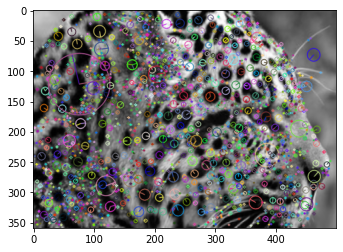

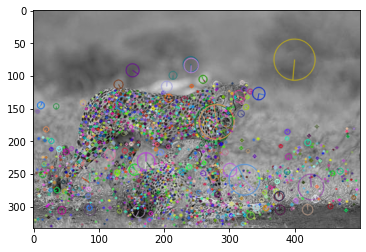

KMeans(n_clusters=100, random_state=50)

In [16]:
all_train_features = extract_with_sift(img_train, display_idxs={0, 5})

# This takes a while
N_CLUSTERS=100
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(all_train_features)

Helper functions

In [17]:
# Returns a normalized histogram of the dictionary word frequency
# using the SIFT descriptors of an image
def build_histogram(kmeans_dict, img_des):
    pred = kmeans_dict.predict(img_des)
    hist, _ = np.histogram(pred, bins=N_CLUSTERS)
    # hist_norm = [float(i)/sum(hist) for i in hist] # comment if running with tf_idf
    return hist

# Reflects importance of BOVW features in the image histograms
# See https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more information
def tf_idf_histogram(train_hists, test_hists):
    hists = np.concatenate((np.array(train_hists), np.array(test_hists)), axis=0)
    tf_idf_hists = np.zeros(hists.shape)
    N = hists.shape[0] # total number of images
    n_i = np.sum(hists > 0, axis=0) # number of images where the word w appears (per word)
    
    for hist_id in range(N):
        n_words_i = np.sum(hists[hist_id]) # number of words in the image

        for word_id in range(len(hists[hist_id])):
            n_wi = hists[hist_id, word_id] # count of word w in image i
            tf_idf_hists[hist_id, word_id] = n_wi / n_words_i * np.log(N/n_i[word_id])

        # Normalize hist_id histogram
        tf_idf_hists[hist_id] = [float(i)/sum(tf_idf_hists[hist_id]) for i in tf_idf_hists[hist_id]]
        
    return tf_idf_hists[:len(train_hists)], tf_idf_hists[-len(test_hists):]

Extract BoVW features

In [18]:
kmeans_train_features = []
for img_id in range(len(img_train)):
    if img_train[img_id] is not None:
        d = [img_train[img_id]]
        kmeans_train_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_train.pop(img_id)

kmeans_test_features = []       
for img_id in range(len(img_test)):
    if img_test[img_id] is not None:
        d = [img_test[img_id]]
        kmeans_test_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_test.pop(img_id)

kmeans_train_features, kmeans_test_features = tf_idf_histogram(kmeans_train_features, kmeans_test_features)

Evaluate with:
    - Random forest classifier
    - Support vector machine

Evaluation with Random Forest Classifier:
Accuracy: 75.0%
F_1: [0.77777778 0.61538462 0.69565217 0.69230769 0.84210526]


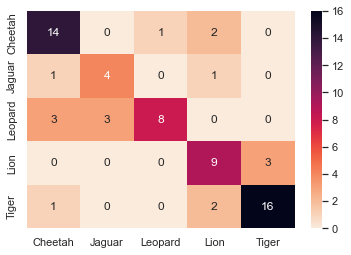

Class: Cheetah, AUC: 0.9596309111880046
Class: Jaguar, AUC: 0.9448924731182796
Class: Leopard, AUC: 0.9814814814814815
Class: Lion, AUC: 0.9464285714285714
Class: Tiger, AUC: 0.9790547798066594


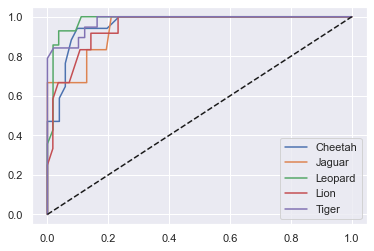


Evaluation with SVM:
Accuracy: 66.17647058823529%
F_1: [0.72222222 0.44444444 0.44444444 0.64285714 0.83333333]


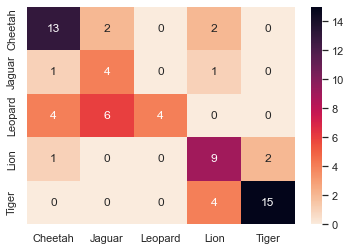

Class: Cheetah, AUC: 0.9619377162629758
Class: Jaguar, AUC: 0.8306451612903225
Class: Leopard, AUC: 0.9563492063492063
Class: Lion, AUC: 0.9255952380952381
Class: Tiger, AUC: 0.9742212674543502


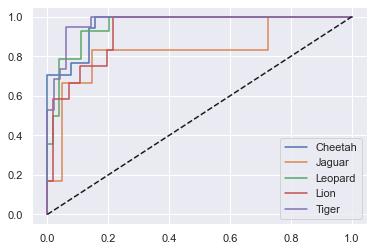

In [54]:
print("Evaluation with Random Forest Classifier:")
run_model(RandomForestClassifier(), kmeans_train_features, label_train, kmeans_test_features, label_test)

print("\nEvaluation with SVM:")
run_model(SVC(probability=True), kmeans_train_features, label_train, kmeans_test_features, label_test)


## Clustering

In [20]:
def clustering_and_vis(model, train_data, test_data, test_labels):
    model.fit(train_data)
    pred = model.predict(test_data)
    silhouette = silhouette_score(test_data, pred)
    mutual_info = mutual_info_score(pred, label_test)
    print("Silhouette: {}, Mutual information: {}".format(silhouette, mutual_info))

    mds = MDS(random_state=RANDOM_STATE, n_components=2)
    X_transform = mds.fit_transform(test_data)

    clusters = np.unique(pred)
    for cluster in clusters:
        r_idx = np.where(np.asarray(pred) == cluster)
        plt.scatter(X_transform[r_idx, 0], X_transform[r_idx, 1], label=cluster)
    plt.legend()
    plt.show()
 


Silhouette: 0.18344810036338255, Mutual information: 0.5456078119437001


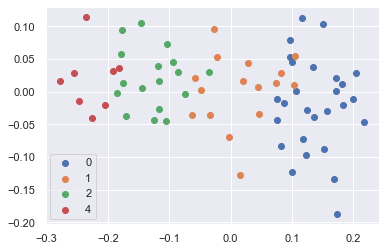

Silhouette: 0.2142027353768951, Mutual information: 0.6388396544161361


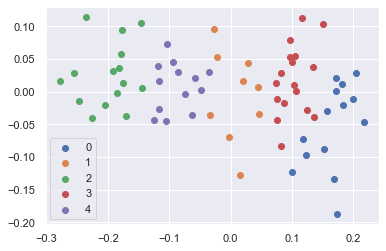

In [21]:

clustering_and_vis(Birch(threshold=0.01, n_clusters=5), kmeans_train_features, kmeans_test_features, label_test)

### FFT

#### Feature Extraction

In [22]:
def fft_spectrum_1D(bw_img):
    f = np.fft.fft2(bw_img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 10*np.log(np.abs(fshift))

    rows, cols = magnitude_spectrum.shape
    magnitude_spectrum_1D = 20*magnitude_spectrum.reshape(rows*cols)

    return magnitude_spectrum.reshape(rows*cols)

def extract_with_fourier(data, display_idxs={}):
    features = []

    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = cv.resize(bw_img, (200, 200))
        features.append(fft_spectrum_1D(bw_img))

    return np.array(features)

In [23]:
train_features = extract_with_fourier(img_train, display_idxs={0, 5})
test_features = extract_with_fourier(img_test)

#### Cross Validation

In [24]:
scores = cross_val_score(KNeighborsClassifier(), train_features, label_train, cv=10)
print("KNN Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(RandomForestClassifier(), train_features, label_train, cv=10)
print("Random Forest Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(SVC(), train_features, label_train, cv=10)
print("SVM: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

KNN Classifier: 38.15% accuracy with a standard deviation of 0.08
Random Forest Classifier: 37.04% accuracy with a standard deviation of 0.08
SVM: 41.48% accuracy with a standard deviation of 0.04


#### Evaluation


Evaluation with KNN:
Accuracy: 36.76470588235294%
F_1: [0.36842105 0.23529412 0.2        0.52941176 0.37037037]


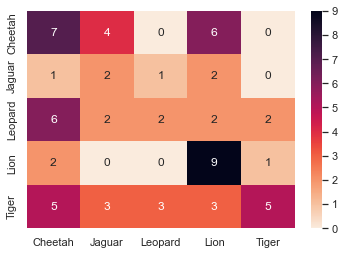

[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
Evaluation with Random Forest Classifier:
Accuracy: 38.23529411764706%
F_1: [0.3125     0.31578947 0.33333333 0.551

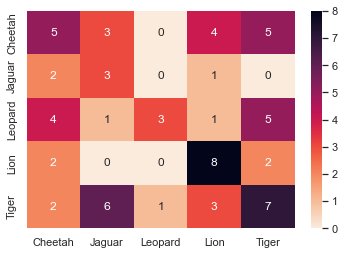

[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]

Evaluation with SVM:
Accuracy: 32.35294117647059%
F_1: [0.21621622 0.33333333 0.         0.58064516 0.33333333]


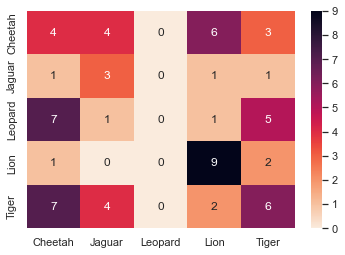

[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [26]:
print("\nEvaluation with KNN:")
score = run_model(KNeighborsClassifier(), train_features, label_train, test_features, label_test)

print("Evaluation with Random Forest Classifier:")
score = run_model(RandomForestClassifier(), train_features, label_train, test_features, label_test)

print("\nEvaluation with SVM:")
score = run_model(SVC(probability=True), train_features, label_train, test_features, label_test)